In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from coniferest.aadforest import AADForest
from coniferest.isoforest import IsolationForest
from coniferest.label import Label
from coniferest.pineforest import PineForest
from coniferest.session.oracle import OracleSession, create_oracle_session

from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest
from coniferest.datasets import Label

import gzip
import tarfile

from IPython.display import Image, display, Markdown

In [108]:
class Compare:
    def __init__(self, data, labels, *, n_jobs=-1):
        model_kwargs = {
            'n_trees': 128,
            'random_seed': 0,
            'n_jobs': n_jobs,
        }
        session_kwargs = {
            'data': data,
            'labels': labels,
            'max_iterations': 100,
        }
        
        self.isoforest_session = create_oracle_session(
            model=IsolationForest(**model_kwargs),
            **session_kwargs,
        )
        self.aadforest_session = create_oracle_session(
            model=AADForest(**model_kwargs),
            **session_kwargs,
        )
        self.pineforest_session = create_oracle_session(
            model=PineForest(**model_kwargs), #weight_ratio=4.0),
            **session_kwargs,
        )

    def run(self):
        print("Running Isolation Forest")
        self.isoforest_session.run()
        print("Running AAD Isolation Forest")
        self.aadforest_session.run()
        print("Running Pine Forest")
        self.pineforest_session.run()
        
        return self
    
    def plot(self, title=None, filename=None):
        plt.figure(figsize=(8, 6))
        if title is None:
            title = 'AD performance curves'
        plt.title(title)
        
        def performance(session):
            return np.cumsum(np.array(list(session.known_labels.values())) == Label.A)

        plt.plot(performance(self.isoforest_session), label='Isolation Forest')
        plt.plot(performance(self.aadforest_session), label='AAD Isolation Forest')
        plt.plot(performance(self.pineforest_session), label='Pine Forest')
        #plt.axhline(sum(self.dataset.labels == Label.A), color='grey')
        plt.xlabel('number of iteration')
        plt.ylabel('true anomalies detected')
        plt.grid()
        plt.legend()

        if filename:
            plt.savefig(filename)
        
        return self

Running Isolation Forest
Running AAD Isolation Forest
Running Pine Forest
CPU times: user 7min 14s, sys: 5.57 s, total: 7min 19s
Wall time: 3min 12s


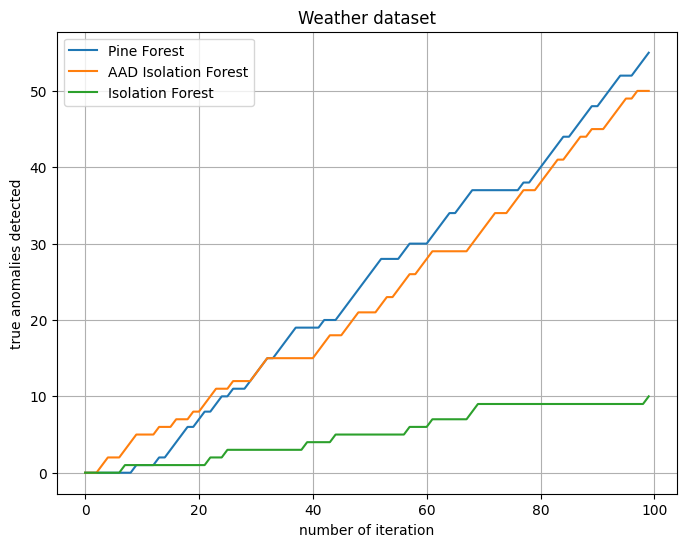

In [6]:
def load_weather_dataset():
    "Weather dataset"
    with gzip.open('../datasets/weather/NEweather_data.csv.gz', 'rt') as file:
        data = np.genfromtxt(file, delimiter=',')

    with gzip.open('../datasets/weather/NEweather_class.csv.gz', 'rt') as file:
        labels = np.genfromtxt(file, delimiter=',')
        labels[labels == 2] = -1
    
    return data, labels

%time Compare(*load_weather_dataset(), n_jobs=15).run().plot("Weather dataset")

In [92]:
column_mapper = {
    "Class1.1": "1.1 Smooth and rounded, no disk? smooth",
    "Class1.2": "1.2 Smooth and rounded, no disk? features or disk",
    "Class1.3": "1.3 Smooth and rounded, no disk? star or artifact",
    "Class2.1": "2.1 Disk viewed edge on? yes",
    "Class2.2": "2.2 Disk viewed edge on? no",
    "Class3.1": "3.1 Bar feature through a center? yes",
    "Class3.2": "3.2 Bar feature through a center? no",
    "Class4.1": "4.1 Spiral arm? yes",
    "Class4.2": "4.2 Spiral arm? no",
    "Class5.1": "5.1 Prominent center bulge? no bulge",
    "Class5.2": "5.2 Prominent center bulge? noticable",
    "Class5.3": "5.3 Prominent center bulge? obvious",
    "Class5.4": "5.4 Prominent center bulge? dominant",
    "Class6.1": "6.1 Anything odd? yes",
    "Class6.2": "6.2 Anything odd? no",
    "Class7.1": "7.1 Is rounded? completely round",
    "Class7.2": "7.2 Is rounded? in between",
    "Class7.3": "7.3 Is rounded? cigar-shaped",
    "Class8.1": "8.1 Odd feature. ring",
    "Class8.2": "8.2 Odd feature. lens or arc",
    "Class8.3": "8.3 Odd feature. distributed",
    "Class8.4": "8.4 Odd feature. irregular",
    "Class8.5": "8.5 Odd feature. other",
    "Class8.6": "8.6 Odd feature. merger",
    "Class8.7": "8.7 Odd feature. dust lane",
    "Class9.1": "9.1 Bulge shape. rounded",
    "Class9.2": "9.2 Bulge shape. boxy",
    "Class9.3": "9.3 Bulge shape. no bulge",
    "Class10.1": "10.1 Spiral arms shape. tight",
    "Class10.2": "10.2 Spiral arms shape. medium",
    "Class10.3": "10.3 Spiral arms shape. loose",
    "Class11.1": "11.1 Spiral arms count. 1",
    "Class11.2": "11.2 Spiral arms count. 2",
    "Class11.3": "11.3 Spiral arms count. 3",
    "Class11.4": "11.4 Spiral arms count. 4",
    "Class11.5": "11.5 Spiral arms count. more",
    "Class11.6": "11.6 Spiral arms count. cant tell",
}

def load_galaxy_zoo2(anomaly_class='Class6.1', anomaly_threshold=0.9):
    "Galaxy Zoo 2 dataset"
    path = '../datasets/gz2/astronomaly.parquet'
    astronomaly = pd.read_parquet(path)
    data = astronomaly.drop(columns=['GalaxyID', 'anomaly']).to_numpy().copy(order='C')
    ids = astronomaly['GalaxyID'].to_numpy()

    solutions = pd.read_csv("../../data/gz2/training_solutions_rev1.csv", index_col="GalaxyID")
    anomaly = solutions[anomaly_class][ids] >= anomaly_threshold
    labels = np.full(anomaly.shape, Label.R)
    labels[anomaly] = Label.A
    
    return data, labels, ids

def trace_galaxy_zoo_2(session):
    solutions = pd.read_csv("../../data/gz2/training_solutions_rev1.csv", index_col="GalaxyID")
    solutions = solutions.rename(columns=column_mapper)

    astronomaly = pd.read_parquet('../datasets/gz2/astronomaly.parquet')
    ids = astronomaly['GalaxyID'].to_numpy()

    for i, label in session.known_labels.items():
        id_ = ids[i]
    
        display(Markdown(f"{id_}: {Label(label).name}"))
        display(Image(filename=f"../../data/gz2/images_training_rev1/{id_}.jpg"))
        display(solutions.loc[id_])

Running Isolation Forest
Running AAD Isolation Forest
Running Pine Forest
CPU times: user 13min 14s, sys: 17 s, total: 13min 31s
Wall time: 5min 25s


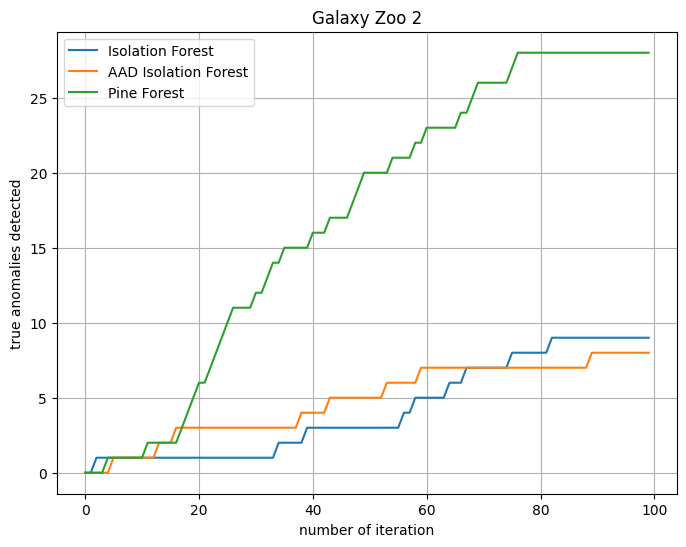

In [93]:
data, labels, ids = load_galaxy_zoo2(anomaly_class='Class6.1', anomaly_threshold=0.9)
cmp_61_90 = Compare(data, labels, n_jobs=15)
%time cmp_61_90.run()
cmp_61_90.plot(title="Galaxy Zoo 2 (Anything odd? 90%)", filename="gz2_61_90.pdf")

701930: REGULAR

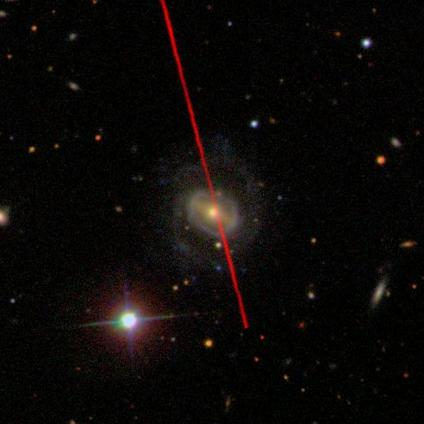

1.1 Smooth and rounded, no disk? smooth              0.086556
1.2 Smooth and rounded, no disk? features or disk    0.854299
1.3 Smooth and rounded, no disk? star or artifact    0.059146
2.1 Disk viewed edge on? yes                         0.037636
2.2 Disk viewed edge on? no                          0.816663
3.1 Bar feature through a center? yes                0.682959
3.2 Bar feature through a center? no                 0.133704
4.1 Spiral arm? yes                                  0.119150
4.2 Spiral arm? no                                   0.697513
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.108949
5.3 Prominent center bulge? obvious                  0.513188
5.4 Prominent center bulge? dominant                 0.194526
6.1 Anything odd? yes                                0.830922
6.2 Anything odd? no                                 0.169078
7.1 Is rounded? completely round                     0.044749
7.2 Is r

640786: REGULAR

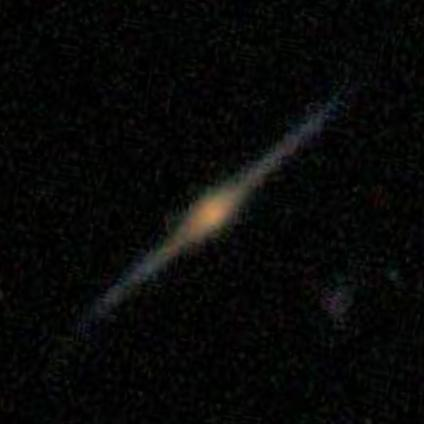

1.1 Smooth and rounded, no disk? smooth              0.017837
1.2 Smooth and rounded, no disk? features or disk    0.982163
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.982163
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.067234
6.2 Anything odd? no                                 0.932766
7.1 Is rounded? completely round                     0.000000
7.2 Is r

491495: REGULAR

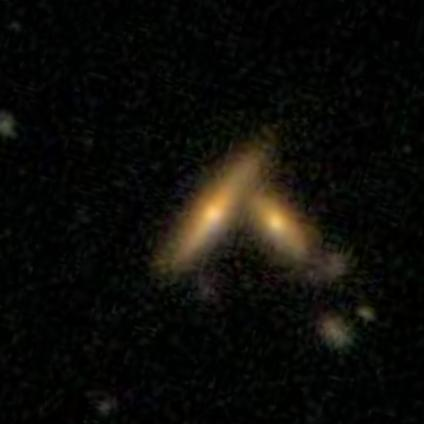

1.1 Smooth and rounded, no disk? smooth              0.151776
1.2 Smooth and rounded, no disk? features or disk    0.823610
1.3 Smooth and rounded, no disk? star or artifact    0.024614
2.1 Disk viewed edge on? yes                         0.767062
2.2 Disk viewed edge on? no                          0.056548
3.1 Bar feature through a center? yes                0.056548
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.056548
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.056548
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.726736
6.2 Anything odd? no                                 0.273264
7.1 Is rounded? completely round                     0.000000
7.2 Is r

414272: REGULAR

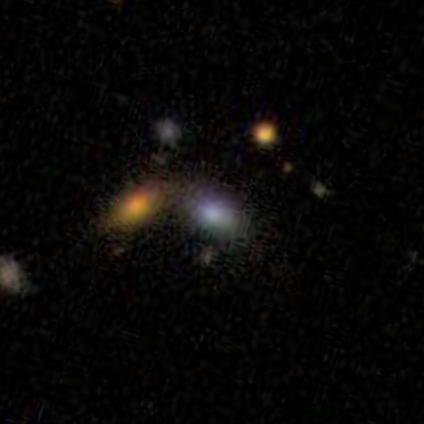

1.1 Smooth and rounded, no disk? smooth              0.698186
1.2 Smooth and rounded, no disk? features or disk    0.228676
1.3 Smooth and rounded, no disk? star or artifact    0.073138
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.228676
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.228676
4.1 Spiral arm? yes                                  0.116532
4.2 Spiral arm? no                                   0.112144
5.1 Prominent center bulge? no bulge                 0.042877
5.2 Prominent center bulge? noticable                0.159703
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.026096
6.1 Anything odd? yes                                0.602920
6.2 Anything odd? no                                 0.397080
7.1 Is rounded? completely round                     0.086523
7.2 Is r

882284: ANOMALY

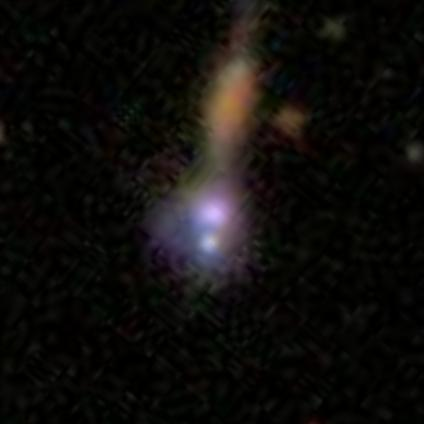

1.1 Smooth and rounded, no disk? smooth              0.162834
1.2 Smooth and rounded, no disk? features or disk    0.763580
1.3 Smooth and rounded, no disk? star or artifact    0.073586
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.763580
3.1 Bar feature through a center? yes                0.177003
3.2 Bar feature through a center? no                 0.586577
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.763580
5.1 Prominent center bulge? no bulge                 0.066929
5.2 Prominent center bulge? noticable                0.180471
5.3 Prominent center bulge? obvious                  0.352138
5.4 Prominent center bulge? dominant                 0.164042
6.1 Anything odd? yes                                0.969042
6.2 Anything odd? no                                 0.030958
7.1 Is rounded? completely round                     0.051921
7.2 Is r

872866: REGULAR

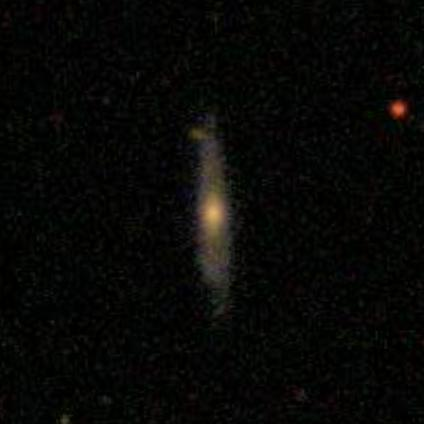

1.1 Smooth and rounded, no disk? smooth              0.069023
1.2 Smooth and rounded, no disk? features or disk    0.930534
1.3 Smooth and rounded, no disk? star or artifact    0.000443
2.1 Disk viewed edge on? yes                         0.883906
2.2 Disk viewed edge on? no                          0.046628
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.046628
4.1 Spiral arm? yes                                  0.046628
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.046628
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.163711
6.2 Anything odd? no                                 0.836289
7.1 Is rounded? completely round                     0.002005
7.2 Is r

584391: REGULAR

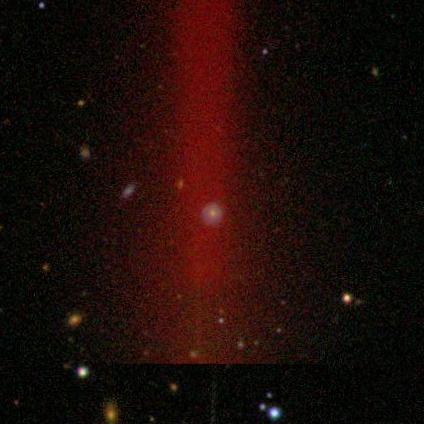

1.1 Smooth and rounded, no disk? smooth              0.176000
1.2 Smooth and rounded, no disk? features or disk    0.206000
1.3 Smooth and rounded, no disk? star or artifact    0.618000
2.1 Disk viewed edge on? yes                         0.029458
2.2 Disk viewed edge on? no                          0.176542
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.176542
4.1 Spiral arm? yes                                  0.058788
4.2 Spiral arm? no                                   0.117754
5.1 Prominent center bulge? no bulge                 0.029483
5.2 Prominent center bulge? noticable                0.088271
5.3 Prominent center bulge? obvious                  0.058788
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.615000
6.2 Anything odd? no                                 0.385000
7.1 Is rounded? completely round                     0.146608
7.2 Is r

808755: REGULAR

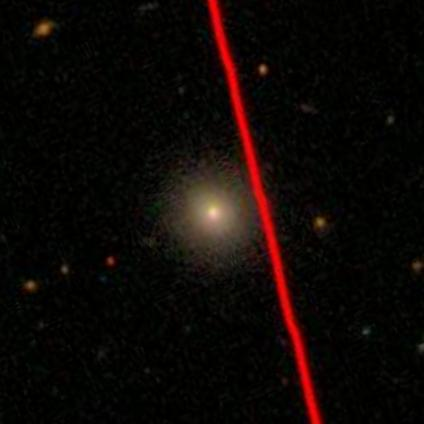

1.1 Smooth and rounded, no disk? smooth              0.720660
1.2 Smooth and rounded, no disk? features or disk    0.139668
1.3 Smooth and rounded, no disk? star or artifact    0.139672
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.139668
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.139668
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.139668
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.139668
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.303984
6.2 Anything odd? no                                 0.696016
7.1 Is rounded? completely round                     0.692011
7.2 Is r

349811: REGULAR

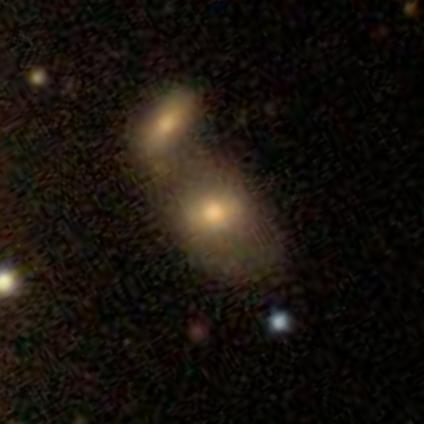

1.1 Smooth and rounded, no disk? smooth              0.368384
1.2 Smooth and rounded, no disk? features or disk    0.614021
1.3 Smooth and rounded, no disk? star or artifact    0.017595
2.1 Disk viewed edge on? yes                         0.039722
2.2 Disk viewed edge on? no                          0.574299
3.1 Bar feature through a center? yes                0.269113
3.2 Bar feature through a center? no                 0.305186
4.1 Spiral arm? yes                                  0.236787
4.2 Spiral arm? no                                   0.337512
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.160896
5.3 Prominent center bulge? obvious                  0.372916
5.4 Prominent center bulge? dominant                 0.040487
6.1 Anything odd? yes                                0.773246
6.2 Anything odd? no                                 0.226754
7.1 Is rounded? completely round                     0.086127
7.2 Is r

690722: REGULAR

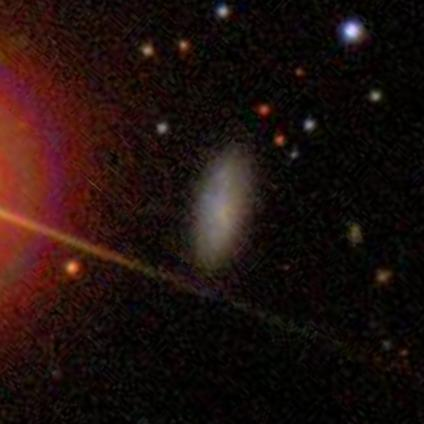

1.1 Smooth and rounded, no disk? smooth              0.406477
1.2 Smooth and rounded, no disk? features or disk    0.562591
1.3 Smooth and rounded, no disk? star or artifact    0.030932
2.1 Disk viewed edge on? yes                         0.197409
2.2 Disk viewed edge on? no                          0.365182
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.365182
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.365182
5.1 Prominent center bulge? no bulge                 0.365182
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.141770
6.2 Anything odd? no                                 0.858230
7.1 Is rounded? completely round                     0.000000
7.2 Is r

193873: REGULAR

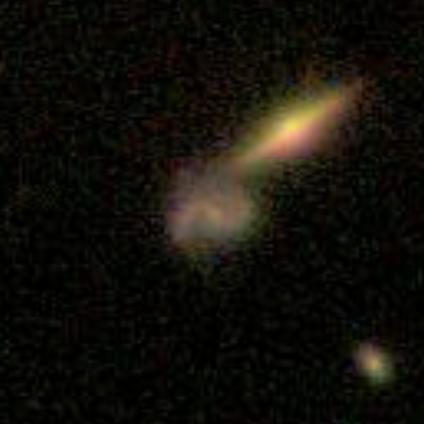

1.1 Smooth and rounded, no disk? smooth              0.023499
1.2 Smooth and rounded, no disk? features or disk    0.934237
1.3 Smooth and rounded, no disk? star or artifact    0.042264
2.1 Disk viewed edge on? yes                         0.247306
2.2 Disk viewed edge on? no                          0.686931
3.1 Bar feature through a center? yes                0.458899
3.2 Bar feature through a center? no                 0.228032
4.1 Spiral arm? yes                                  0.638980
4.2 Spiral arm? no                                   0.047951
5.1 Prominent center bulge? no bulge                 0.103018
5.2 Prominent center bulge? noticable                0.467673
5.3 Prominent center bulge? obvious                  0.116241
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.769667
6.2 Anything odd? no                                 0.230333
7.1 Is rounded? completely round                     0.004826
7.2 Is r

618840: ANOMALY

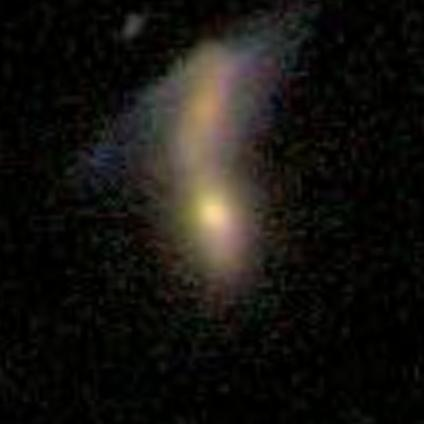

1.1 Smooth and rounded, no disk? smooth              0.425392
1.2 Smooth and rounded, no disk? features or disk    0.538016
1.3 Smooth and rounded, no disk? star or artifact    0.036592
2.1 Disk viewed edge on? yes                         0.011094
2.2 Disk viewed edge on? no                          0.526922
3.1 Bar feature through a center? yes                0.211268
3.2 Bar feature through a center? no                 0.315654
4.1 Spiral arm? yes                                  0.233985
4.2 Spiral arm? no                                   0.292937
5.1 Prominent center bulge? no bulge                 0.053128
5.2 Prominent center bulge? noticable                0.119030
5.3 Prominent center bulge? obvious                  0.127208
5.4 Prominent center bulge? dominant                 0.227556
6.1 Anything odd? yes                                0.989511
6.2 Anything odd? no                                 0.010489
7.1 Is rounded? completely round                     0.021144
7.2 Is r

223862: REGULAR

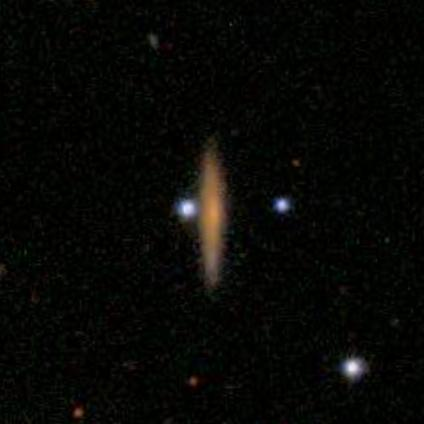

1.1 Smooth and rounded, no disk? smooth              0.124876
1.2 Smooth and rounded, no disk? features or disk    0.875124
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.811665
2.2 Disk viewed edge on? no                          0.063459
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.063459
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.063459
5.1 Prominent center bulge? no bulge                 0.063459
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.244891
6.2 Anything odd? no                                 0.755109
7.1 Is rounded? completely round                     0.000000
7.2 Is r

436942: REGULAR

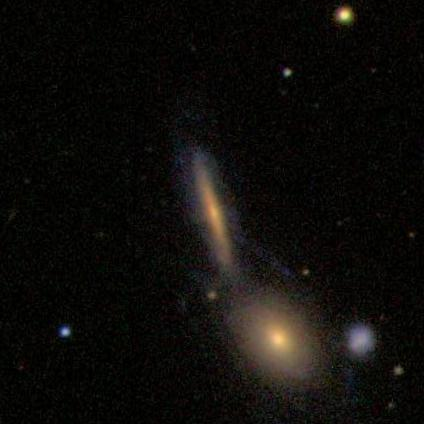

1.1 Smooth and rounded, no disk? smooth              0.227899
1.2 Smooth and rounded, no disk? features or disk    0.744639
1.3 Smooth and rounded, no disk? star or artifact    0.027462
2.1 Disk viewed edge on? yes                         0.629624
2.2 Disk viewed edge on? no                          0.115015
3.1 Bar feature through a center? yes                0.008303
3.2 Bar feature through a center? no                 0.106712
4.1 Spiral arm? yes                                  0.005137
4.2 Spiral arm? no                                   0.109877
5.1 Prominent center bulge? no bulge                 0.035744
5.2 Prominent center bulge? noticable                0.005716
5.3 Prominent center bulge? obvious                  0.073555
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.679009
6.2 Anything odd? no                                 0.320991
7.1 Is rounded? completely round                     0.000000
7.2 Is r

883093: REGULAR

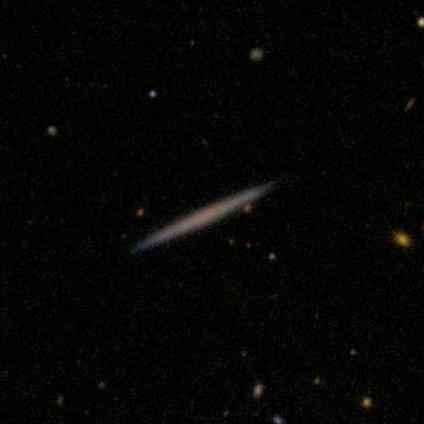

1.1 Smooth and rounded, no disk? smooth              0.259895
1.2 Smooth and rounded, no disk? features or disk    0.740105
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.740105
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.000000
6.2 Anything odd? no                                 1.000000
7.1 Is rounded? completely round                     0.000000
7.2 Is r

950985: REGULAR

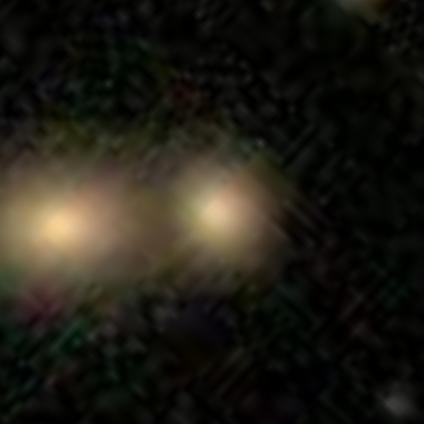

1.1 Smooth and rounded, no disk? smooth              0.740248
1.2 Smooth and rounded, no disk? features or disk    0.194773
1.3 Smooth and rounded, no disk? star or artifact    0.064979
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.194773
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.194773
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.194773
5.1 Prominent center bulge? no bulge                 0.039773
5.2 Prominent center bulge? noticable                0.079545
5.3 Prominent center bulge? obvious                  0.045370
5.4 Prominent center bulge? dominant                 0.030085
6.1 Anything odd? yes                                0.895582
6.2 Anything odd? no                                 0.104418
7.1 Is rounded? completely round                     0.442238
7.2 Is r

259012: REGULAR

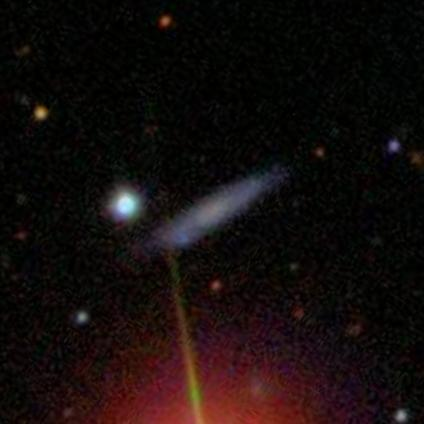

1.1 Smooth and rounded, no disk? smooth              0.151822
1.2 Smooth and rounded, no disk? features or disk    0.848178
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.600639
2.2 Disk viewed edge on? no                          0.247539
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.247539
4.1 Spiral arm? yes                                  0.093479
4.2 Spiral arm? no                                   0.154060
5.1 Prominent center bulge? no bulge                 0.247539
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.249624
6.2 Anything odd? no                                 0.750376
7.1 Is rounded? completely round                     0.000000
7.2 Is r

442496: ANOMALY

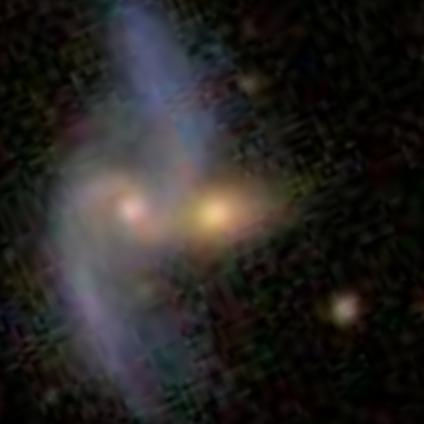

1.1 Smooth and rounded, no disk? smooth              0.150481
1.2 Smooth and rounded, no disk? features or disk    0.838046
1.3 Smooth and rounded, no disk? star or artifact    0.011473
2.1 Disk viewed edge on? yes                         0.125707
2.2 Disk viewed edge on? no                          0.712339
3.1 Bar feature through a center? yes                0.452286
3.2 Bar feature through a center? no                 0.260053
4.1 Spiral arm? yes                                  0.681257
4.2 Spiral arm? no                                   0.031082
5.1 Prominent center bulge? no bulge                 0.022471
5.2 Prominent center bulge? noticable                0.254481
5.3 Prominent center bulge? obvious                  0.381129
5.4 Prominent center bulge? dominant                 0.054257
6.1 Anything odd? yes                                0.943806
6.2 Anything odd? no                                 0.056194
7.1 Is rounded? completely round                     0.017371
7.2 Is r

762881: ANOMALY

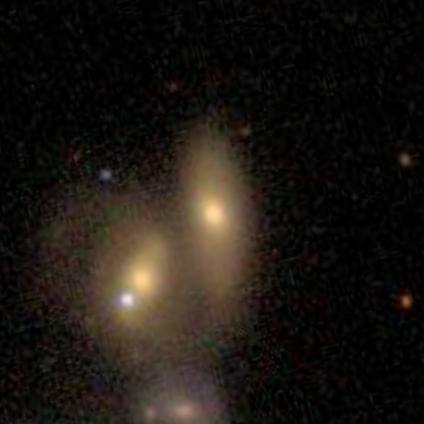

1.1 Smooth and rounded, no disk? smooth              0.475886
1.2 Smooth and rounded, no disk? features or disk    0.458030
1.3 Smooth and rounded, no disk? star or artifact    0.066084
2.1 Disk viewed edge on? yes                         0.107637
2.2 Disk viewed edge on? no                          0.350393
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.350393
4.1 Spiral arm? yes                                  0.118236
4.2 Spiral arm? no                                   0.232157
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.026982
5.3 Prominent center bulge? obvious                  0.294113
5.4 Prominent center bulge? dominant                 0.029298
6.1 Anything odd? yes                                0.935600
6.2 Anything odd? no                                 0.064400
7.1 Is rounded? completely round                     0.000000
7.2 Is r

601610: ANOMALY

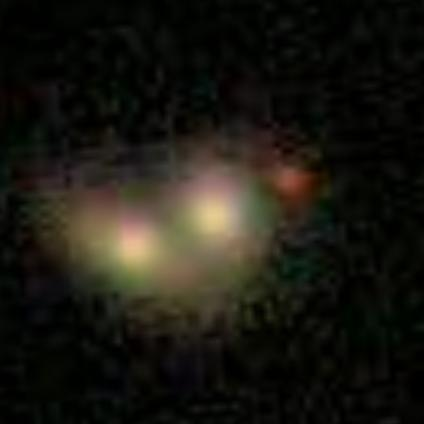

1.1 Smooth and rounded, no disk? smooth              0.344308
1.2 Smooth and rounded, no disk? features or disk    0.619039
1.3 Smooth and rounded, no disk? star or artifact    0.036653
2.1 Disk viewed edge on? yes                         0.008464
2.2 Disk viewed edge on? no                          0.610575
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.610575
4.1 Spiral arm? yes                                  0.152844
4.2 Spiral arm? no                                   0.457732
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.403811
5.4 Prominent center bulge? dominant                 0.206765
6.1 Anything odd? yes                                0.991454
6.2 Anything odd? no                                 0.008546
7.1 Is rounded? completely round                     0.157083
7.2 Is r

373505: ANOMALY

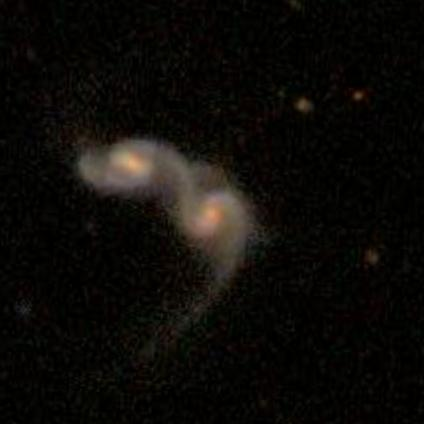

1.1 Smooth and rounded, no disk? smooth              0.000000
1.2 Smooth and rounded, no disk? features or disk    0.984010
1.3 Smooth and rounded, no disk? star or artifact    0.015990
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.984010
3.1 Bar feature through a center? yes                0.456347
3.2 Bar feature through a center? no                 0.527663
4.1 Spiral arm? yes                                  0.984010
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.046149
5.2 Prominent center bulge? noticable                0.402812
5.3 Prominent center bulge? obvious                  0.424596
5.4 Prominent center bulge? dominant                 0.110453
6.1 Anything odd? yes                                1.000000
6.2 Anything odd? no                                 0.000000
7.1 Is rounded? completely round                     0.000000
7.2 Is r

753840: REGULAR

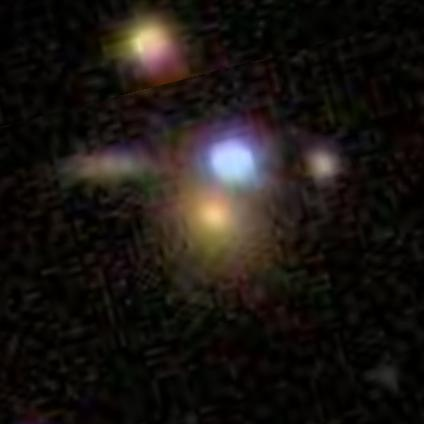

1.1 Smooth and rounded, no disk? smooth              0.612010
1.2 Smooth and rounded, no disk? features or disk    0.323562
1.3 Smooth and rounded, no disk? star or artifact    0.064427
2.1 Disk viewed edge on? yes                         0.080891
2.2 Disk viewed edge on? no                          0.242672
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.242672
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.242672
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.095695
5.3 Prominent center bulge? obvious                  0.101769
5.4 Prominent center bulge? dominant                 0.045207
6.1 Anything odd? yes                                0.685598
6.2 Anything odd? no                                 0.314402
7.1 Is rounded? completely round                     0.443491
7.2 Is r

530799: ANOMALY

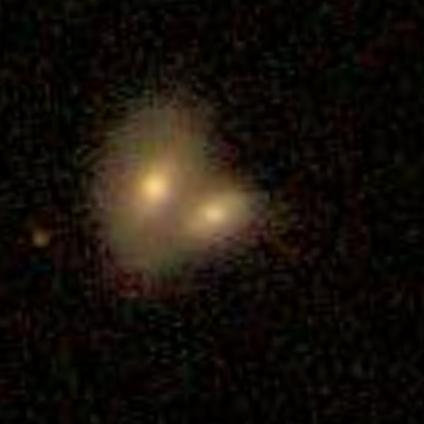

1.1 Smooth and rounded, no disk? smooth              0.375468
1.2 Smooth and rounded, no disk? features or disk    0.613459
1.3 Smooth and rounded, no disk? star or artifact    0.011073
2.1 Disk viewed edge on? yes                         0.159498
2.2 Disk viewed edge on? no                          0.453961
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.453961
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.453961
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.453961
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.948269
6.2 Anything odd? no                                 0.051731
7.1 Is rounded? completely round                     0.030960
7.2 Is r

543677: ANOMALY

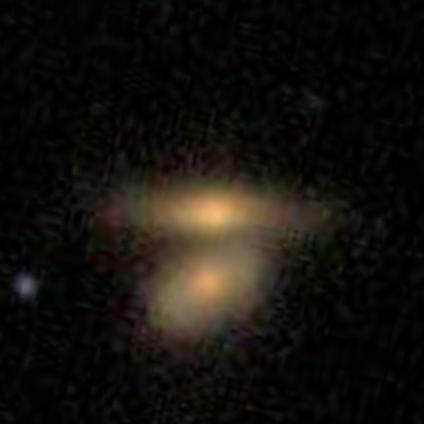

1.1 Smooth and rounded, no disk? smooth              0.207418
1.2 Smooth and rounded, no disk? features or disk    0.783107
1.3 Smooth and rounded, no disk? star or artifact    0.009475
2.1 Disk viewed edge on? yes                         0.292770
2.2 Disk viewed edge on? no                          0.490337
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.490337
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.490337
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.404458
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.085879
6.1 Anything odd? yes                                0.922262
6.2 Anything odd? no                                 0.077738
7.1 Is rounded? completely round                     0.000000
7.2 Is r

385733: ANOMALY

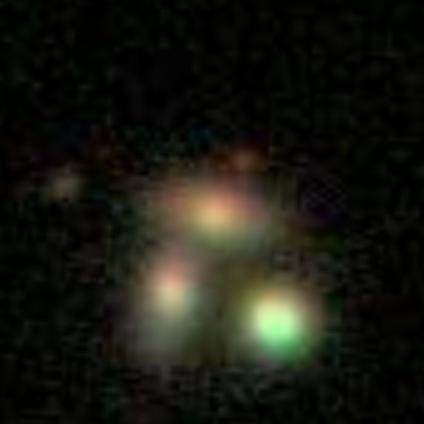

1.1 Smooth and rounded, no disk? smooth              0.318727
1.2 Smooth and rounded, no disk? features or disk    0.644354
1.3 Smooth and rounded, no disk? star or artifact    0.036919
2.1 Disk viewed edge on? yes                         0.025093
2.2 Disk viewed edge on? no                          0.619261
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.619261
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.619261
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.361640
5.4 Prominent center bulge? dominant                 0.257621
6.1 Anything odd? yes                                0.953939
6.2 Anything odd? no                                 0.046061
7.1 Is rounded? completely round                     0.044396
7.2 Is r

273450: ANOMALY

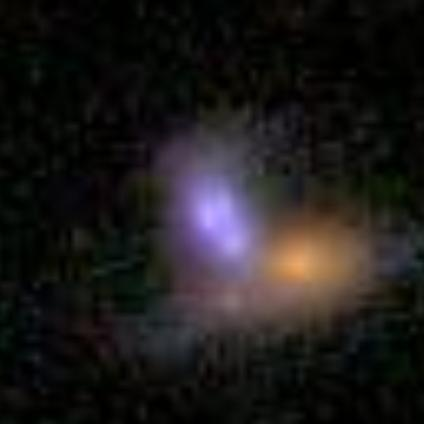

1.1 Smooth and rounded, no disk? smooth              0.360031
1.2 Smooth and rounded, no disk? features or disk    0.584176
1.3 Smooth and rounded, no disk? star or artifact    0.055792
2.1 Disk viewed edge on? yes                         0.044982
2.2 Disk viewed edge on? no                          0.539194
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.539194
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.539194
5.1 Prominent center bulge? no bulge                 0.101922
5.2 Prominent center bulge? noticable                0.239704
5.3 Prominent center bulge? obvious                  0.146468
5.4 Prominent center bulge? dominant                 0.051099
6.1 Anything odd? yes                                0.971615
6.2 Anything odd? no                                 0.028385
7.1 Is rounded? completely round                     0.087779
7.2 Is r

811333: ANOMALY

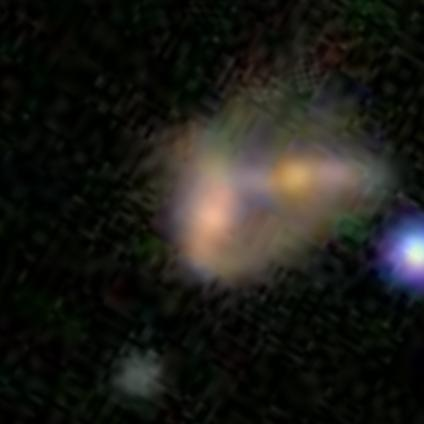

1.1 Smooth and rounded, no disk? smooth              0.062095
1.2 Smooth and rounded, no disk? features or disk    0.909428
1.3 Smooth and rounded, no disk? star or artifact    0.028477
2.1 Disk viewed edge on? yes                         0.020996
2.2 Disk viewed edge on? no                          0.888432
3.1 Bar feature through a center? yes                0.692007
3.2 Bar feature through a center? no                 0.196425
4.1 Spiral arm? yes                                  0.442641
4.2 Spiral arm? no                                   0.445791
5.1 Prominent center bulge? no bulge                 0.195261
5.2 Prominent center bulge? noticable                0.356574
5.3 Prominent center bulge? obvious                  0.210796
5.4 Prominent center bulge? dominant                 0.125801
6.1 Anything odd? yes                                0.987667
6.2 Anything odd? no                                 0.012333
7.1 Is rounded? completely round                     0.000000
7.2 Is r

757105: REGULAR

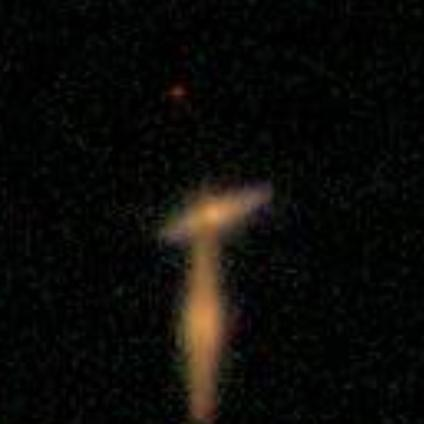

1.1 Smooth and rounded, no disk? smooth              0.058494
1.2 Smooth and rounded, no disk? features or disk    0.936717
1.3 Smooth and rounded, no disk? star or artifact    0.004790
2.1 Disk viewed edge on? yes                         0.809280
2.2 Disk viewed edge on? no                          0.127437
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.127437
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.127437
5.1 Prominent center bulge? no bulge                 0.127437
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.745700
6.2 Anything odd? no                                 0.254300
7.1 Is rounded? completely round                     0.000000
7.2 Is r

962360: REGULAR

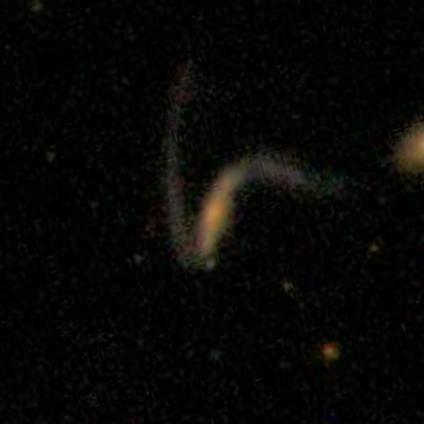

1.1 Smooth and rounded, no disk? smooth              0.004839
1.2 Smooth and rounded, no disk? features or disk    0.987711
1.3 Smooth and rounded, no disk? star or artifact    0.007450
2.1 Disk viewed edge on? yes                         0.117698
2.2 Disk viewed edge on? no                          0.870013
3.1 Bar feature through a center? yes                0.577126
3.2 Bar feature through a center? no                 0.292887
4.1 Spiral arm? yes                                  0.695851
4.2 Spiral arm? no                                   0.174162
5.1 Prominent center bulge? no bulge                 0.059879
5.2 Prominent center bulge? noticable                0.292423
5.3 Prominent center bulge? obvious                  0.517712
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.881818
6.2 Anything odd? no                                 0.118182
7.1 Is rounded? completely round                     0.000000
7.2 Is r

849543: REGULAR

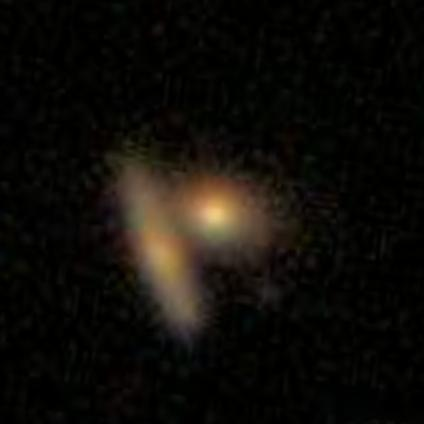

1.1 Smooth and rounded, no disk? smooth              0.189478
1.2 Smooth and rounded, no disk? features or disk    0.810522
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.113571
2.2 Disk viewed edge on? no                          0.696951
3.1 Bar feature through a center? yes                0.225139
3.2 Bar feature through a center? no                 0.471812
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.696951
5.1 Prominent center bulge? no bulge                 0.124319
5.2 Prominent center bulge? noticable                0.234351
5.3 Prominent center bulge? obvious                  0.189628
5.4 Prominent center bulge? dominant                 0.148653
6.1 Anything odd? yes                                0.852623
6.2 Anything odd? no                                 0.147377
7.1 Is rounded? completely round                     0.085970
7.2 Is r

238723: ANOMALY

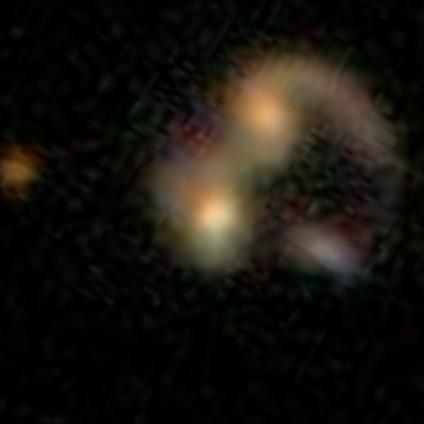

1.1 Smooth and rounded, no disk? smooth              0.236828
1.2 Smooth and rounded, no disk? features or disk    0.761285
1.3 Smooth and rounded, no disk? star or artifact    0.001888
2.1 Disk viewed edge on? yes                         0.036542
2.2 Disk viewed edge on? no                          0.724743
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.724743
4.1 Spiral arm? yes                                  0.604031
4.2 Spiral arm? no                                   0.120713
5.1 Prominent center bulge? no bulge                 0.013183
5.2 Prominent center bulge? noticable                0.284367
5.3 Prominent center bulge? obvious                  0.282014
5.4 Prominent center bulge? dominant                 0.145179
6.1 Anything odd? yes                                0.963291
6.2 Anything odd? no                                 0.036709
7.1 Is rounded? completely round                     0.105162
7.2 Is r

403352: REGULAR

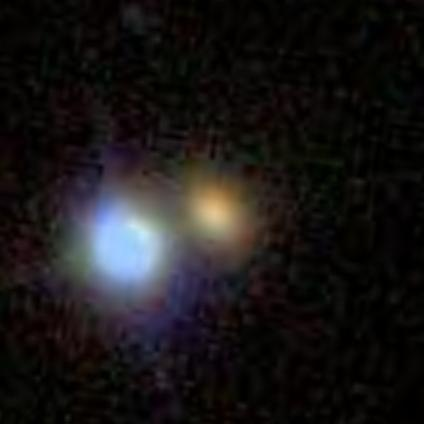

1.1 Smooth and rounded, no disk? smooth              0.689393
1.2 Smooth and rounded, no disk? features or disk    0.182645
1.3 Smooth and rounded, no disk? star or artifact    0.127961
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.182645
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.182645
4.1 Spiral arm? yes                                  0.143239
4.2 Spiral arm? no                                   0.039406
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.115252
5.4 Prominent center bulge? dominant                 0.067393
6.1 Anything odd? yes                                0.748796
6.2 Anything odd? no                                 0.251204
7.1 Is rounded? completely round                     0.286490
7.2 Is r

790978: ANOMALY

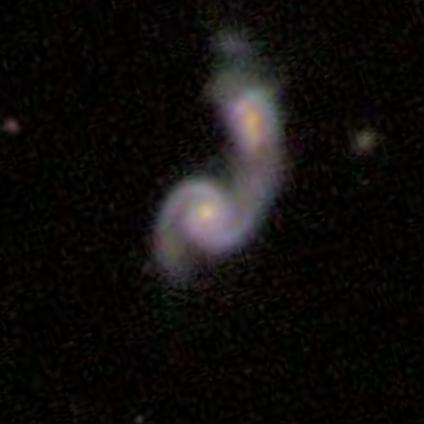

1.1 Smooth and rounded, no disk? smooth              0.011748
1.2 Smooth and rounded, no disk? features or disk    0.981344
1.3 Smooth and rounded, no disk? star or artifact    0.006908
2.1 Disk viewed edge on? yes                         0.046318
2.2 Disk viewed edge on? no                          0.935026
3.1 Bar feature through a center? yes                0.103747
3.2 Bar feature through a center? no                 0.831279
4.1 Spiral arm? yes                                  0.897632
4.2 Spiral arm? no                                   0.037394
5.1 Prominent center bulge? no bulge                 0.035034
5.2 Prominent center bulge? noticable                0.495700
5.3 Prominent center bulge? obvious                  0.297167
5.4 Prominent center bulge? dominant                 0.107125
6.1 Anything odd? yes                                0.972100
6.2 Anything odd? no                                 0.027900
7.1 Is rounded? completely round                     0.000000
7.2 Is r

670070: ANOMALY

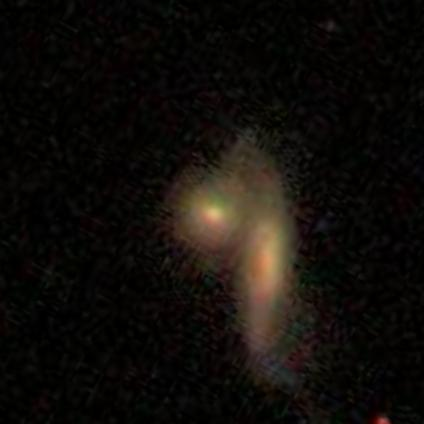

1.1 Smooth and rounded, no disk? smooth              0.202853
1.2 Smooth and rounded, no disk? features or disk    0.795470
1.3 Smooth and rounded, no disk? star or artifact    0.001677
2.1 Disk viewed edge on? yes                         0.077802
2.2 Disk viewed edge on? no                          0.717668
3.1 Bar feature through a center? yes                0.067417
3.2 Bar feature through a center? no                 0.650251
4.1 Spiral arm? yes                                  0.357723
4.2 Spiral arm? no                                   0.359945
5.1 Prominent center bulge? no bulge                 0.025388
5.2 Prominent center bulge? noticable                0.284210
5.3 Prominent center bulge? obvious                  0.408070
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.957972
6.2 Anything odd? no                                 0.042028
7.1 Is rounded? completely round                     0.145746
7.2 Is r

457786: REGULAR

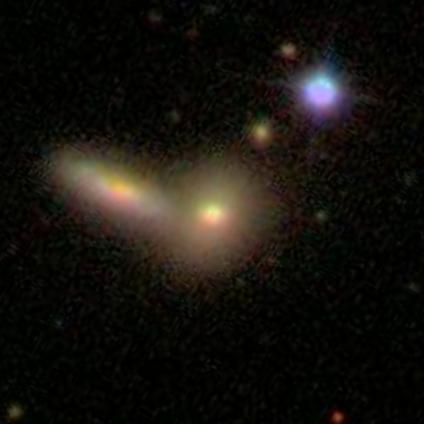

1.1 Smooth and rounded, no disk? smooth              0.744978
1.2 Smooth and rounded, no disk? features or disk    0.219894
1.3 Smooth and rounded, no disk? star or artifact    0.035129
2.1 Disk viewed edge on? yes                         0.041919
2.2 Disk viewed edge on? no                          0.177975
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.177975
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.177975
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.177975
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.884521
6.2 Anything odd? no                                 0.115479
7.1 Is rounded? completely round                     0.591825
7.2 Is r

260911: ANOMALY

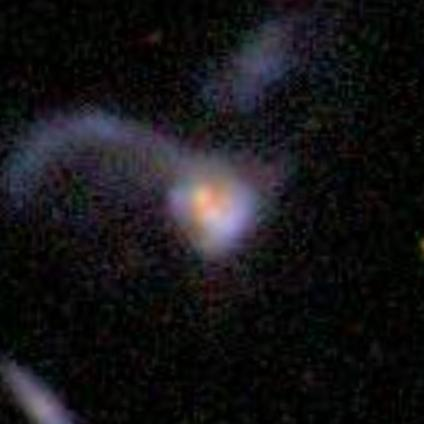

1.1 Smooth and rounded, no disk? smooth              0.155025
1.2 Smooth and rounded, no disk? features or disk    0.842211
1.3 Smooth and rounded, no disk? star or artifact    0.002763
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.842211
3.1 Bar feature through a center? yes                0.107165
3.2 Bar feature through a center? no                 0.735046
4.1 Spiral arm? yes                                  0.568791
4.2 Spiral arm? no                                   0.273420
5.1 Prominent center bulge? no bulge                 0.063447
5.2 Prominent center bulge? noticable                0.078380
5.3 Prominent center bulge? obvious                  0.070891
5.4 Prominent center bulge? dominant                 0.629493
6.1 Anything odd? yes                                0.915733
6.2 Anything odd? no                                 0.084267
7.1 Is rounded? completely round                     0.069814
7.2 Is r

194608: REGULAR

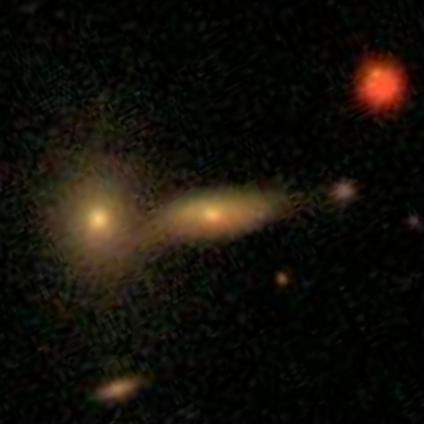

1.1 Smooth and rounded, no disk? smooth              0.284217
1.2 Smooth and rounded, no disk? features or disk    0.703591
1.3 Smooth and rounded, no disk? star or artifact    0.012192
2.1 Disk viewed edge on? yes                         0.225598
2.2 Disk viewed edge on? no                          0.477993
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.477993
4.1 Spiral arm? yes                                  0.184568
4.2 Spiral arm? no                                   0.293425
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.180329
5.3 Prominent center bulge? obvious                  0.255597
5.4 Prominent center bulge? dominant                 0.042068
6.1 Anything odd? yes                                0.688203
6.2 Anything odd? no                                 0.311797
7.1 Is rounded? completely round                     0.000000
7.2 Is r

159862: REGULAR

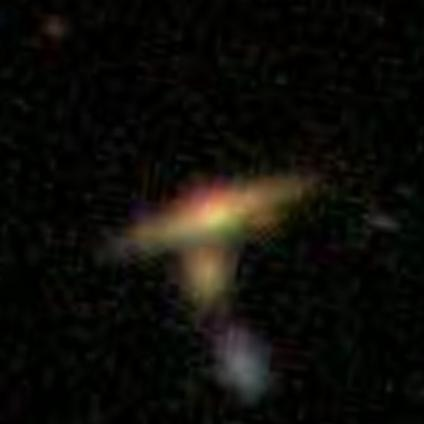

1.1 Smooth and rounded, no disk? smooth              0.110008
1.2 Smooth and rounded, no disk? features or disk    0.870651
1.3 Smooth and rounded, no disk? star or artifact    0.019341
2.1 Disk viewed edge on? yes                         0.669363
2.2 Disk viewed edge on? no                          0.201288
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.201288
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.201288
5.1 Prominent center bulge? no bulge                 0.201288
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.812340
6.2 Anything odd? no                                 0.187660
7.1 Is rounded? completely round                     0.010066
7.2 Is r

201975: REGULAR

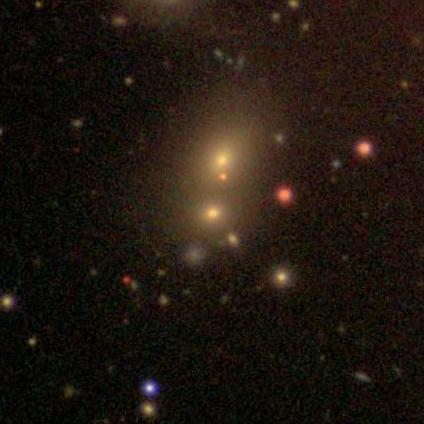

1.1 Smooth and rounded, no disk? smooth              0.695298
1.2 Smooth and rounded, no disk? features or disk    0.094301
1.3 Smooth and rounded, no disk? star or artifact    0.210401
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.094301
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.094301
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.094301
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.068062
5.3 Prominent center bulge? obvious                  0.026239
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.576915
6.2 Anything odd? no                                 0.423085
7.1 Is rounded? completely round                     0.534684
7.2 Is r

312449: REGULAR

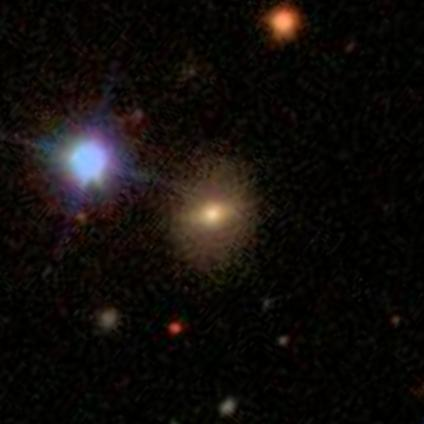

1.1 Smooth and rounded, no disk? smooth              0.375042
1.2 Smooth and rounded, no disk? features or disk    0.586179
1.3 Smooth and rounded, no disk? star or artifact    0.038780
2.1 Disk viewed edge on? yes                         0.087059
2.2 Disk viewed edge on? no                          0.499120
3.1 Bar feature through a center? yes                0.339217
3.2 Bar feature through a center? no                 0.159903
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.499120
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.074471
5.3 Prominent center bulge? obvious                  0.372402
5.4 Prominent center bulge? dominant                 0.052247
6.1 Anything odd? yes                                0.084609
6.2 Anything odd? no                                 0.915391
7.1 Is rounded? completely round                     0.114538
7.2 Is r

279430: ANOMALY

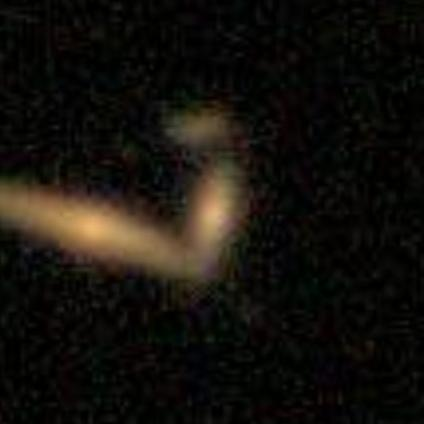

1.1 Smooth and rounded, no disk? smooth              0.180318
1.2 Smooth and rounded, no disk? features or disk    0.802412
1.3 Smooth and rounded, no disk? star or artifact    0.017270
2.1 Disk viewed edge on? yes                         0.172190
2.2 Disk viewed edge on? no                          0.630222
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.630222
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.630222
5.1 Prominent center bulge? no bulge                 0.162873
5.2 Prominent center bulge? noticable                0.286111
5.3 Prominent center bulge? obvious                  0.181237
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.947456
6.2 Anything odd? no                                 0.052544
7.1 Is rounded? completely round                     0.000000
7.2 Is r

745907: REGULAR

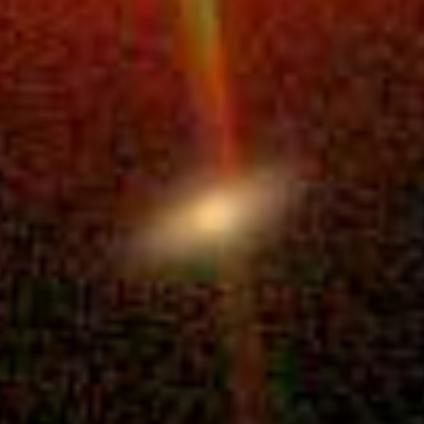

1.1 Smooth and rounded, no disk? smooth              0.416648
1.2 Smooth and rounded, no disk? features or disk    0.529294
1.3 Smooth and rounded, no disk? star or artifact    0.054058
2.1 Disk viewed edge on? yes                         0.317576
2.2 Disk viewed edge on? no                          0.211718
3.1 Bar feature through a center? yes                0.106570
3.2 Bar feature through a center? no                 0.105148
4.1 Spiral arm? yes                                  0.112994
4.2 Spiral arm? no                                   0.098723
5.1 Prominent center bulge? no bulge                 0.021475
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.033275
5.4 Prominent center bulge? dominant                 0.156967
6.1 Anything odd? yes                                0.590924
6.2 Anything odd? no                                 0.409076
7.1 Is rounded? completely round                     0.000000
7.2 Is r

989243: REGULAR

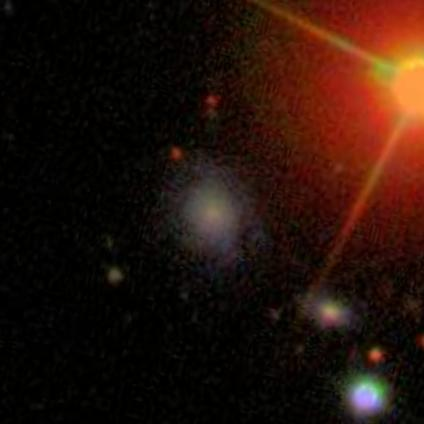

1.1 Smooth and rounded, no disk? smooth              0.416292
1.2 Smooth and rounded, no disk? features or disk    0.537965
1.3 Smooth and rounded, no disk? star or artifact    0.045743
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.537965
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.537965
4.1 Spiral arm? yes                                  0.249373
4.2 Spiral arm? no                                   0.288592
5.1 Prominent center bulge? no bulge                 0.088545
5.2 Prominent center bulge? noticable                0.449420
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.203236
6.2 Anything odd? no                                 0.796764
7.1 Is rounded? completely round                     0.212722
7.2 Is r

989449: ANOMALY

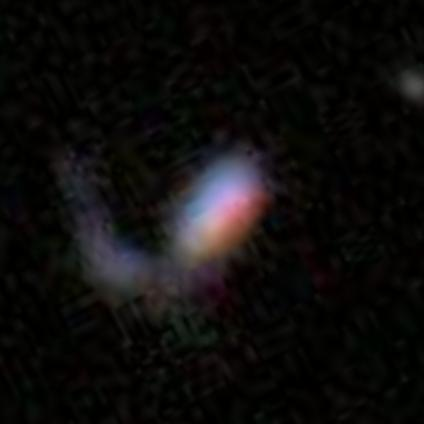

1.1 Smooth and rounded, no disk? smooth              0.195201
1.2 Smooth and rounded, no disk? features or disk    0.788185
1.3 Smooth and rounded, no disk? star or artifact    0.016614
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.788185
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.788185
4.1 Spiral arm? yes                                  0.516342
4.2 Spiral arm? no                                   0.271843
5.1 Prominent center bulge? no bulge                 0.380902
5.2 Prominent center bulge? noticable                0.054307
5.3 Prominent center bulge? obvious                  0.019164
5.4 Prominent center bulge? dominant                 0.333813
6.1 Anything odd? yes                                0.953131
6.2 Anything odd? no                                 0.046869
7.1 Is rounded? completely round                     0.009146
7.2 Is r

350779: REGULAR

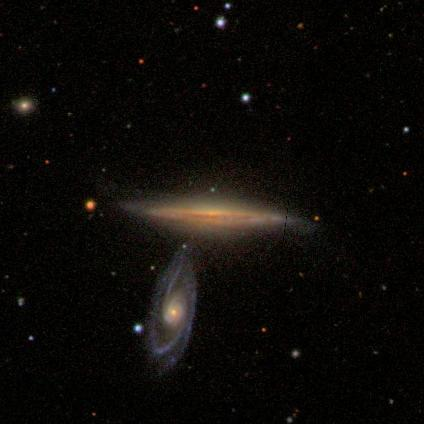

1.1 Smooth and rounded, no disk? smooth              0.210643
1.2 Smooth and rounded, no disk? features or disk    0.789357
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.747307
2.2 Disk viewed edge on? no                          0.042050
3.1 Bar feature through a center? yes                0.011991
3.2 Bar feature through a center? no                 0.030058
4.1 Spiral arm? yes                                  0.042050
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.009726
5.3 Prominent center bulge? obvious                  0.032324
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.556529
6.2 Anything odd? no                                 0.443471
7.1 Is rounded? completely round                     0.000000
7.2 Is r

426477: REGULAR

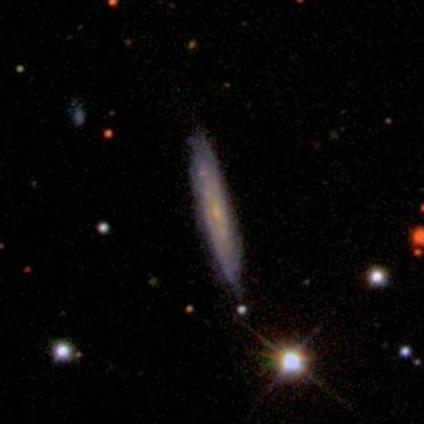

1.1 Smooth and rounded, no disk? smooth              0.147516
1.2 Smooth and rounded, no disk? features or disk    0.796379
1.3 Smooth and rounded, no disk? star or artifact    0.056105
2.1 Disk viewed edge on? yes                         0.535375
2.2 Disk viewed edge on? no                          0.261004
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.261004
4.1 Spiral arm? yes                                  0.125320
4.2 Spiral arm? no                                   0.135684
5.1 Prominent center bulge? no bulge                 0.051998
5.2 Prominent center bulge? noticable                0.209005
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.209588
6.2 Anything odd? no                                 0.790412
7.1 Is rounded? completely round                     0.000000
7.2 Is r

922772: REGULAR

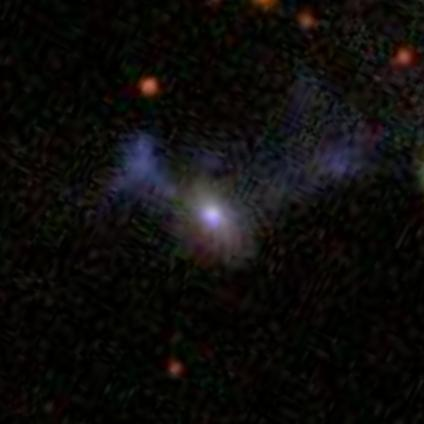

1.1 Smooth and rounded, no disk? smooth              0.329347
1.2 Smooth and rounded, no disk? features or disk    0.624244
1.3 Smooth and rounded, no disk? star or artifact    0.046409
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.624244
3.1 Bar feature through a center? yes                0.134556
3.2 Bar feature through a center? no                 0.489688
4.1 Spiral arm? yes                                  0.157372
4.2 Spiral arm? no                                   0.466872
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.258410
5.3 Prominent center bulge? obvious                  0.365834
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.887412
6.2 Anything odd? no                                 0.112588
7.1 Is rounded? completely round                     0.025213
7.2 Is r

724550: ANOMALY

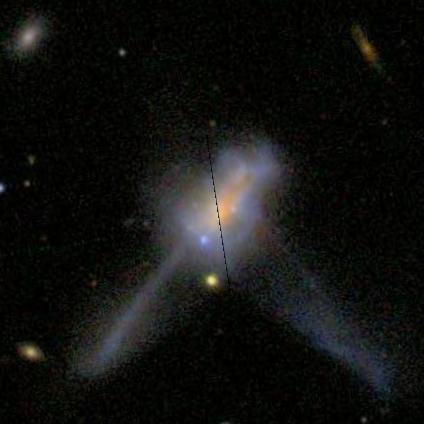

1.1 Smooth and rounded, no disk? smooth              0.180329
1.2 Smooth and rounded, no disk? features or disk    0.699757
1.3 Smooth and rounded, no disk? star or artifact    0.119914
2.1 Disk viewed edge on? yes                         0.161586
2.2 Disk viewed edge on? no                          0.538171
3.1 Bar feature through a center? yes                0.050041
3.2 Bar feature through a center? no                 0.488130
4.1 Spiral arm? yes                                  0.033569
4.2 Spiral arm? no                                   0.504602
5.1 Prominent center bulge? no bulge                 0.137541
5.2 Prominent center bulge? noticable                0.100762
5.3 Prominent center bulge? obvious                  0.158758
5.4 Prominent center bulge? dominant                 0.141110
6.1 Anything odd? yes                                0.968750
6.2 Anything odd? no                                 0.031250
7.1 Is rounded? completely round                     0.028184
7.2 Is r

742344: ANOMALY

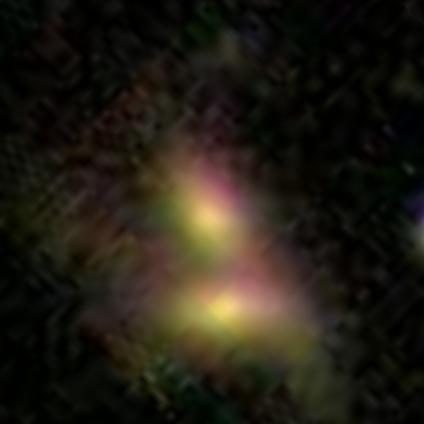

1.1 Smooth and rounded, no disk? smooth              0.309826
1.2 Smooth and rounded, no disk? features or disk    0.638852
1.3 Smooth and rounded, no disk? star or artifact    0.051322
2.1 Disk viewed edge on? yes                         0.015440
2.2 Disk viewed edge on? no                          0.623412
3.1 Bar feature through a center? yes                0.165942
3.2 Bar feature through a center? no                 0.457469
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.623412
5.1 Prominent center bulge? no bulge                 0.092146
5.2 Prominent center bulge? noticable                0.179467
5.3 Prominent center bulge? obvious                  0.104051
5.4 Prominent center bulge? dominant                 0.247748
6.1 Anything odd? yes                                0.929682
6.2 Anything odd? no                                 0.070318
7.1 Is rounded? completely round                     0.019145
7.2 Is r

216709: ANOMALY

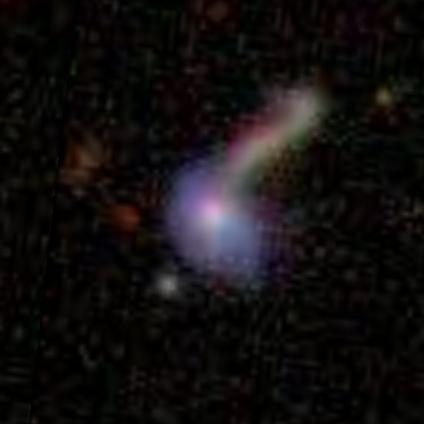

1.1 Smooth and rounded, no disk? smooth              0.096976
1.2 Smooth and rounded, no disk? features or disk    0.891566
1.3 Smooth and rounded, no disk? star or artifact    0.011458
2.1 Disk viewed edge on? yes                         0.020469
2.2 Disk viewed edge on? no                          0.871097
3.1 Bar feature through a center? yes                0.073237
3.2 Bar feature through a center? no                 0.797861
4.1 Spiral arm? yes                                  0.201343
4.2 Spiral arm? no                                   0.669755
5.1 Prominent center bulge? no bulge                 0.025335
5.2 Prominent center bulge? noticable                0.461782
5.3 Prominent center bulge? obvious                  0.332405
5.4 Prominent center bulge? dominant                 0.051576
6.1 Anything odd? yes                                0.957112
6.2 Anything odd? no                                 0.042888
7.1 Is rounded? completely round                     0.003921
7.2 Is r

301587: REGULAR

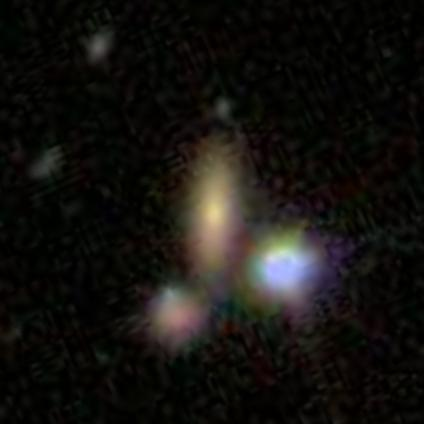

1.1 Smooth and rounded, no disk? smooth              0.502821
1.2 Smooth and rounded, no disk? features or disk    0.433946
1.3 Smooth and rounded, no disk? star or artifact    0.063233
2.1 Disk viewed edge on? yes                         0.260368
2.2 Disk viewed edge on? no                          0.173578
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.173578
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.173578
5.1 Prominent center bulge? no bulge                 0.042384
5.2 Prominent center bulge? noticable                0.104061
5.3 Prominent center bulge? obvious                  0.027133
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.796855
6.2 Anything odd? no                                 0.203145
7.1 Is rounded? completely round                     0.000000
7.2 Is r

391505: REGULAR

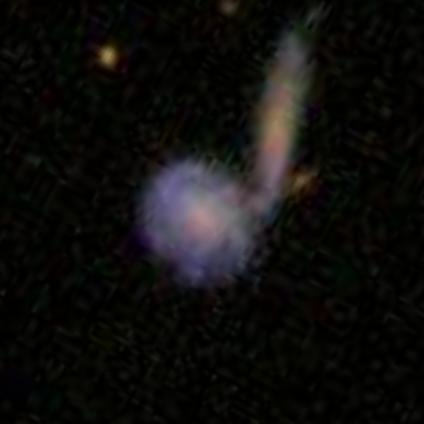

1.1 Smooth and rounded, no disk? smooth              0.034051
1.2 Smooth and rounded, no disk? features or disk    0.965949
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.030447
2.2 Disk viewed edge on? no                          0.935502
3.1 Bar feature through a center? yes                0.198261
3.2 Bar feature through a center? no                 0.737241
4.1 Spiral arm? yes                                  0.762320
4.2 Spiral arm? no                                   0.173182
5.1 Prominent center bulge? no bulge                 0.278370
5.2 Prominent center bulge? noticable                0.465860
5.3 Prominent center bulge? obvious                  0.109367
5.4 Prominent center bulge? dominant                 0.081906
6.1 Anything odd? yes                                0.828276
6.2 Anything odd? no                                 0.171724
7.1 Is rounded? completely round                     0.029996
7.2 Is r

826296: REGULAR

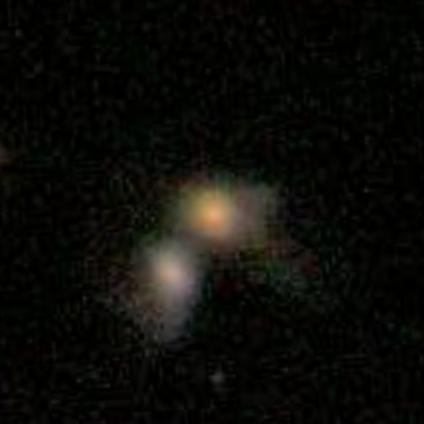

1.1 Smooth and rounded, no disk? smooth              0.199495
1.2 Smooth and rounded, no disk? features or disk    0.792707
1.3 Smooth and rounded, no disk? star or artifact    0.007798
2.1 Disk viewed edge on? yes                         0.027632
2.2 Disk viewed edge on? no                          0.765075
3.1 Bar feature through a center? yes                0.103997
3.2 Bar feature through a center? no                 0.661078
4.1 Spiral arm? yes                                  0.360390
4.2 Spiral arm? no                                   0.404685
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.238088
5.3 Prominent center bulge? obvious                  0.370928
5.4 Prominent center bulge? dominant                 0.156058
6.1 Anything odd? yes                                0.889918
6.2 Anything odd? no                                 0.110082
7.1 Is rounded? completely round                     0.119153
7.2 Is r

988328: REGULAR

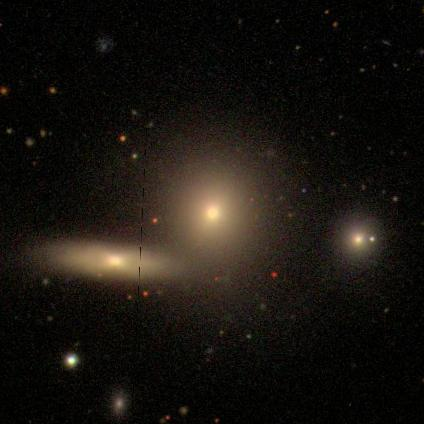

1.1 Smooth and rounded, no disk? smooth              0.8510
1.2 Smooth and rounded, no disk? features or disk    0.1060
1.3 Smooth and rounded, no disk? star or artifact    0.0430
2.1 Disk viewed edge on? yes                         0.0424
2.2 Disk viewed edge on? no                          0.0636
3.1 Bar feature through a center? yes                0.0000
3.2 Bar feature through a center? no                 0.0636
4.1 Spiral arm? yes                                  0.0000
4.2 Spiral arm? no                                   0.0636
5.1 Prominent center bulge? no bulge                 0.0000
5.2 Prominent center bulge? noticable                0.0212
5.3 Prominent center bulge? obvious                  0.0212
5.4 Prominent center bulge? dominant                 0.0212
6.1 Anything odd? yes                                0.4440
6.2 Anything odd? no                                 0.5560
7.1 Is rounded? completely round                     0.8510
7.2 Is rounded? in between              

676368: ANOMALY

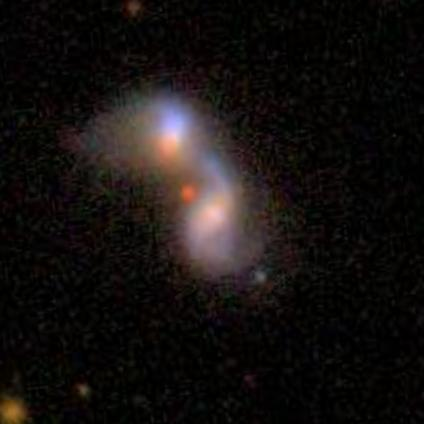

1.1 Smooth and rounded, no disk? smooth              0.016110
1.2 Smooth and rounded, no disk? features or disk    0.888288
1.3 Smooth and rounded, no disk? star or artifact    0.095602
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.888288
3.1 Bar feature through a center? yes                0.620647
3.2 Bar feature through a center? no                 0.267641
4.1 Spiral arm? yes                                  0.829879
4.2 Spiral arm? no                                   0.058409
5.1 Prominent center bulge? no bulge                 0.119044
5.2 Prominent center bulge? noticable                0.434498
5.3 Prominent center bulge? obvious                  0.144729
5.4 Prominent center bulge? dominant                 0.190017
6.1 Anything odd? yes                                0.905009
6.2 Anything odd? no                                 0.094991
7.1 Is rounded? completely round                     0.000000
7.2 Is r

402842: REGULAR

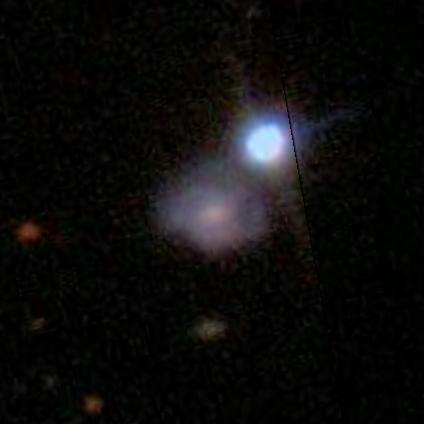

1.1 Smooth and rounded, no disk? smooth              0.090713
1.2 Smooth and rounded, no disk? features or disk    0.897103
1.3 Smooth and rounded, no disk? star or artifact    0.012184
2.1 Disk viewed edge on? yes                         0.027389
2.2 Disk viewed edge on? no                          0.869714
3.1 Bar feature through a center? yes                0.124726
3.2 Bar feature through a center? no                 0.744988
4.1 Spiral arm? yes                                  0.747290
4.2 Spiral arm? no                                   0.122423
5.1 Prominent center bulge? no bulge                 0.226873
5.2 Prominent center bulge? noticable                0.425640
5.3 Prominent center bulge? obvious                  0.217201
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.516191
6.2 Anything odd? no                                 0.483809
7.1 Is rounded? completely round                     0.012495
7.2 Is r

706822: REGULAR

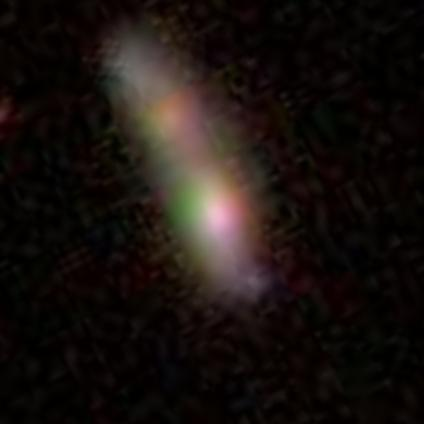

1.1 Smooth and rounded, no disk? smooth              0.615115
1.2 Smooth and rounded, no disk? features or disk    0.304959
1.3 Smooth and rounded, no disk? star or artifact    0.079926
2.1 Disk viewed edge on? yes                         0.159189
2.2 Disk viewed edge on? no                          0.145770
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.145770
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.145770
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.088762
5.4 Prominent center bulge? dominant                 0.057008
6.1 Anything odd? yes                                0.714638
6.2 Anything odd? no                                 0.285362
7.1 Is rounded? completely round                     0.005949
7.2 Is r

227890: REGULAR

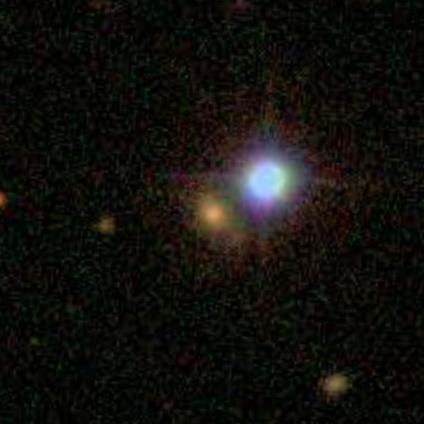

1.1 Smooth and rounded, no disk? smooth              0.46500
1.2 Smooth and rounded, no disk? features or disk    0.00000
1.3 Smooth and rounded, no disk? star or artifact    0.53500
2.1 Disk viewed edge on? yes                         0.00000
2.2 Disk viewed edge on? no                          0.00000
3.1 Bar feature through a center? yes                0.00000
3.2 Bar feature through a center? no                 0.00000
4.1 Spiral arm? yes                                  0.00000
4.2 Spiral arm? no                                   0.00000
5.1 Prominent center bulge? no bulge                 0.00000
5.2 Prominent center bulge? noticable                0.00000
5.3 Prominent center bulge? obvious                  0.00000
5.4 Prominent center bulge? dominant                 0.00000
6.1 Anything odd? yes                                0.25000
6.2 Anything odd? no                                 0.75000
7.1 Is rounded? completely round                     0.34875
7.2 Is rounded? in betwe

918098: ANOMALY

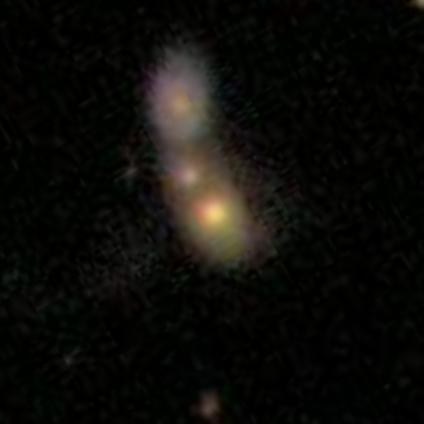

1.1 Smooth and rounded, no disk? smooth              0.419968
1.2 Smooth and rounded, no disk? features or disk    0.456079
1.3 Smooth and rounded, no disk? star or artifact    0.123953
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.456079
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.456079
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.456079
5.1 Prominent center bulge? no bulge                 0.038448
5.2 Prominent center bulge? noticable                0.325539
5.3 Prominent center bulge? obvious                  0.033633
5.4 Prominent center bulge? dominant                 0.058459
6.1 Anything odd? yes                                0.974608
6.2 Anything odd? no                                 0.025392
7.1 Is rounded? completely round                     0.050236
7.2 Is r

512456: REGULAR

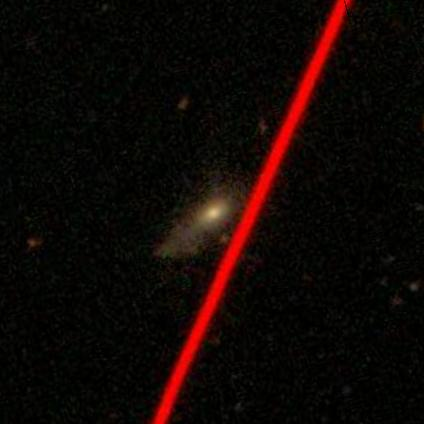

1.1 Smooth and rounded, no disk? smooth              0.443327
1.2 Smooth and rounded, no disk? features or disk    0.381172
1.3 Smooth and rounded, no disk? star or artifact    0.175501
2.1 Disk viewed edge on? yes                         0.318090
2.2 Disk viewed edge on? no                          0.063082
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.063082
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.063082
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.031464
5.3 Prominent center bulge? obvious                  0.031618
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.572753
6.2 Anything odd? no                                 0.427247
7.1 Is rounded? completely round                     0.024047
7.2 Is r

159874: ANOMALY

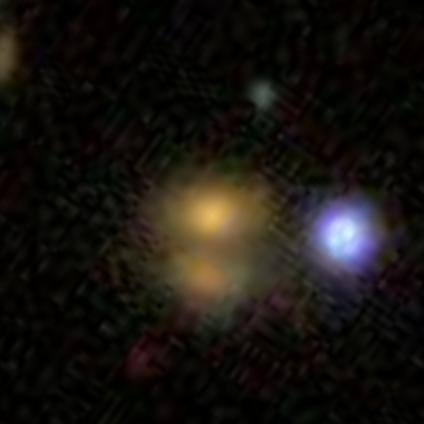

1.1 Smooth and rounded, no disk? smooth              0.380040
1.2 Smooth and rounded, no disk? features or disk    0.555206
1.3 Smooth and rounded, no disk? star or artifact    0.064754
2.1 Disk viewed edge on? yes                         0.055521
2.2 Disk viewed edge on? no                          0.499685
3.1 Bar feature through a center? yes                0.138607
3.2 Bar feature through a center? no                 0.361079
4.1 Spiral arm? yes                                  0.138577
4.2 Spiral arm? no                                   0.361108
5.1 Prominent center bulge? no bulge                 0.117548
5.2 Prominent center bulge? noticable                0.089647
5.3 Prominent center bulge? obvious                  0.031758
5.4 Prominent center bulge? dominant                 0.260732
6.1 Anything odd? yes                                0.922672
6.2 Anything odd? no                                 0.077328
7.1 Is rounded? completely round                     0.076208
7.2 Is r

853598: REGULAR

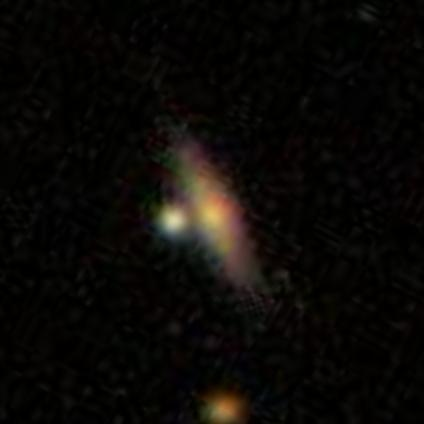

1.1 Smooth and rounded, no disk? smooth              0.113049
1.2 Smooth and rounded, no disk? features or disk    0.886951
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.753908
2.2 Disk viewed edge on? no                          0.133043
3.1 Bar feature through a center? yes                0.076949
3.2 Bar feature through a center? no                 0.056094
4.1 Spiral arm? yes                                  0.111089
4.2 Spiral arm? no                                   0.021954
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.112588
5.4 Prominent center bulge? dominant                 0.020455
6.1 Anything odd? yes                                0.614139
6.2 Anything odd? no                                 0.385861
7.1 Is rounded? completely round                     0.000000
7.2 Is r

497298: REGULAR

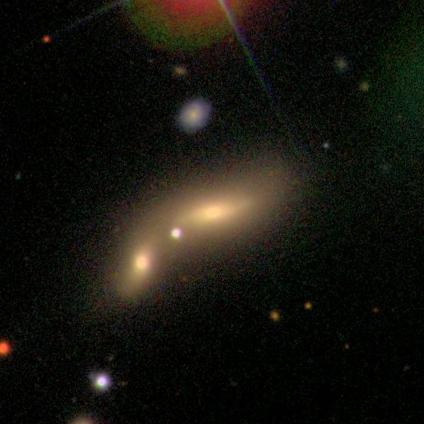

1.1 Smooth and rounded, no disk? smooth              0.531000
1.2 Smooth and rounded, no disk? features or disk    0.344000
1.3 Smooth and rounded, no disk? star or artifact    0.125000
2.1 Disk viewed edge on? yes                         0.156520
2.2 Disk viewed edge on? no                          0.187480
3.1 Bar feature through a center? yes                0.093740
3.2 Bar feature through a center? no                 0.093740
4.1 Spiral arm? yes                                  0.031309
4.2 Spiral arm? no                                   0.156171
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.125049
5.3 Prominent center bulge? obvious                  0.062431
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.786000
6.2 Anything odd? no                                 0.214000
7.1 Is rounded? completely round                     0.000000
7.2 Is r

213477: REGULAR

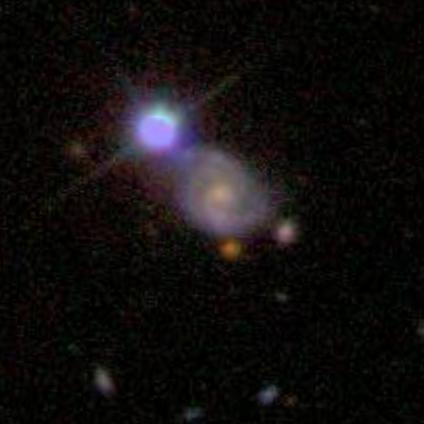

1.1 Smooth and rounded, no disk? smooth              0.010276
1.2 Smooth and rounded, no disk? features or disk    0.983943
1.3 Smooth and rounded, no disk? star or artifact    0.005781
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.983943
3.1 Bar feature through a center? yes                0.232886
3.2 Bar feature through a center? no                 0.751057
4.1 Spiral arm? yes                                  0.983943
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.060144
5.2 Prominent center bulge? noticable                0.665137
5.3 Prominent center bulge? obvious                  0.258662
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.300397
6.2 Anything odd? no                                 0.699603
7.1 Is rounded? completely round                     0.010276
7.2 Is r

112988: REGULAR

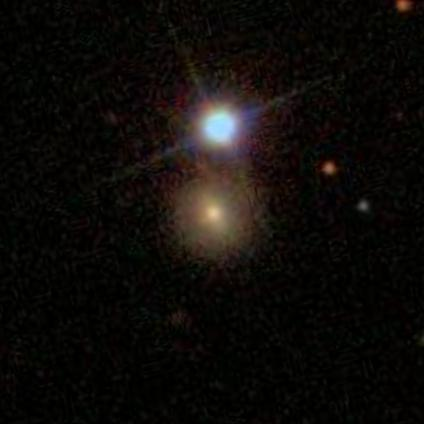

1.1 Smooth and rounded, no disk? smooth              0.433027
1.2 Smooth and rounded, no disk? features or disk    0.465960
1.3 Smooth and rounded, no disk? star or artifact    0.101013
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.465960
3.1 Bar feature through a center? yes                0.214546
3.2 Bar feature through a center? no                 0.251414
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.465960
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.028195
5.3 Prominent center bulge? obvious                  0.437765
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.161058
6.2 Anything odd? no                                 0.838942
7.1 Is rounded? completely round                     0.392804
7.2 Is r

319098: REGULAR

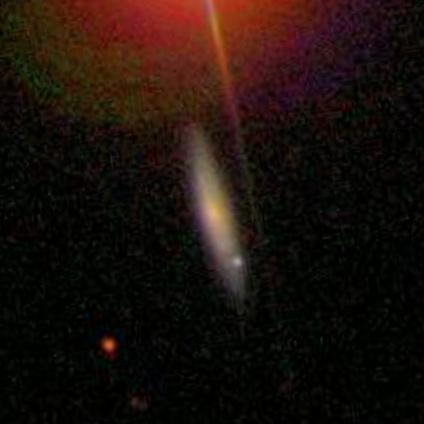

1.1 Smooth and rounded, no disk? smooth              0.215725
1.2 Smooth and rounded, no disk? features or disk    0.770577
1.3 Smooth and rounded, no disk? star or artifact    0.013698
2.1 Disk viewed edge on? yes                         0.460220
2.2 Disk viewed edge on? no                          0.310357
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.310357
4.1 Spiral arm? yes                                  0.157385
4.2 Spiral arm? no                                   0.152971
5.1 Prominent center bulge? no bulge                 0.032882
5.2 Prominent center bulge? noticable                0.119781
5.3 Prominent center bulge? obvious                  0.157694
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.460275
6.2 Anything odd? no                                 0.539725
7.1 Is rounded? completely round                     0.000000
7.2 Is r

340886: ANOMALY

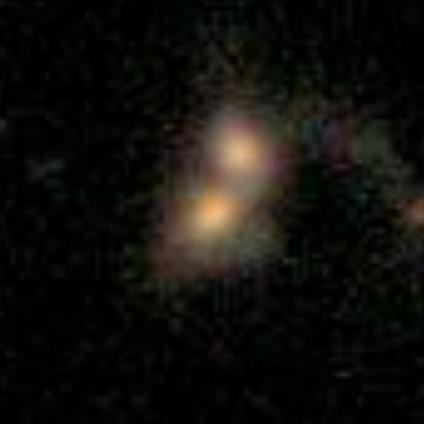

1.1 Smooth and rounded, no disk? smooth              0.134380
1.2 Smooth and rounded, no disk? features or disk    0.824152
1.3 Smooth and rounded, no disk? star or artifact    0.041467
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.824152
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.824152
4.1 Spiral arm? yes                                  0.145884
4.2 Spiral arm? no                                   0.678268
5.1 Prominent center bulge? no bulge                 0.078771
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.121323
5.4 Prominent center bulge? dominant                 0.624058
6.1 Anything odd? yes                                0.987920
6.2 Anything odd? no                                 0.012080
7.1 Is rounded? completely round                     0.050102
7.2 Is r

365000: REGULAR

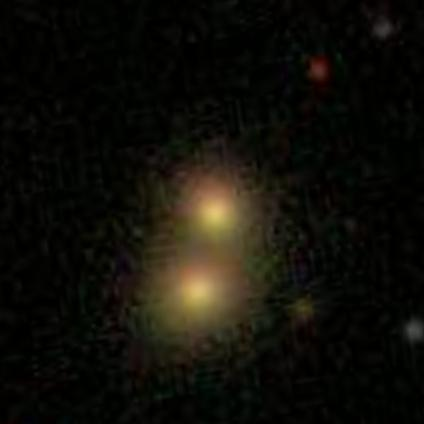

1.1 Smooth and rounded, no disk? smooth              0.439474
1.2 Smooth and rounded, no disk? features or disk    0.493201
1.3 Smooth and rounded, no disk? star or artifact    0.067325
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.493201
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.493201
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.493201
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.456946
5.4 Prominent center bulge? dominant                 0.036255
6.1 Anything odd? yes                                0.797543
6.2 Anything odd? no                                 0.202457
7.1 Is rounded? completely round                     0.323962
7.2 Is r

637115: ANOMALY

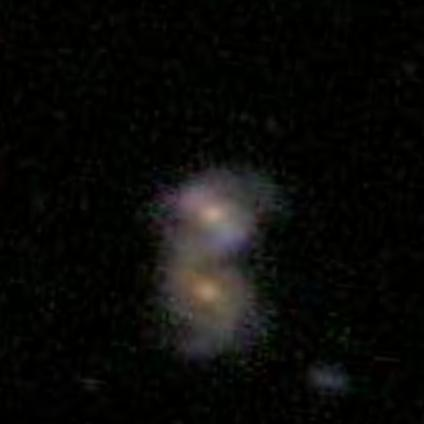

1.1 Smooth and rounded, no disk? smooth              0.036106
1.2 Smooth and rounded, no disk? features or disk    0.963894
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.963894
3.1 Bar feature through a center? yes                0.424895
3.2 Bar feature through a center? no                 0.538999
4.1 Spiral arm? yes                                  0.839540
4.2 Spiral arm? no                                   0.124354
5.1 Prominent center bulge? no bulge                 0.016889
5.2 Prominent center bulge? noticable                0.642555
5.3 Prominent center bulge? obvious                  0.304450
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                1.000000
6.2 Anything odd? no                                 0.000000
7.1 Is rounded? completely round                     0.006014
7.2 Is r

465317: ANOMALY

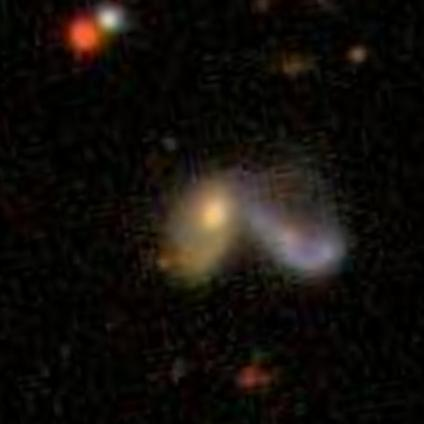

1.1 Smooth and rounded, no disk? smooth              0.187099
1.2 Smooth and rounded, no disk? features or disk    0.803696
1.3 Smooth and rounded, no disk? star or artifact    0.009205
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.803696
3.1 Bar feature through a center? yes                0.152431
3.2 Bar feature through a center? no                 0.651265
4.1 Spiral arm? yes                                  0.581582
4.2 Spiral arm? no                                   0.222114
5.1 Prominent center bulge? no bulge                 0.047220
5.2 Prominent center bulge? noticable                0.110619
5.3 Prominent center bulge? obvious                  0.571967
5.4 Prominent center bulge? dominant                 0.073890
6.1 Anything odd? yes                                0.925177
6.2 Anything odd? no                                 0.074823
7.1 Is rounded? completely round                     0.000000
7.2 Is r

541355: REGULAR

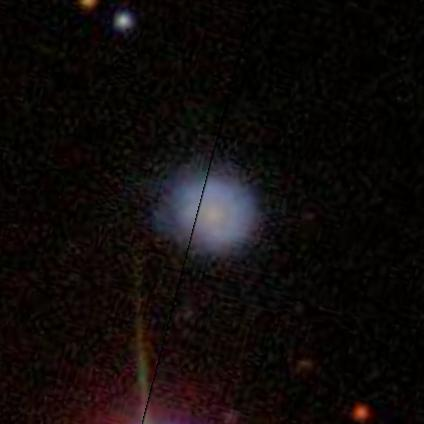

1.1 Smooth and rounded, no disk? smooth              0.289971
1.2 Smooth and rounded, no disk? features or disk    0.668399
1.3 Smooth and rounded, no disk? star or artifact    0.041630
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.668399
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.668399
4.1 Spiral arm? yes                                  0.470583
4.2 Spiral arm? no                                   0.197816
5.1 Prominent center bulge? no bulge                 0.145568
5.2 Prominent center bulge? noticable                0.522831
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.492697
6.2 Anything odd? no                                 0.507303
7.1 Is rounded? completely round                     0.209689
7.2 Is r

428697: REGULAR

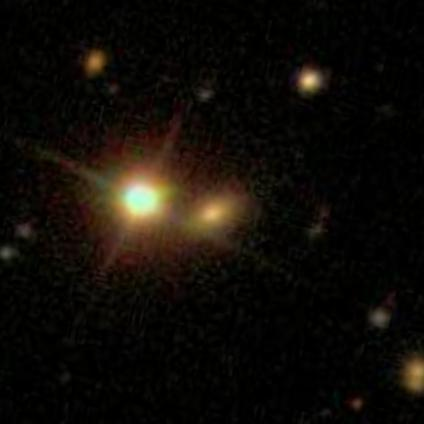

1.1 Smooth and rounded, no disk? smooth              0.383617
1.2 Smooth and rounded, no disk? features or disk    0.287934
1.3 Smooth and rounded, no disk? star or artifact    0.328449
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.287934
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.287934
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.287934
5.1 Prominent center bulge? no bulge                 0.055594
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.103069
5.4 Prominent center bulge? dominant                 0.129271
6.1 Anything odd? yes                                0.396781
6.2 Anything odd? no                                 0.603219
7.1 Is rounded? completely round                     0.071418
7.2 Is r

133435: REGULAR

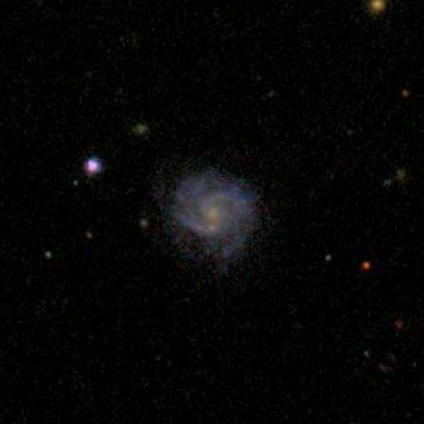

1.1 Smooth and rounded, no disk? smooth              0.000000
1.2 Smooth and rounded, no disk? features or disk    1.000000
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          1.000000
3.1 Bar feature through a center? yes                0.100000
3.2 Bar feature through a center? no                 0.900000
4.1 Spiral arm? yes                                  1.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.220000
5.2 Prominent center bulge? noticable                0.700000
5.3 Prominent center bulge? obvious                  0.080000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.152738
6.2 Anything odd? no                                 0.847262
7.1 Is rounded? completely round                     0.000000
7.2 Is r

684969: REGULAR

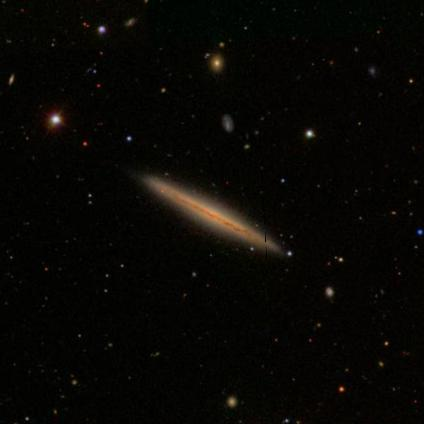

1.1 Smooth and rounded, no disk? smooth              0.282582
1.2 Smooth and rounded, no disk? features or disk    0.717418
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.684092
2.2 Disk viewed edge on? no                          0.033326
3.1 Bar feature through a center? yes                0.015855
3.2 Bar feature through a center? no                 0.017470
4.1 Spiral arm? yes                                  0.014289
4.2 Spiral arm? no                                   0.019036
5.1 Prominent center bulge? no bulge                 0.033326
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.489197
6.2 Anything odd? no                                 0.510803
7.1 Is rounded? completely round                     0.000000
7.2 Is r

876639: REGULAR

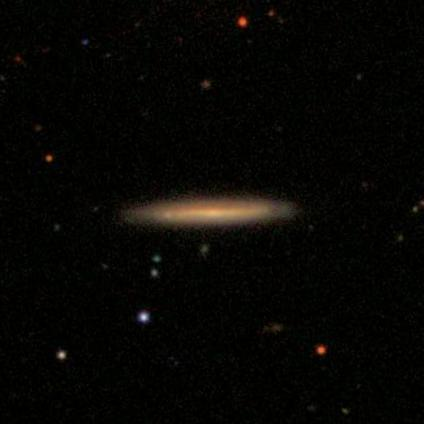

1.1 Smooth and rounded, no disk? smooth              0.447245
1.2 Smooth and rounded, no disk? features or disk    0.548191
1.3 Smooth and rounded, no disk? star or artifact    0.004564
2.1 Disk viewed edge on? yes                         0.503066
2.2 Disk viewed edge on? no                          0.045125
3.1 Bar feature through a center? yes                0.045125
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.045125
5.1 Prominent center bulge? no bulge                 0.045125
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.043849
6.2 Anything odd? no                                 0.956151
7.1 Is rounded? completely round                     0.000000
7.2 Is r

267604: ANOMALY

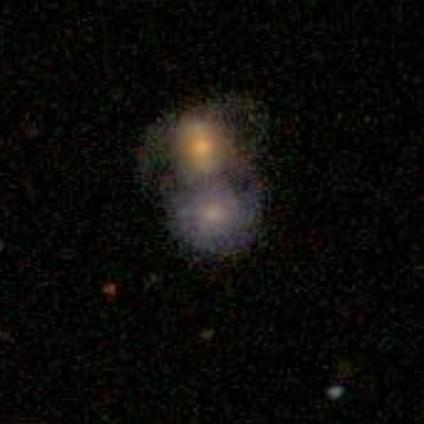

1.1 Smooth and rounded, no disk? smooth              0.187082
1.2 Smooth and rounded, no disk? features or disk    0.772359
1.3 Smooth and rounded, no disk? star or artifact    0.040559
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.772359
3.1 Bar feature through a center? yes                0.197081
3.2 Bar feature through a center? no                 0.575278
4.1 Spiral arm? yes                                  0.130655
4.2 Spiral arm? no                                   0.641704
5.1 Prominent center bulge? no bulge                 0.070691
5.2 Prominent center bulge? noticable                0.346939
5.3 Prominent center bulge? obvious                  0.354729
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.918942
6.2 Anything odd? no                                 0.081058
7.1 Is rounded? completely round                     0.146965
7.2 Is r

815707: ANOMALY

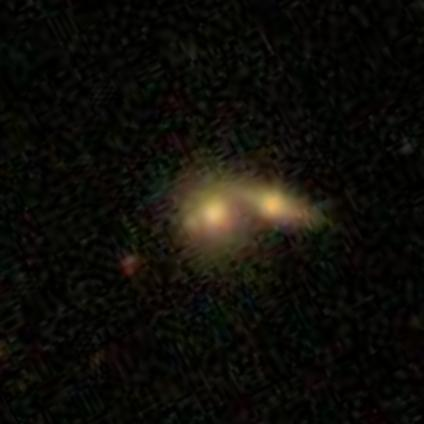

1.1 Smooth and rounded, no disk? smooth              0.276522
1.2 Smooth and rounded, no disk? features or disk    0.670896
1.3 Smooth and rounded, no disk? star or artifact    0.052582
2.1 Disk viewed edge on? yes                         0.183155
2.2 Disk viewed edge on? no                          0.487741
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.487741
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.487741
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.057093
5.3 Prominent center bulge? obvious                  0.298904
5.4 Prominent center bulge? dominant                 0.131744
6.1 Anything odd? yes                                0.912614
6.2 Anything odd? no                                 0.087386
7.1 Is rounded? completely round                     0.168733
7.2 Is r

169821: REGULAR

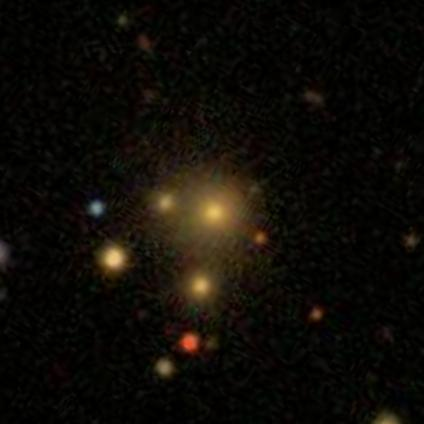

1.1 Smooth and rounded, no disk? smooth              0.665126
1.2 Smooth and rounded, no disk? features or disk    0.232548
1.3 Smooth and rounded, no disk? star or artifact    0.102326
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.232548
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.232548
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.232548
5.1 Prominent center bulge? no bulge                 0.124199
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.053052
5.4 Prominent center bulge? dominant                 0.055297
6.1 Anything odd? yes                                0.515405
6.2 Anything odd? no                                 0.484595
7.1 Is rounded? completely round                     0.630306
7.2 Is r

966379: REGULAR

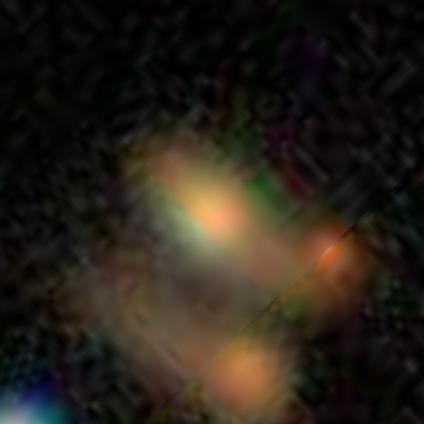

1.1 Smooth and rounded, no disk? smooth              0.668336
1.2 Smooth and rounded, no disk? features or disk    0.141399
1.3 Smooth and rounded, no disk? star or artifact    0.190265
2.1 Disk viewed edge on? yes                         0.023614
2.2 Disk viewed edge on? no                          0.117785
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.117785
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.117785
5.1 Prominent center bulge? no bulge                 0.047114
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.023557
5.4 Prominent center bulge? dominant                 0.047114
6.1 Anything odd? yes                                0.859315
6.2 Anything odd? no                                 0.140685
7.1 Is rounded? completely round                     0.039094
7.2 Is r

733176: REGULAR

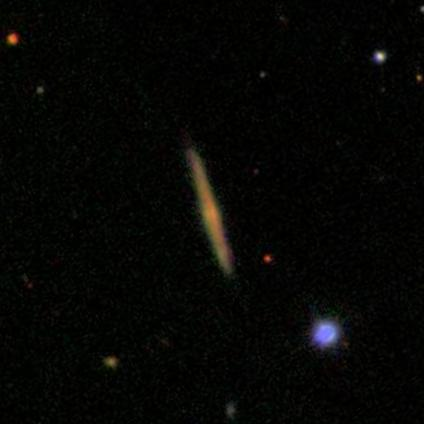

1.1 Smooth and rounded, no disk? smooth              0.089580
1.2 Smooth and rounded, no disk? features or disk    0.910420
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.910420
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.060635
6.2 Anything odd? no                                 0.939365
7.1 Is rounded? completely round                     0.000000
7.2 Is r

370862: REGULAR

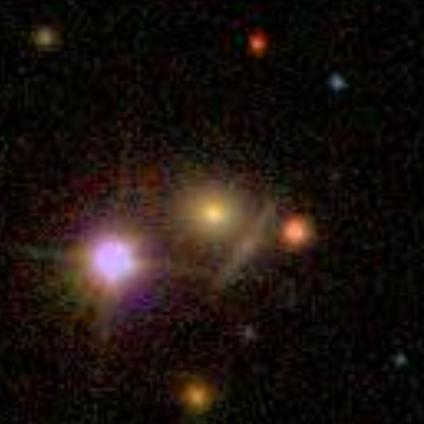

1.1 Smooth and rounded, no disk? smooth              0.489417
1.2 Smooth and rounded, no disk? features or disk    0.323210
1.3 Smooth and rounded, no disk? star or artifact    0.187373
2.1 Disk viewed edge on? yes                         0.087267
2.2 Disk viewed edge on? no                          0.235943
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.235943
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.235943
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.148305
5.4 Prominent center bulge? dominant                 0.087639
6.1 Anything odd? yes                                0.566670
6.2 Anything odd? no                                 0.433330
7.1 Is rounded? completely round                     0.293108
7.2 Is r

935149: REGULAR

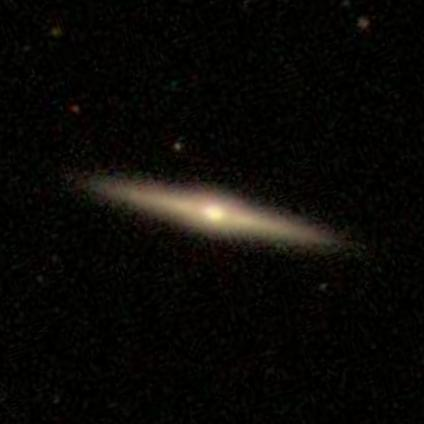

1.1 Smooth and rounded, no disk? smooth              0.074813
1.2 Smooth and rounded, no disk? features or disk    0.925187
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.901132
2.2 Disk viewed edge on? no                          0.024055
3.1 Bar feature through a center? yes                0.024055
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.024055
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.024055
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.024580
6.2 Anything odd? no                                 0.975420
7.1 Is rounded? completely round                     0.000000
7.2 Is r

445423: REGULAR

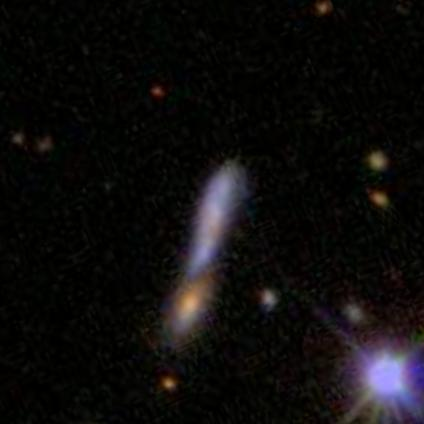

1.1 Smooth and rounded, no disk? smooth              0.213349
1.2 Smooth and rounded, no disk? features or disk    0.751842
1.3 Smooth and rounded, no disk? star or artifact    0.034809
2.1 Disk viewed edge on? yes                         0.504242
2.2 Disk viewed edge on? no                          0.247600
3.1 Bar feature through a center? yes                0.089735
3.2 Bar feature through a center? no                 0.157865
4.1 Spiral arm? yes                                  0.033730
4.2 Spiral arm? no                                   0.213870
5.1 Prominent center bulge? no bulge                 0.192253
5.2 Prominent center bulge? noticable                0.055347
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.883429
6.2 Anything odd? no                                 0.116571
7.1 Is rounded? completely round                     0.000000
7.2 Is r

939934: REGULAR

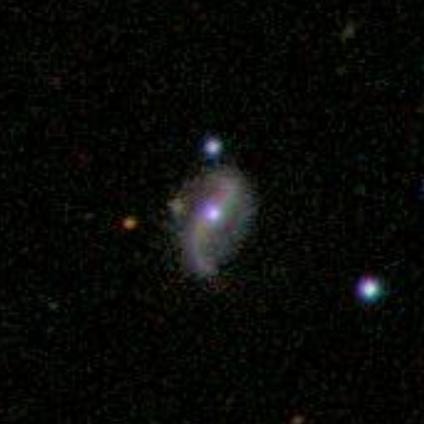

1.1 Smooth and rounded, no disk? smooth              0.007435
1.2 Smooth and rounded, no disk? features or disk    0.987836
1.3 Smooth and rounded, no disk? star or artifact    0.004728
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.987836
3.1 Bar feature through a center? yes                0.381038
3.2 Bar feature through a center? no                 0.606798
4.1 Spiral arm? yes                                  0.987836
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.346217
5.3 Prominent center bulge? obvious                  0.641619
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.356756
6.2 Anything odd? no                                 0.643244
7.1 Is rounded? completely round                     0.000000
7.2 Is r

688229: REGULAR

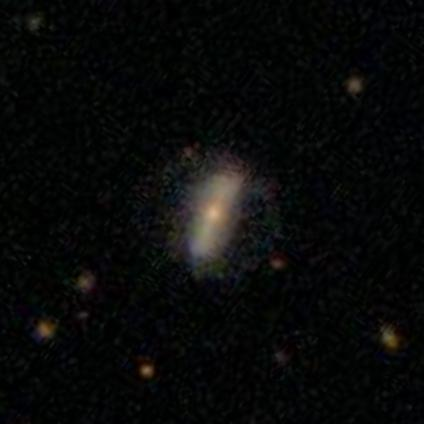

1.1 Smooth and rounded, no disk? smooth              0.091783
1.2 Smooth and rounded, no disk? features or disk    0.894206
1.3 Smooth and rounded, no disk? star or artifact    0.014011
2.1 Disk viewed edge on? yes                         0.156162
2.2 Disk viewed edge on? no                          0.738044
3.1 Bar feature through a center? yes                0.594533
3.2 Bar feature through a center? no                 0.143511
4.1 Spiral arm? yes                                  0.170833
4.2 Spiral arm? no                                   0.567210
5.1 Prominent center bulge? no bulge                 0.025457
5.2 Prominent center bulge? noticable                0.278267
5.3 Prominent center bulge? obvious                  0.162802
5.4 Prominent center bulge? dominant                 0.271518
6.1 Anything odd? yes                                0.346628
6.2 Anything odd? no                                 0.653372
7.1 Is rounded? completely round                     0.000000
7.2 Is r

712019: REGULAR

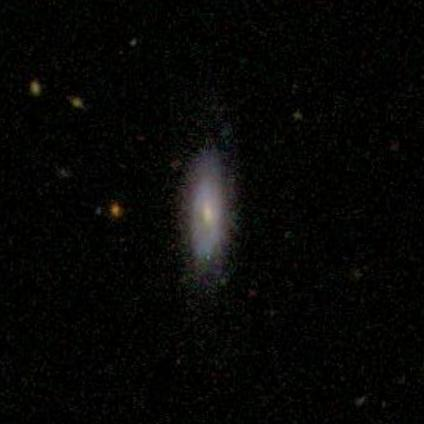

1.1 Smooth and rounded, no disk? smooth              0.260242
1.2 Smooth and rounded, no disk? features or disk    0.738331
1.3 Smooth and rounded, no disk? star or artifact    0.001427
2.1 Disk viewed edge on? yes                         0.184494
2.2 Disk viewed edge on? no                          0.553837
3.1 Bar feature through a center? yes                0.097538
3.2 Bar feature through a center? no                 0.456298
4.1 Spiral arm? yes                                  0.341806
4.2 Spiral arm? no                                   0.212031
5.1 Prominent center bulge? no bulge                 0.024769
5.2 Prominent center bulge? noticable                0.356326
5.3 Prominent center bulge? obvious                  0.113000
5.4 Prominent center bulge? dominant                 0.059742
6.1 Anything odd? yes                                0.064691
6.2 Anything odd? no                                 0.935309
7.1 Is rounded? completely round                     0.000000
7.2 Is r

180133: REGULAR

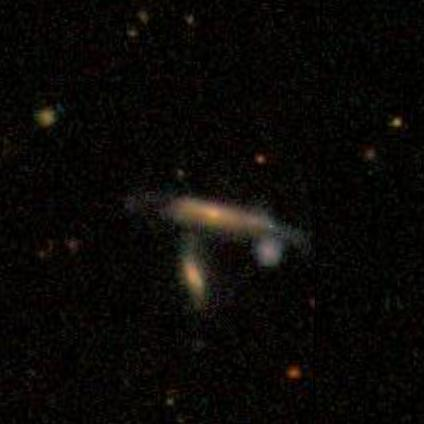

1.1 Smooth and rounded, no disk? smooth              0.106838
1.2 Smooth and rounded, no disk? features or disk    0.893162
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.839701
2.2 Disk viewed edge on? no                          0.053461
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.053461
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.053461
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.053461
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.761058
6.2 Anything odd? no                                 0.238942
7.1 Is rounded? completely round                     0.000000
7.2 Is r

172034: REGULAR

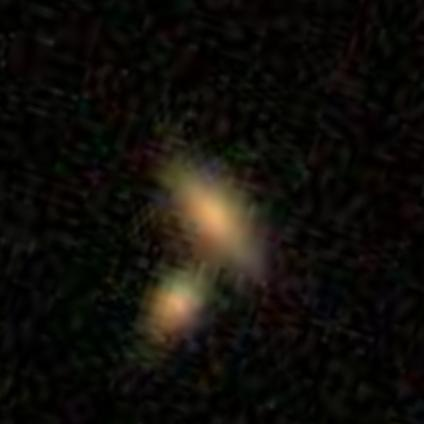

1.1 Smooth and rounded, no disk? smooth              0.410401
1.2 Smooth and rounded, no disk? features or disk    0.589599
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.059358
2.2 Disk viewed edge on? no                          0.530241
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.530241
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.530241
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.377763
5.3 Prominent center bulge? obvious                  0.152478
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.612987
6.2 Anything odd? no                                 0.387013
7.1 Is rounded? completely round                     0.000000
7.2 Is r

895300: REGULAR

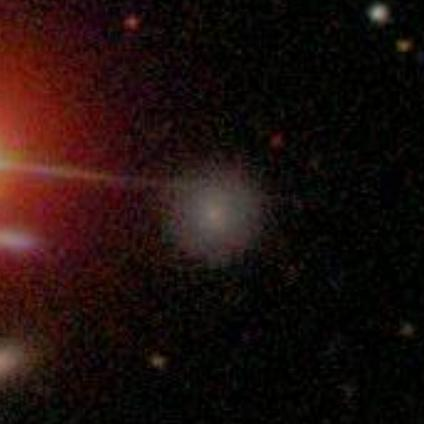

1.1 Smooth and rounded, no disk? smooth              0.686455
1.2 Smooth and rounded, no disk? features or disk    0.313545
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.313545
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.313545
4.1 Spiral arm? yes                                  0.228432
4.2 Spiral arm? no                                   0.085113
5.1 Prominent center bulge? no bulge                 0.094925
5.2 Prominent center bulge? noticable                0.218620
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.035449
6.2 Anything odd? no                                 0.964551
7.1 Is rounded? completely round                     0.644915
7.2 Is r

731957: REGULAR

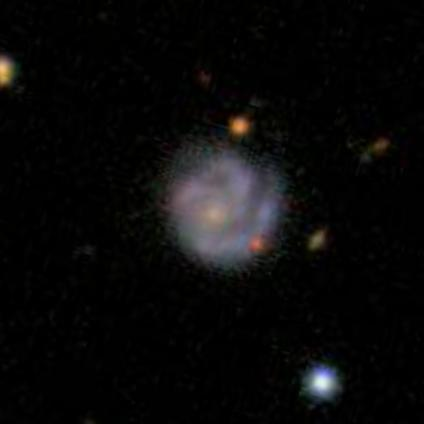

1.1 Smooth and rounded, no disk? smooth              0.041724
1.2 Smooth and rounded, no disk? features or disk    0.937021
1.3 Smooth and rounded, no disk? star or artifact    0.021256
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.937021
3.1 Bar feature through a center? yes                0.106962
3.2 Bar feature through a center? no                 0.830059
4.1 Spiral arm? yes                                  0.937021
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.182627
5.2 Prominent center bulge? noticable                0.619380
5.3 Prominent center bulge? obvious                  0.135013
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.200789
6.2 Anything odd? no                                 0.799211
7.1 Is rounded? completely round                     0.041724
7.2 Is r

185768: REGULAR

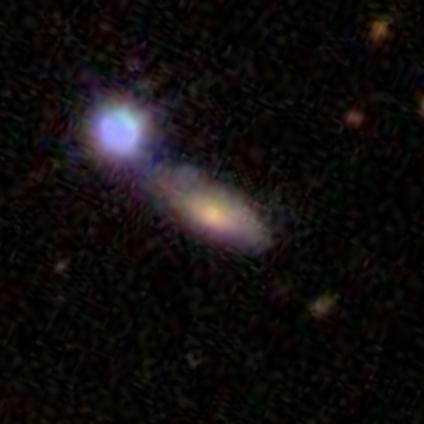

1.1 Smooth and rounded, no disk? smooth              0.326785
1.2 Smooth and rounded, no disk? features or disk    0.660770
1.3 Smooth and rounded, no disk? star or artifact    0.012445
2.1 Disk viewed edge on? yes                         0.132739
2.2 Disk viewed edge on? no                          0.528031
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.528031
4.1 Spiral arm? yes                                  0.139976
4.2 Spiral arm? no                                   0.388055
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.161733
5.3 Prominent center bulge? obvious                  0.316471
5.4 Prominent center bulge? dominant                 0.049827
6.1 Anything odd? yes                                0.563227
6.2 Anything odd? no                                 0.436773
7.1 Is rounded? completely round                     0.000000
7.2 Is r

704686: REGULAR

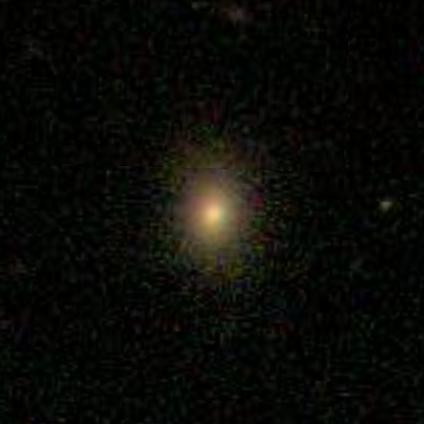

1.1 Smooth and rounded, no disk? smooth              0.632747
1.2 Smooth and rounded, no disk? features or disk    0.366046
1.3 Smooth and rounded, no disk? star or artifact    0.001207
2.1 Disk viewed edge on? yes                         0.049086
2.2 Disk viewed edge on? no                          0.316960
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.316960
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.316960
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.211239
5.3 Prominent center bulge? obvious                  0.105721
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.070859
6.2 Anything odd? no                                 0.929141
7.1 Is rounded? completely round                     0.392769
7.2 Is r

573686: REGULAR

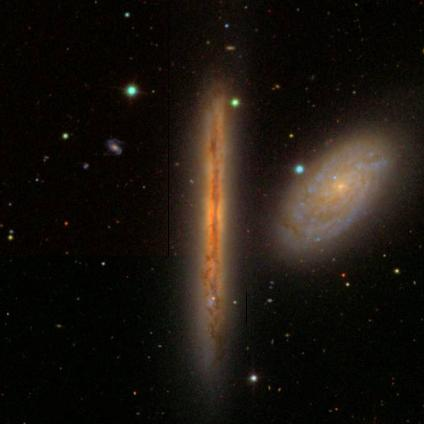

1.1 Smooth and rounded, no disk? smooth              0.232997
1.2 Smooth and rounded, no disk? features or disk    0.686080
1.3 Smooth and rounded, no disk? star or artifact    0.080922
2.1 Disk viewed edge on? yes                         0.667556
2.2 Disk viewed edge on? no                          0.018524
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.018524
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.018524
5.1 Prominent center bulge? no bulge                 0.018524
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.478111
6.2 Anything odd? no                                 0.521889
7.1 Is rounded? completely round                     0.000000
7.2 Is r

738062: REGULAR

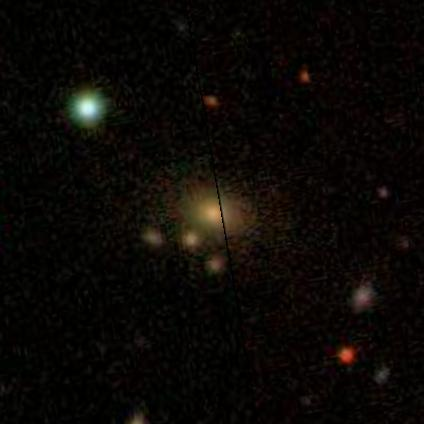

1.1 Smooth and rounded, no disk? smooth              0.585611
1.2 Smooth and rounded, no disk? features or disk    0.414389
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.414389
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.414389
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.414389
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.186362
5.3 Prominent center bulge? obvious                  0.228027
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.420024
6.2 Anything odd? no                                 0.579976
7.1 Is rounded? completely round                     0.229881
7.2 Is r

720777: REGULAR

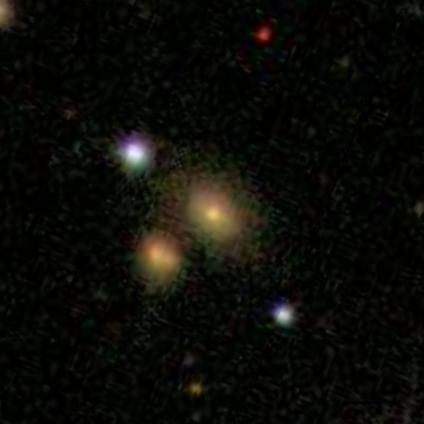

1.1 Smooth and rounded, no disk? smooth              0.303184
1.2 Smooth and rounded, no disk? features or disk    0.679398
1.3 Smooth and rounded, no disk? star or artifact    0.017419
2.1 Disk viewed edge on? yes                         0.059552
2.2 Disk viewed edge on? no                          0.619846
3.1 Bar feature through a center? yes                0.320643
3.2 Bar feature through a center? no                 0.299203
4.1 Spiral arm? yes                                  0.131170
4.2 Spiral arm? no                                   0.488676
5.1 Prominent center bulge? no bulge                 0.061088
5.2 Prominent center bulge? noticable                0.389819
5.3 Prominent center bulge? obvious                  0.127032
5.4 Prominent center bulge? dominant                 0.041907
6.1 Anything odd? yes                                0.558857
6.2 Anything odd? no                                 0.441143
7.1 Is rounded? completely round                     0.032474
7.2 Is r

669248: REGULAR

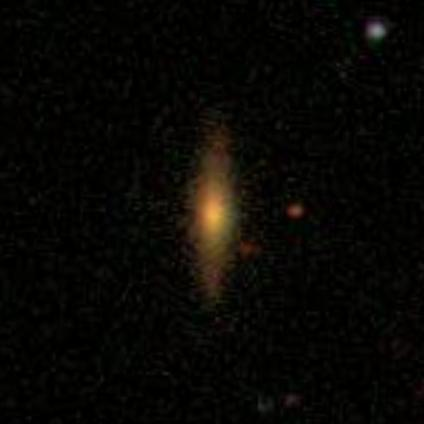

1.1 Smooth and rounded, no disk? smooth              0.202257
1.2 Smooth and rounded, no disk? features or disk    0.781000
1.3 Smooth and rounded, no disk? star or artifact    0.016742
2.1 Disk viewed edge on? yes                         0.781000
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.040252
6.2 Anything odd? no                                 0.959748
7.1 Is rounded? completely round                     0.000000
7.2 Is r

251840: REGULAR

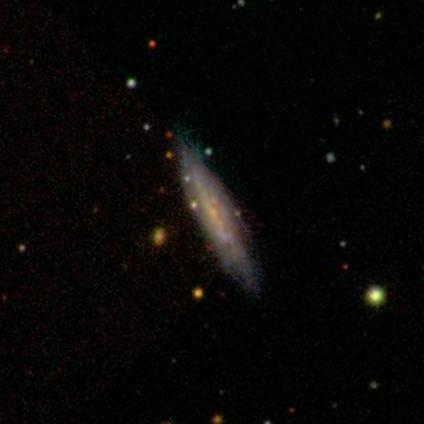

1.1 Smooth and rounded, no disk? smooth              0.208598
1.2 Smooth and rounded, no disk? features or disk    0.791402
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.367886
2.2 Disk viewed edge on? no                          0.423516
3.1 Bar feature through a center? yes                0.059365
3.2 Bar feature through a center? no                 0.364151
4.1 Spiral arm? yes                                  0.021668
4.2 Spiral arm? no                                   0.401848
5.1 Prominent center bulge? no bulge                 0.254025
5.2 Prominent center bulge? noticable                0.169491
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.294160
6.2 Anything odd? no                                 0.705840
7.1 Is rounded? completely round                     0.000000
7.2 Is r

174852: REGULAR

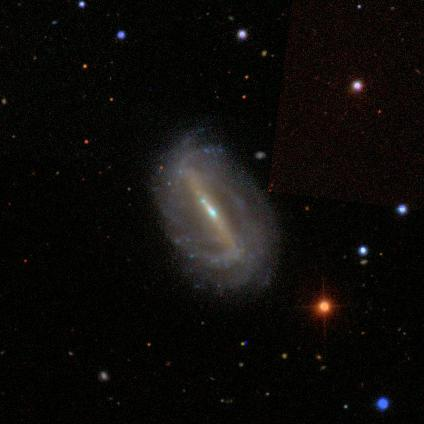

1.1 Smooth and rounded, no disk? smooth              0.052430
1.2 Smooth and rounded, no disk? features or disk    0.947570
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.036955
2.2 Disk viewed edge on? no                          0.910615
3.1 Bar feature through a center? yes                0.910615
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.910615
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.130218
5.2 Prominent center bulge? noticable                0.408866
5.3 Prominent center bulge? obvious                  0.353319
5.4 Prominent center bulge? dominant                 0.018212
6.1 Anything odd? yes                                0.202383
6.2 Anything odd? no                                 0.797617
7.1 Is rounded? completely round                     0.000000
7.2 Is r

166323: REGULAR

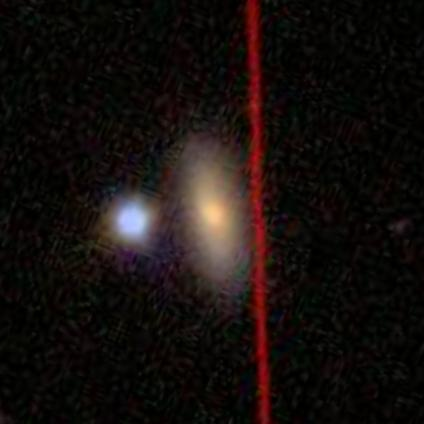

1.1 Smooth and rounded, no disk? smooth              0.737656
1.2 Smooth and rounded, no disk? features or disk    0.202211
1.3 Smooth and rounded, no disk? star or artifact    0.060133
2.1 Disk viewed edge on? yes                         0.094499
2.2 Disk viewed edge on? no                          0.107712
3.1 Bar feature through a center? yes                0.107712
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.107712
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.107712
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.439950
6.2 Anything odd? no                                 0.560050
7.1 Is rounded? completely round                     0.030861
7.2 Is r

734971: REGULAR

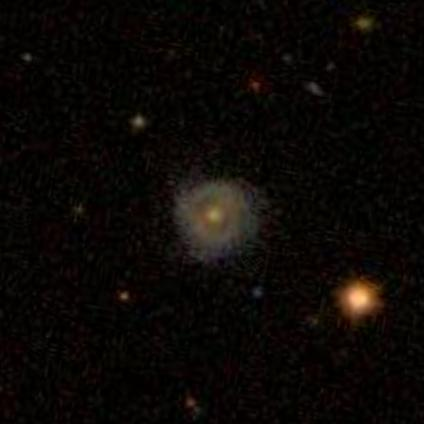

1.1 Smooth and rounded, no disk? smooth              0.394000
1.2 Smooth and rounded, no disk? features or disk    0.545000
1.3 Smooth and rounded, no disk? star or artifact    0.061000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.545000
3.1 Bar feature through a center? yes                0.060495
3.2 Bar feature through a center? no                 0.484505
4.1 Spiral arm? yes                                  0.151510
4.2 Spiral arm? no                                   0.393490
5.1 Prominent center bulge? no bulge                 0.030520
5.2 Prominent center bulge? noticable                0.241980
5.3 Prominent center bulge? obvious                  0.181485
5.4 Prominent center bulge? dominant                 0.091015
6.1 Anything odd? yes                                0.710000
6.2 Anything odd? no                                 0.290000
7.1 Is rounded? completely round                     0.394000
7.2 Is r

In [94]:
trace_galaxy_zoo_2(cmp_61_90.pineforest_session)

Running Isolation Forest
Running AAD Isolation Forest
Running Pine Forest
CPU times: user 15min 37s, sys: 11.5 s, total: 15min 48s
Wall time: 6min 57s


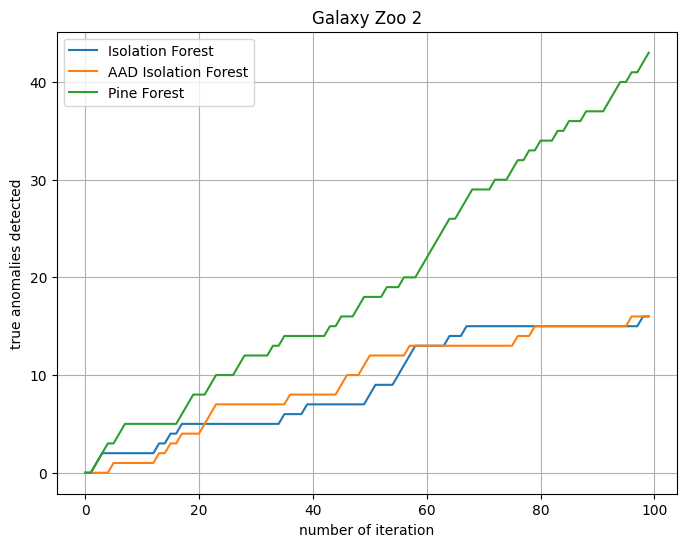

In [95]:
data, labels, ids = load_galaxy_zoo2(anomaly_class='Class8.6', anomaly_threshold=0.4)
cmp_86_40 = Compare(data, labels, n_jobs=15)
%time cmp_86_40.run()
cmp_86_40.plot(title="Galaxy Zoo 2 (Is merger? 40%)", filename="gz2_86_40.pdf")

701930: REGULAR

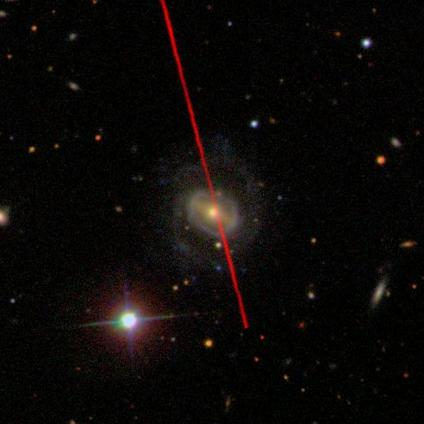

1.1 Smooth and rounded, no disk? smooth              0.086556
1.2 Smooth and rounded, no disk? features or disk    0.854299
1.3 Smooth and rounded, no disk? star or artifact    0.059146
2.1 Disk viewed edge on? yes                         0.037636
2.2 Disk viewed edge on? no                          0.816663
3.1 Bar feature through a center? yes                0.682959
3.2 Bar feature through a center? no                 0.133704
4.1 Spiral arm? yes                                  0.119150
4.2 Spiral arm? no                                   0.697513
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.108949
5.3 Prominent center bulge? obvious                  0.513188
5.4 Prominent center bulge? dominant                 0.194526
6.1 Anything odd? yes                                0.830922
6.2 Anything odd? no                                 0.169078
7.1 Is rounded? completely round                     0.044749
7.2 Is r

640786: REGULAR

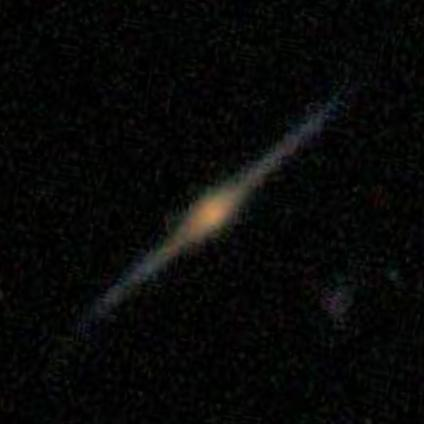

1.1 Smooth and rounded, no disk? smooth              0.017837
1.2 Smooth and rounded, no disk? features or disk    0.982163
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.982163
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.067234
6.2 Anything odd? no                                 0.932766
7.1 Is rounded? completely round                     0.000000
7.2 Is r

491495: ANOMALY

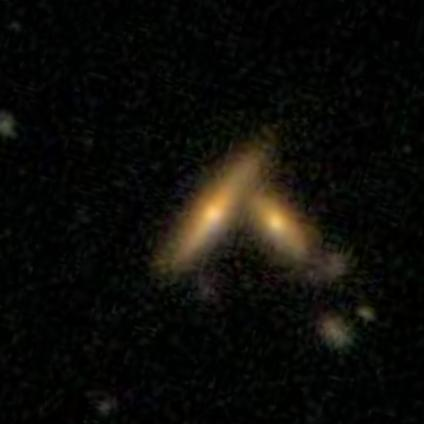

1.1 Smooth and rounded, no disk? smooth              0.151776
1.2 Smooth and rounded, no disk? features or disk    0.823610
1.3 Smooth and rounded, no disk? star or artifact    0.024614
2.1 Disk viewed edge on? yes                         0.767062
2.2 Disk viewed edge on? no                          0.056548
3.1 Bar feature through a center? yes                0.056548
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.056548
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.056548
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.726736
6.2 Anything odd? no                                 0.273264
7.1 Is rounded? completely round                     0.000000
7.2 Is r

962360: ANOMALY

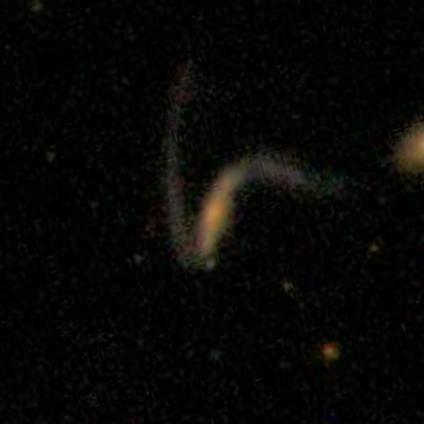

1.1 Smooth and rounded, no disk? smooth              0.004839
1.2 Smooth and rounded, no disk? features or disk    0.987711
1.3 Smooth and rounded, no disk? star or artifact    0.007450
2.1 Disk viewed edge on? yes                         0.117698
2.2 Disk viewed edge on? no                          0.870013
3.1 Bar feature through a center? yes                0.577126
3.2 Bar feature through a center? no                 0.292887
4.1 Spiral arm? yes                                  0.695851
4.2 Spiral arm? no                                   0.174162
5.1 Prominent center bulge? no bulge                 0.059879
5.2 Prominent center bulge? noticable                0.292423
5.3 Prominent center bulge? obvious                  0.517712
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.881818
6.2 Anything odd? no                                 0.118182
7.1 Is rounded? completely round                     0.000000
7.2 Is r

543677: ANOMALY

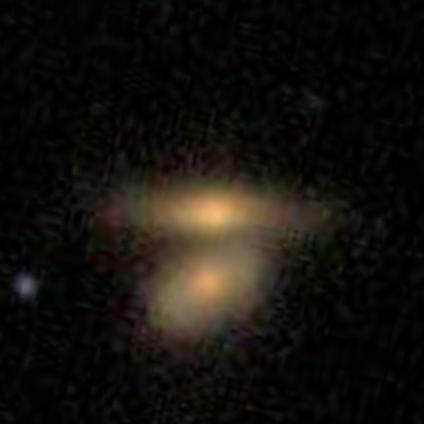

1.1 Smooth and rounded, no disk? smooth              0.207418
1.2 Smooth and rounded, no disk? features or disk    0.783107
1.3 Smooth and rounded, no disk? star or artifact    0.009475
2.1 Disk viewed edge on? yes                         0.292770
2.2 Disk viewed edge on? no                          0.490337
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.490337
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.490337
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.404458
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.085879
6.1 Anything odd? yes                                0.922262
6.2 Anything odd? no                                 0.077738
7.1 Is rounded? completely round                     0.000000
7.2 Is r

159862: REGULAR

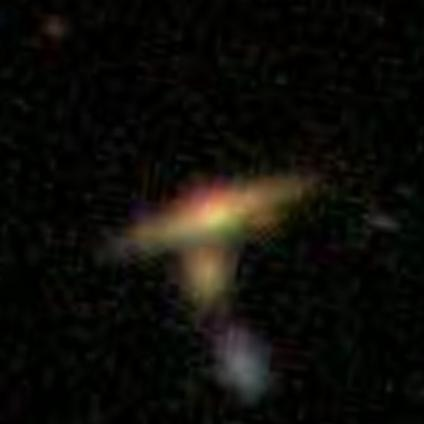

1.1 Smooth and rounded, no disk? smooth              0.110008
1.2 Smooth and rounded, no disk? features or disk    0.870651
1.3 Smooth and rounded, no disk? star or artifact    0.019341
2.1 Disk viewed edge on? yes                         0.669363
2.2 Disk viewed edge on? no                          0.201288
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.201288
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.201288
5.1 Prominent center bulge? no bulge                 0.201288
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.812340
6.2 Anything odd? no                                 0.187660
7.1 Is rounded? completely round                     0.010066
7.2 Is r

558082: ANOMALY

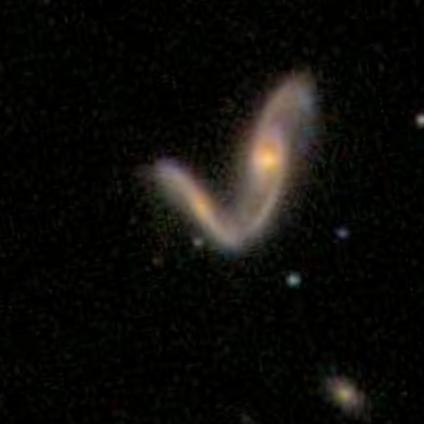

1.1 Smooth and rounded, no disk? smooth              0.022977
1.2 Smooth and rounded, no disk? features or disk    0.974151
1.3 Smooth and rounded, no disk? star or artifact    0.002872
2.1 Disk viewed edge on? yes                         0.082516
2.2 Disk viewed edge on? no                          0.891635
3.1 Bar feature through a center? yes                0.287056
3.2 Bar feature through a center? no                 0.604579
4.1 Spiral arm? yes                                  0.693939
4.2 Spiral arm? no                                   0.197696
5.1 Prominent center bulge? no bulge                 0.030787
5.2 Prominent center bulge? noticable                0.269981
5.3 Prominent center bulge? obvious                  0.506904
5.4 Prominent center bulge? dominant                 0.083963
6.1 Anything odd? yes                                0.954035
6.2 Anything odd? no                                 0.045965
7.1 Is rounded? completely round                     0.000000
7.2 Is r

171662: ANOMALY

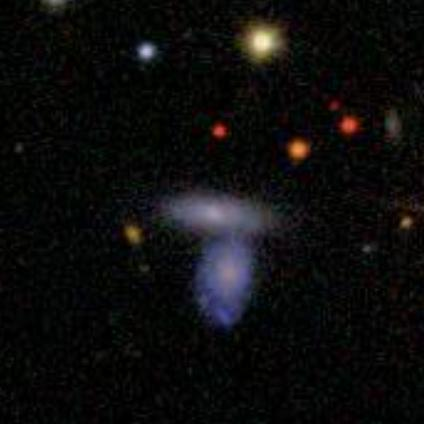

1.1 Smooth and rounded, no disk? smooth              0.237287
1.2 Smooth and rounded, no disk? features or disk    0.737059
1.3 Smooth and rounded, no disk? star or artifact    0.025653
2.1 Disk viewed edge on? yes                         0.120610
2.2 Disk viewed edge on? no                          0.616449
3.1 Bar feature through a center? yes                0.128179
3.2 Bar feature through a center? no                 0.488270
4.1 Spiral arm? yes                                  0.394815
4.2 Spiral arm? no                                   0.221634
5.1 Prominent center bulge? no bulge                 0.070491
5.2 Prominent center bulge? noticable                0.260535
5.3 Prominent center bulge? obvious                  0.212361
5.4 Prominent center bulge? dominant                 0.073062
6.1 Anything odd? yes                                0.769298
6.2 Anything odd? no                                 0.230702
7.1 Is rounded? completely round                     0.009833
7.2 Is r

669746: REGULAR

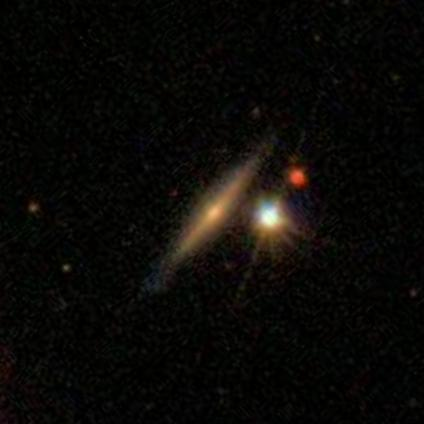

1.1 Smooth and rounded, no disk? smooth              0.078164
1.2 Smooth and rounded, no disk? features or disk    0.920164
1.3 Smooth and rounded, no disk? star or artifact    0.001672
2.1 Disk viewed edge on? yes                         0.920164
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.138774
6.2 Anything odd? no                                 0.861226
7.1 Is rounded? completely round                     0.000000
7.2 Is r

172693: REGULAR

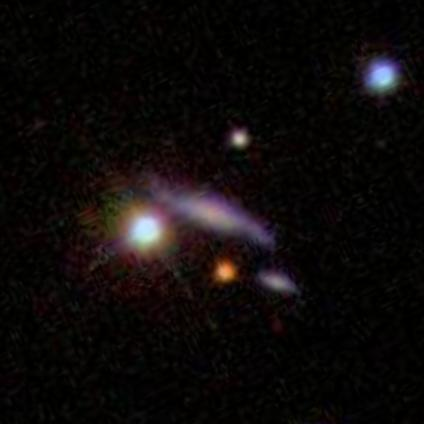

1.1 Smooth and rounded, no disk? smooth              0.051843
1.2 Smooth and rounded, no disk? features or disk    0.933636
1.3 Smooth and rounded, no disk? star or artifact    0.014521
2.1 Disk viewed edge on? yes                         0.682815
2.2 Disk viewed edge on? no                          0.250821
3.1 Bar feature through a center? yes                0.076818
3.2 Bar feature through a center? no                 0.174003
4.1 Spiral arm? yes                                  0.250821
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.089480
5.2 Prominent center bulge? noticable                0.161341
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.338513
6.2 Anything odd? no                                 0.661487
7.1 Is rounded? completely round                     0.000000
7.2 Is r

385733: REGULAR

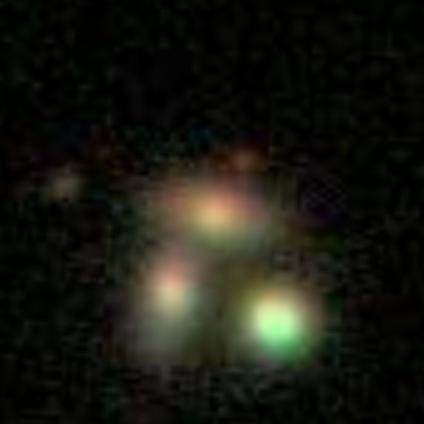

1.1 Smooth and rounded, no disk? smooth              0.318727
1.2 Smooth and rounded, no disk? features or disk    0.644354
1.3 Smooth and rounded, no disk? star or artifact    0.036919
2.1 Disk viewed edge on? yes                         0.025093
2.2 Disk viewed edge on? no                          0.619261
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.619261
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.619261
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.361640
5.4 Prominent center bulge? dominant                 0.257621
6.1 Anything odd? yes                                0.953939
6.2 Anything odd? no                                 0.046061
7.1 Is rounded? completely round                     0.044396
7.2 Is r

882284: REGULAR

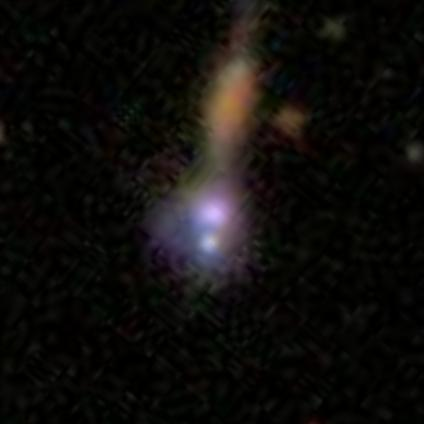

1.1 Smooth and rounded, no disk? smooth              0.162834
1.2 Smooth and rounded, no disk? features or disk    0.763580
1.3 Smooth and rounded, no disk? star or artifact    0.073586
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.763580
3.1 Bar feature through a center? yes                0.177003
3.2 Bar feature through a center? no                 0.586577
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.763580
5.1 Prominent center bulge? no bulge                 0.066929
5.2 Prominent center bulge? noticable                0.180471
5.3 Prominent center bulge? obvious                  0.352138
5.4 Prominent center bulge? dominant                 0.164042
6.1 Anything odd? yes                                0.969042
6.2 Anything odd? no                                 0.030958
7.1 Is rounded? completely round                     0.051921
7.2 Is r

826666: REGULAR

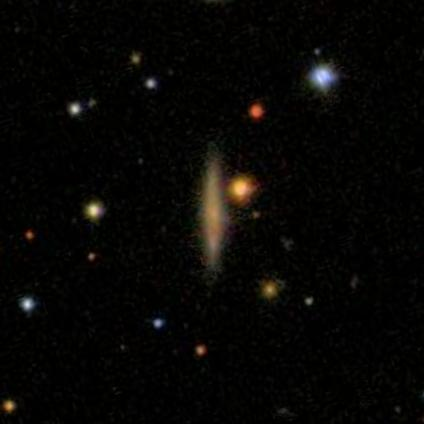

1.1 Smooth and rounded, no disk? smooth              0.145061
1.2 Smooth and rounded, no disk? features or disk    0.854939
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.757479
2.2 Disk viewed edge on? no                          0.097460
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.097460
4.1 Spiral arm? yes                                  0.043648
4.2 Spiral arm? no                                   0.053813
5.1 Prominent center bulge? no bulge                 0.097460
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.194233
6.2 Anything odd? no                                 0.805767
7.1 Is rounded? completely round                     0.000000
7.2 Is r

350779: REGULAR

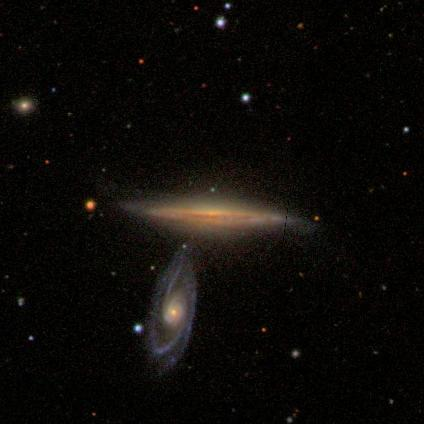

1.1 Smooth and rounded, no disk? smooth              0.210643
1.2 Smooth and rounded, no disk? features or disk    0.789357
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.747307
2.2 Disk viewed edge on? no                          0.042050
3.1 Bar feature through a center? yes                0.011991
3.2 Bar feature through a center? no                 0.030058
4.1 Spiral arm? yes                                  0.042050
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.009726
5.3 Prominent center bulge? obvious                  0.032324
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.556529
6.2 Anything odd? no                                 0.443471
7.1 Is rounded? completely round                     0.000000
7.2 Is r

809736: REGULAR

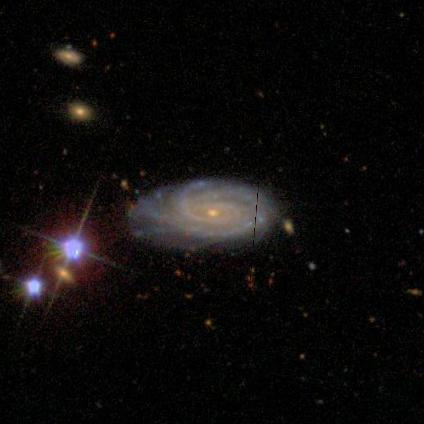

1.1 Smooth and rounded, no disk? smooth              0.044000
1.2 Smooth and rounded, no disk? features or disk    0.956000
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.956000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.956000
4.1 Spiral arm? yes                                  0.956000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.044932
5.2 Prominent center bulge? noticable                0.733252
5.3 Prominent center bulge? obvious                  0.177816
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.267000
6.2 Anything odd? no                                 0.733000
7.1 Is rounded? completely round                     0.000000
7.2 Is r

808755: REGULAR

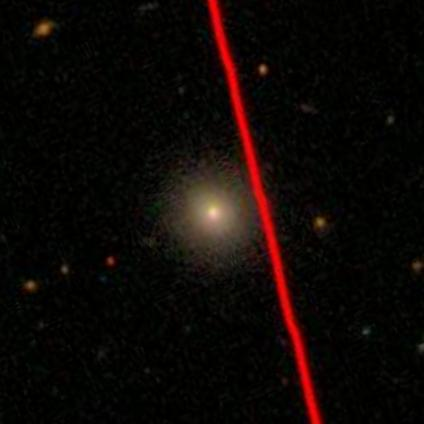

1.1 Smooth and rounded, no disk? smooth              0.720660
1.2 Smooth and rounded, no disk? features or disk    0.139668
1.3 Smooth and rounded, no disk? star or artifact    0.139672
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.139668
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.139668
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.139668
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.139668
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.303984
6.2 Anything odd? no                                 0.696016
7.1 Is rounded? completely round                     0.692011
7.2 Is r

588259: REGULAR

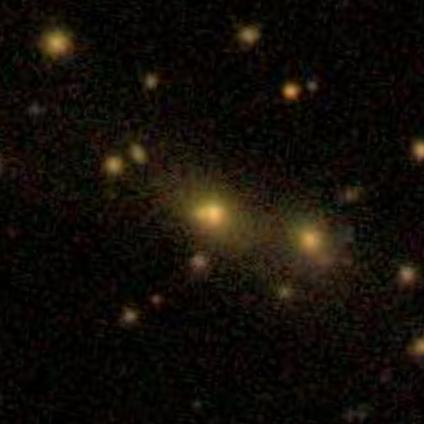

1.1 Smooth and rounded, no disk? smooth              0.735000
1.2 Smooth and rounded, no disk? features or disk    0.224000
1.3 Smooth and rounded, no disk? star or artifact    0.041000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.224000
3.1 Bar feature through a center? yes                0.040768
3.2 Bar feature through a center? no                 0.183232
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.224000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.040768
5.3 Prominent center bulge? obvious                  0.142464
5.4 Prominent center bulge? dominant                 0.040768
6.1 Anything odd? yes                                0.803811
6.2 Anything odd? no                                 0.196189
7.1 Is rounded? completely round                     0.244755
7.2 Is r

160422: ANOMALY

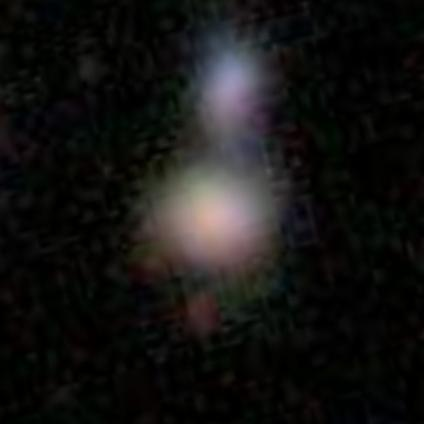

1.1 Smooth and rounded, no disk? smooth              0.535880
1.2 Smooth and rounded, no disk? features or disk    0.406001
1.3 Smooth and rounded, no disk? star or artifact    0.058119
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.406001
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.406001
4.1 Spiral arm? yes                                  0.128250
4.2 Spiral arm? no                                   0.277751
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.141121
5.3 Prominent center bulge? obvious                  0.058966
5.4 Prominent center bulge? dominant                 0.205914
6.1 Anything odd? yes                                0.886388
6.2 Anything odd? no                                 0.113612
7.1 Is rounded? completely round                     0.351345
7.2 Is r

391505: ANOMALY

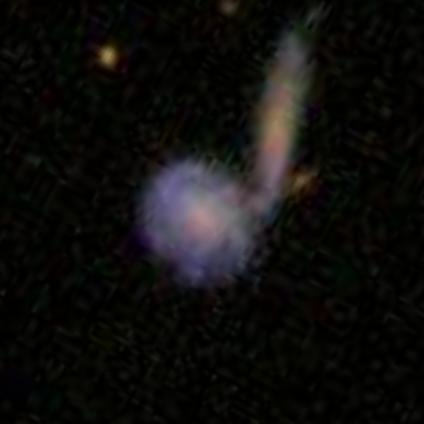

1.1 Smooth and rounded, no disk? smooth              0.034051
1.2 Smooth and rounded, no disk? features or disk    0.965949
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.030447
2.2 Disk viewed edge on? no                          0.935502
3.1 Bar feature through a center? yes                0.198261
3.2 Bar feature through a center? no                 0.737241
4.1 Spiral arm? yes                                  0.762320
4.2 Spiral arm? no                                   0.173182
5.1 Prominent center bulge? no bulge                 0.278370
5.2 Prominent center bulge? noticable                0.465860
5.3 Prominent center bulge? obvious                  0.109367
5.4 Prominent center bulge? dominant                 0.081906
6.1 Anything odd? yes                                0.828276
6.2 Anything odd? no                                 0.171724
7.1 Is rounded? completely round                     0.029996
7.2 Is r

593257: ANOMALY

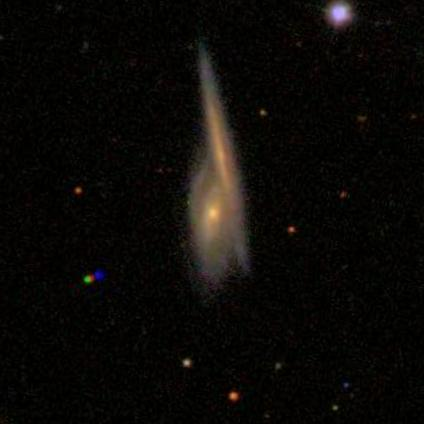

1.1 Smooth and rounded, no disk? smooth              0.160124
1.2 Smooth and rounded, no disk? features or disk    0.839876
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.401278
2.2 Disk viewed edge on? no                          0.438598
3.1 Bar feature through a center? yes                0.067305
3.2 Bar feature through a center? no                 0.371293
4.1 Spiral arm? yes                                  0.324861
4.2 Spiral arm? no                                   0.113738
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.168078
5.3 Prominent center bulge? obvious                  0.244769
5.4 Prominent center bulge? dominant                 0.025751
6.1 Anything odd? yes                                0.928465
6.2 Anything odd? no                                 0.071535
7.1 Is rounded? completely round                     0.017293
7.2 Is r

224231: REGULAR

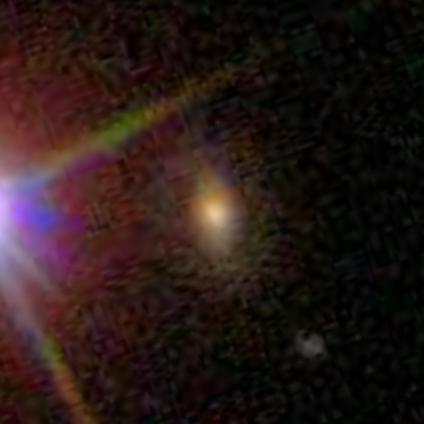

1.1 Smooth and rounded, no disk? smooth              0.631409
1.2 Smooth and rounded, no disk? features or disk    0.226269
1.3 Smooth and rounded, no disk? star or artifact    0.142321
2.1 Disk viewed edge on? yes                         0.019076
2.2 Disk viewed edge on? no                          0.207193
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.207193
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.207193
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.207193
6.1 Anything odd? yes                                0.092043
6.2 Anything odd? no                                 0.907957
7.1 Is rounded? completely round                     0.039142
7.2 Is r

691909: REGULAR

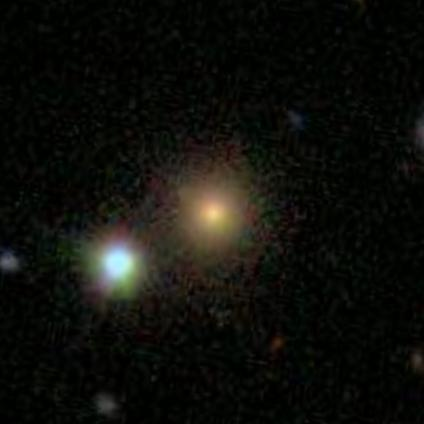

1.1 Smooth and rounded, no disk? smooth              0.616733
1.2 Smooth and rounded, no disk? features or disk    0.319686
1.3 Smooth and rounded, no disk? star or artifact    0.063581
2.1 Disk viewed edge on? yes                         0.042780
2.2 Disk viewed edge on? no                          0.276906
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.276906
4.1 Spiral arm? yes                                  0.152308
4.2 Spiral arm? no                                   0.124598
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.276906
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.362382
6.2 Anything odd? no                                 0.637618
7.1 Is rounded? completely round                     0.572148
7.2 Is r

442496: ANOMALY

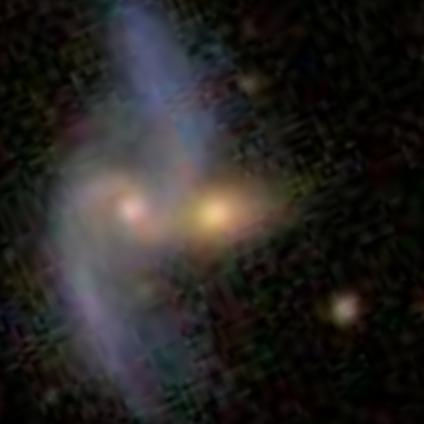

1.1 Smooth and rounded, no disk? smooth              0.150481
1.2 Smooth and rounded, no disk? features or disk    0.838046
1.3 Smooth and rounded, no disk? star or artifact    0.011473
2.1 Disk viewed edge on? yes                         0.125707
2.2 Disk viewed edge on? no                          0.712339
3.1 Bar feature through a center? yes                0.452286
3.2 Bar feature through a center? no                 0.260053
4.1 Spiral arm? yes                                  0.681257
4.2 Spiral arm? no                                   0.031082
5.1 Prominent center bulge? no bulge                 0.022471
5.2 Prominent center bulge? noticable                0.254481
5.3 Prominent center bulge? obvious                  0.381129
5.4 Prominent center bulge? dominant                 0.054257
6.1 Anything odd? yes                                0.943806
6.2 Anything odd? no                                 0.056194
7.1 Is rounded? completely round                     0.017371
7.2 Is r

618840: ANOMALY

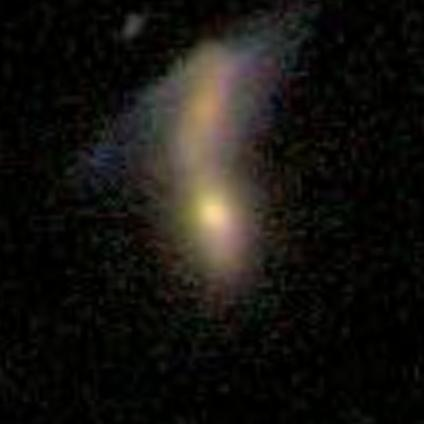

1.1 Smooth and rounded, no disk? smooth              0.425392
1.2 Smooth and rounded, no disk? features or disk    0.538016
1.3 Smooth and rounded, no disk? star or artifact    0.036592
2.1 Disk viewed edge on? yes                         0.011094
2.2 Disk viewed edge on? no                          0.526922
3.1 Bar feature through a center? yes                0.211268
3.2 Bar feature through a center? no                 0.315654
4.1 Spiral arm? yes                                  0.233985
4.2 Spiral arm? no                                   0.292937
5.1 Prominent center bulge? no bulge                 0.053128
5.2 Prominent center bulge? noticable                0.119030
5.3 Prominent center bulge? obvious                  0.127208
5.4 Prominent center bulge? dominant                 0.227556
6.1 Anything odd? yes                                0.989511
6.2 Anything odd? no                                 0.010489
7.1 Is rounded? completely round                     0.021144
7.2 Is r

584391: REGULAR

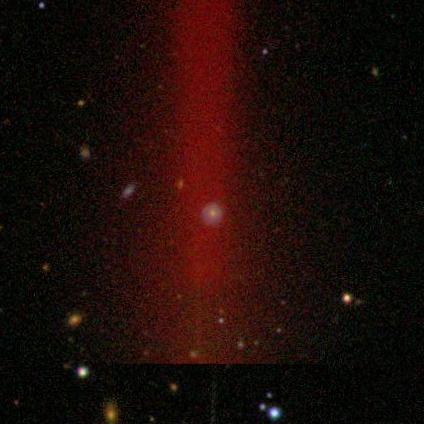

1.1 Smooth and rounded, no disk? smooth              0.176000
1.2 Smooth and rounded, no disk? features or disk    0.206000
1.3 Smooth and rounded, no disk? star or artifact    0.618000
2.1 Disk viewed edge on? yes                         0.029458
2.2 Disk viewed edge on? no                          0.176542
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.176542
4.1 Spiral arm? yes                                  0.058788
4.2 Spiral arm? no                                   0.117754
5.1 Prominent center bulge? no bulge                 0.029483
5.2 Prominent center bulge? noticable                0.088271
5.3 Prominent center bulge? obvious                  0.058788
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.615000
6.2 Anything odd? no                                 0.385000
7.1 Is rounded? completely round                     0.146608
7.2 Is r

531095: REGULAR

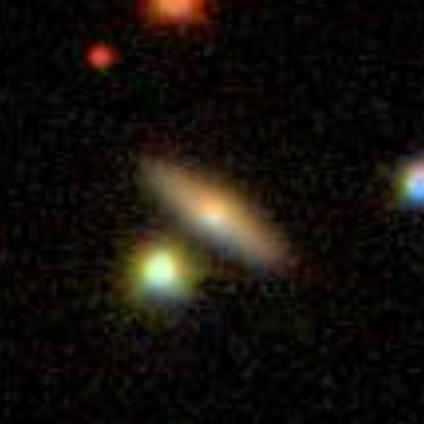

1.1 Smooth and rounded, no disk? smooth              0.604744
1.2 Smooth and rounded, no disk? features or disk    0.325145
1.3 Smooth and rounded, no disk? star or artifact    0.070111
2.1 Disk viewed edge on? yes                         0.236706
2.2 Disk viewed edge on? no                          0.088439
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.088439
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.088439
5.1 Prominent center bulge? no bulge                 0.048256
5.2 Prominent center bulge? noticable                0.040183
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.566643
6.2 Anything odd? no                                 0.433357
7.1 Is rounded? completely round                     0.025331
7.2 Is r

421829: REGULAR

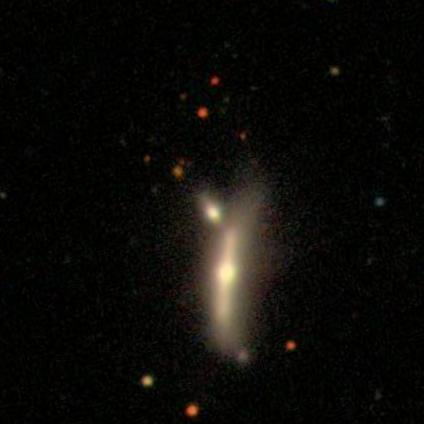

1.1 Smooth and rounded, no disk? smooth              0.207268
1.2 Smooth and rounded, no disk? features or disk    0.792732
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.660346
2.2 Disk viewed edge on? no                          0.132386
3.1 Bar feature through a center? yes                0.132386
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.132386
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.132386
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.847048
6.2 Anything odd? no                                 0.152952
7.1 Is rounded? completely round                     0.031852
7.2 Is r

484754: ANOMALY

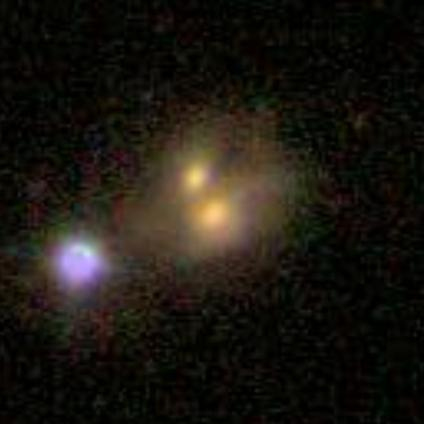

1.1 Smooth and rounded, no disk? smooth              0.293523
1.2 Smooth and rounded, no disk? features or disk    0.670272
1.3 Smooth and rounded, no disk? star or artifact    0.036206
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.670272
3.1 Bar feature through a center? yes                0.089296
3.2 Bar feature through a center? no                 0.580976
4.1 Spiral arm? yes                                  0.314398
4.2 Spiral arm? no                                   0.355874
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.041314
5.3 Prominent center bulge? obvious                  0.556464
5.4 Prominent center bulge? dominant                 0.072495
6.1 Anything odd? yes                                0.940401
6.2 Anything odd? no                                 0.059599
7.1 Is rounded? completely round                     0.073267
7.2 Is r

373505: ANOMALY

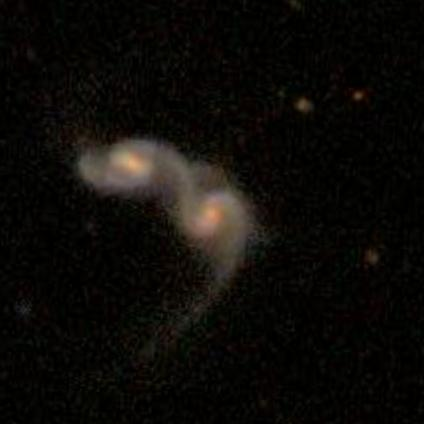

1.1 Smooth and rounded, no disk? smooth              0.000000
1.2 Smooth and rounded, no disk? features or disk    0.984010
1.3 Smooth and rounded, no disk? star or artifact    0.015990
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.984010
3.1 Bar feature through a center? yes                0.456347
3.2 Bar feature through a center? no                 0.527663
4.1 Spiral arm? yes                                  0.984010
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.046149
5.2 Prominent center bulge? noticable                0.402812
5.3 Prominent center bulge? obvious                  0.424596
5.4 Prominent center bulge? dominant                 0.110453
6.1 Anything odd? yes                                1.000000
6.2 Anything odd? no                                 0.000000
7.1 Is rounded? completely round                     0.000000
7.2 Is r

960415: REGULAR

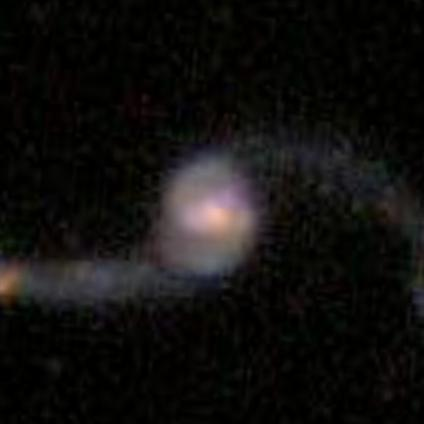

1.1 Smooth and rounded, no disk? smooth              0.005691
1.2 Smooth and rounded, no disk? features or disk    0.970982
1.3 Smooth and rounded, no disk? star or artifact    0.023327
2.1 Disk viewed edge on? yes                         0.025246
2.2 Disk viewed edge on? no                          0.945736
3.1 Bar feature through a center? yes                0.565437
3.2 Bar feature through a center? no                 0.380300
4.1 Spiral arm? yes                                  0.936000
4.2 Spiral arm? no                                   0.009736
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.373971
5.3 Prominent center bulge? obvious                  0.303412
5.4 Prominent center bulge? dominant                 0.268353
6.1 Anything odd? yes                                0.783788
6.2 Anything odd? no                                 0.216212
7.1 Is rounded? completely round                     0.000000
7.2 Is r

400126: REGULAR

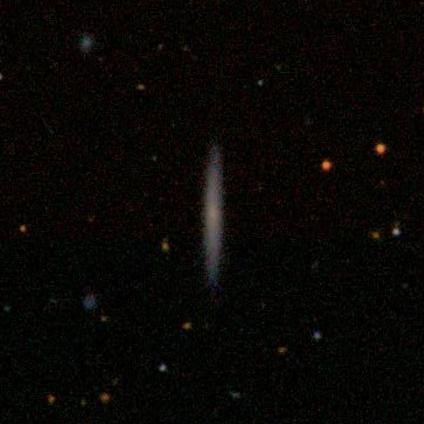

1.1 Smooth and rounded, no disk? smooth              0.270171
1.2 Smooth and rounded, no disk? features or disk    0.697668
1.3 Smooth and rounded, no disk? star or artifact    0.032162
2.1 Disk viewed edge on? yes                         0.697668
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.020600
6.2 Anything odd? no                                 0.979400
7.1 Is rounded? completely round                     0.000000
7.2 Is r

169821: REGULAR

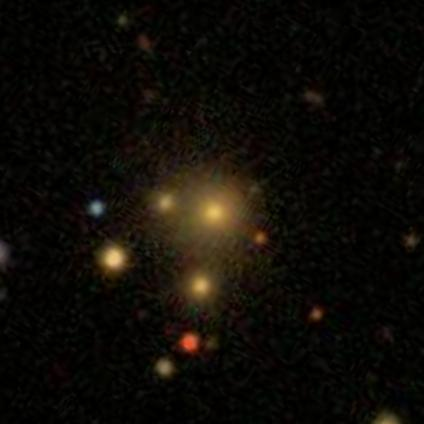

1.1 Smooth and rounded, no disk? smooth              0.665126
1.2 Smooth and rounded, no disk? features or disk    0.232548
1.3 Smooth and rounded, no disk? star or artifact    0.102326
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.232548
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.232548
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.232548
5.1 Prominent center bulge? no bulge                 0.124199
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.053052
5.4 Prominent center bulge? dominant                 0.055297
6.1 Anything odd? yes                                0.515405
6.2 Anything odd? no                                 0.484595
7.1 Is rounded? completely round                     0.630306
7.2 Is r

264534: REGULAR

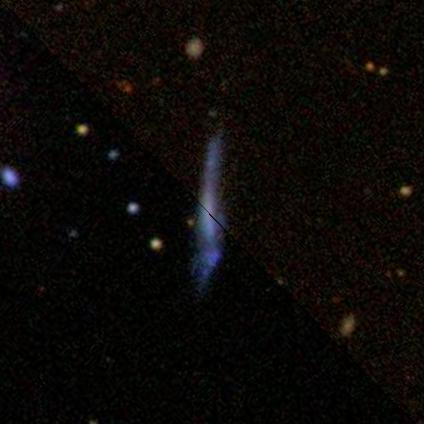

1.1 Smooth and rounded, no disk? smooth              0.096801
1.2 Smooth and rounded, no disk? features or disk    0.836835
1.3 Smooth and rounded, no disk? star or artifact    0.066363
2.1 Disk viewed edge on? yes                         0.507109
2.2 Disk viewed edge on? no                          0.329726
3.1 Bar feature through a center? yes                0.181094
3.2 Bar feature through a center? no                 0.148632
4.1 Spiral arm? yes                                  0.058461
4.2 Spiral arm? no                                   0.271266
5.1 Prominent center bulge? no bulge                 0.108280
5.2 Prominent center bulge? noticable                0.111641
5.3 Prominent center bulge? obvious                  0.109805
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.581684
6.2 Anything odd? no                                 0.418316
7.1 Is rounded? completely round                     0.000000
7.2 Is r

193873: ANOMALY

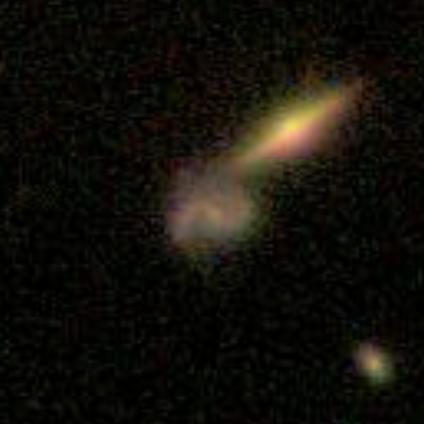

1.1 Smooth and rounded, no disk? smooth              0.023499
1.2 Smooth and rounded, no disk? features or disk    0.934237
1.3 Smooth and rounded, no disk? star or artifact    0.042264
2.1 Disk viewed edge on? yes                         0.247306
2.2 Disk viewed edge on? no                          0.686931
3.1 Bar feature through a center? yes                0.458899
3.2 Bar feature through a center? no                 0.228032
4.1 Spiral arm? yes                                  0.638980
4.2 Spiral arm? no                                   0.047951
5.1 Prominent center bulge? no bulge                 0.103018
5.2 Prominent center bulge? noticable                0.467673
5.3 Prominent center bulge? obvious                  0.116241
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.769667
6.2 Anything odd? no                                 0.230333
7.1 Is rounded? completely round                     0.004826
7.2 Is r

512456: REGULAR

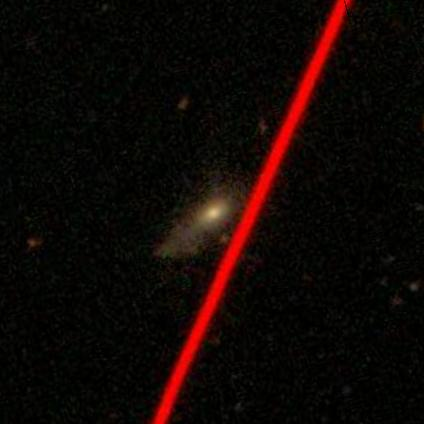

1.1 Smooth and rounded, no disk? smooth              0.443327
1.2 Smooth and rounded, no disk? features or disk    0.381172
1.3 Smooth and rounded, no disk? star or artifact    0.175501
2.1 Disk viewed edge on? yes                         0.318090
2.2 Disk viewed edge on? no                          0.063082
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.063082
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.063082
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.031464
5.3 Prominent center bulge? obvious                  0.031618
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.572753
6.2 Anything odd? no                                 0.427247
7.1 Is rounded? completely round                     0.024047
7.2 Is r

490337: ANOMALY

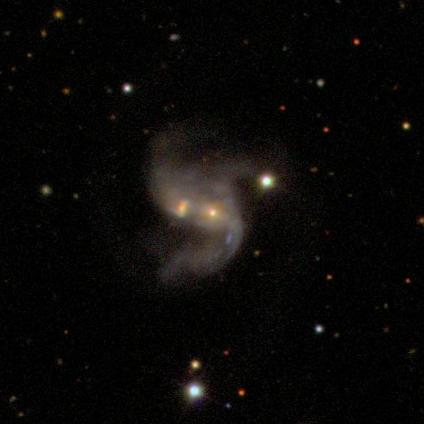

1.1 Smooth and rounded, no disk? smooth              0.077000
1.2 Smooth and rounded, no disk? features or disk    0.923000
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.019383
2.2 Disk viewed edge on? no                          0.903617
3.1 Bar feature through a center? yes                0.076113
3.2 Bar feature through a center? no                 0.827504
4.1 Spiral arm? yes                                  0.114085
4.2 Spiral arm? no                                   0.789532
5.1 Prominent center bulge? no bulge                 0.115663
5.2 Prominent center bulge? noticable                0.363254
5.3 Prominent center bulge? obvious                  0.405724
5.4 Prominent center bulge? dominant                 0.018976
6.1 Anything odd? yes                                0.907000
6.2 Anything odd? no                                 0.093000
7.1 Is rounded? completely round                     0.038500
7.2 Is r

753840: REGULAR

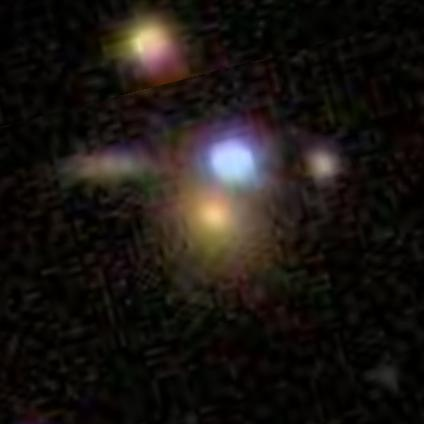

1.1 Smooth and rounded, no disk? smooth              0.612010
1.2 Smooth and rounded, no disk? features or disk    0.323562
1.3 Smooth and rounded, no disk? star or artifact    0.064427
2.1 Disk viewed edge on? yes                         0.080891
2.2 Disk viewed edge on? no                          0.242672
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.242672
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.242672
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.095695
5.3 Prominent center bulge? obvious                  0.101769
5.4 Prominent center bulge? dominant                 0.045207
6.1 Anything odd? yes                                0.685598
6.2 Anything odd? no                                 0.314402
7.1 Is rounded? completely round                     0.443491
7.2 Is r

757105: REGULAR

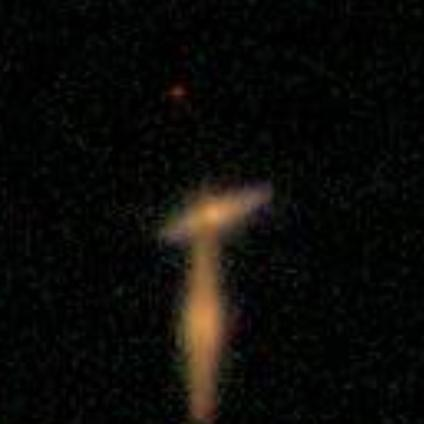

1.1 Smooth and rounded, no disk? smooth              0.058494
1.2 Smooth and rounded, no disk? features or disk    0.936717
1.3 Smooth and rounded, no disk? star or artifact    0.004790
2.1 Disk viewed edge on? yes                         0.809280
2.2 Disk viewed edge on? no                          0.127437
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.127437
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.127437
5.1 Prominent center bulge? no bulge                 0.127437
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.745700
6.2 Anything odd? no                                 0.254300
7.1 Is rounded? completely round                     0.000000
7.2 Is r

343044: REGULAR

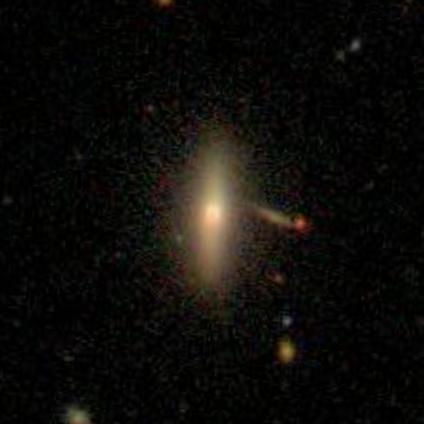

1.1 Smooth and rounded, no disk? smooth              0.394215
1.2 Smooth and rounded, no disk? features or disk    0.605785
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.326421
2.2 Disk viewed edge on? no                          0.279364
3.1 Bar feature through a center? yes                0.279364
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.279364
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.138256
5.3 Prominent center bulge? obvious                  0.141107
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.599432
6.2 Anything odd? no                                 0.400568
7.1 Is rounded? completely round                     0.000000
7.2 Is r

107967: REGULAR

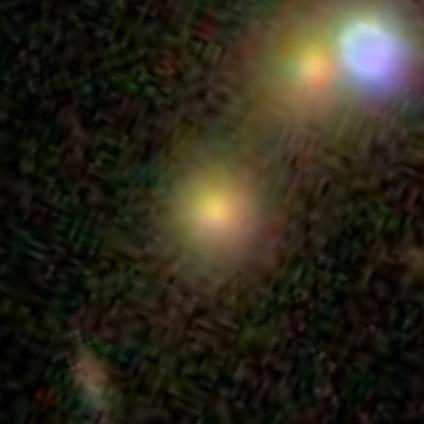

1.1 Smooth and rounded, no disk? smooth              0.935834
1.2 Smooth and rounded, no disk? features or disk    0.030653
1.3 Smooth and rounded, no disk? star or artifact    0.033513
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.030653
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.030653
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.030653
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.030653
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.315752
6.2 Anything odd? no                                 0.684248
7.1 Is rounded? completely round                     0.811099
7.2 Is r

162212: REGULAR

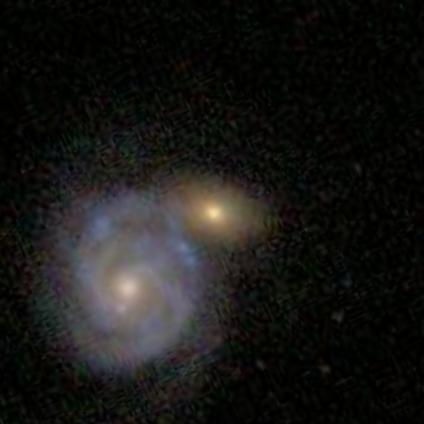

1.1 Smooth and rounded, no disk? smooth              0.181895
1.2 Smooth and rounded, no disk? features or disk    0.800054
1.3 Smooth and rounded, no disk? star or artifact    0.018051
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.800054
3.1 Bar feature through a center? yes                0.143485
3.2 Bar feature through a center? no                 0.656569
4.1 Spiral arm? yes                                  0.764732
4.2 Spiral arm? no                                   0.035322
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.376895
5.3 Prominent center bulge? obvious                  0.389191
5.4 Prominent center bulge? dominant                 0.033968
6.1 Anything odd? yes                                0.615108
6.2 Anything odd? no                                 0.384892
7.1 Is rounded? completely round                     0.007593
7.2 Is r

391398: REGULAR

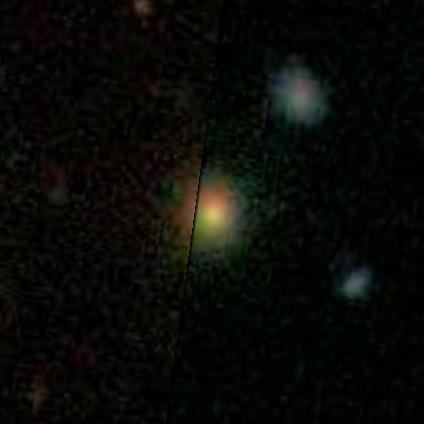

1.1 Smooth and rounded, no disk? smooth              0.894361
1.2 Smooth and rounded, no disk? features or disk    0.000000
1.3 Smooth and rounded, no disk? star or artifact    0.105639
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.362282
6.2 Anything odd? no                                 0.637718
7.1 Is rounded? completely round                     0.816439
7.2 Is r

644116: REGULAR

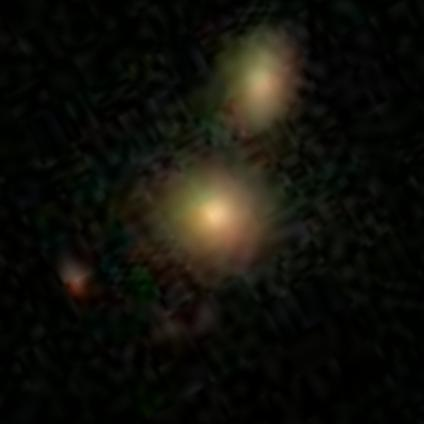

1.1 Smooth and rounded, no disk? smooth              0.598432
1.2 Smooth and rounded, no disk? features or disk    0.371953
1.3 Smooth and rounded, no disk? star or artifact    0.029615
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.371953
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.371953
4.1 Spiral arm? yes                                  0.140976
4.2 Spiral arm? no                                   0.230977
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.064879
5.3 Prominent center bulge? obvious                  0.234494
5.4 Prominent center bulge? dominant                 0.072580
6.1 Anything odd? yes                                0.619789
6.2 Anything odd? no                                 0.380211
7.1 Is rounded? completely round                     0.530560
7.2 Is r

829770: ANOMALY

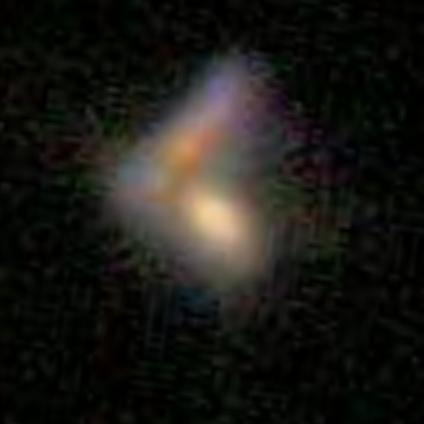

1.1 Smooth and rounded, no disk? smooth              0.577244
1.2 Smooth and rounded, no disk? features or disk    0.397703
1.3 Smooth and rounded, no disk? star or artifact    0.025053
2.1 Disk viewed edge on? yes                         0.033009
2.2 Disk viewed edge on? no                          0.364694
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.364694
4.1 Spiral arm? yes                                  0.098919
4.2 Spiral arm? no                                   0.265775
5.1 Prominent center bulge? no bulge                 0.133305
5.2 Prominent center bulge? noticable                0.033326
5.3 Prominent center bulge? obvious                  0.075802
5.4 Prominent center bulge? dominant                 0.122260
6.1 Anything odd? yes                                0.972032
6.2 Anything odd? no                                 0.027968
7.1 Is rounded? completely round                     0.138523
7.2 Is r

675126: REGULAR

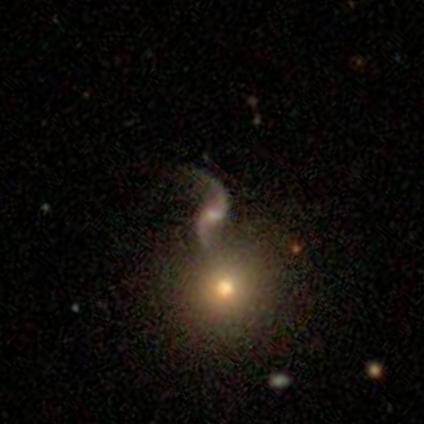

1.1 Smooth and rounded, no disk? smooth              0.038085
1.2 Smooth and rounded, no disk? features or disk    0.951975
1.3 Smooth and rounded, no disk? star or artifact    0.009941
2.1 Disk viewed edge on? yes                         0.057355
2.2 Disk viewed edge on? no                          0.894620
3.1 Bar feature through a center? yes                0.252179
3.2 Bar feature through a center? no                 0.642441
4.1 Spiral arm? yes                                  0.894620
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.079789
5.2 Prominent center bulge? noticable                0.644123
5.3 Prominent center bulge? obvious                  0.170708
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.440317
6.2 Anything odd? no                                 0.559683
7.1 Is rounded? completely round                     0.022499
7.2 Is r

159874: ANOMALY

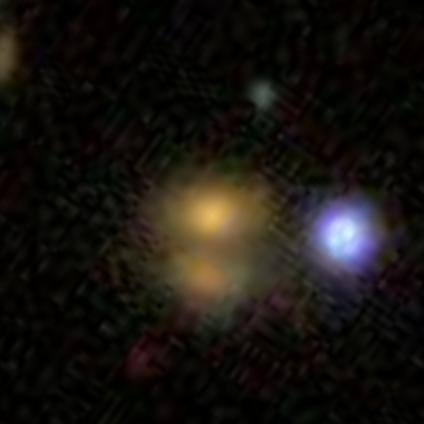

1.1 Smooth and rounded, no disk? smooth              0.380040
1.2 Smooth and rounded, no disk? features or disk    0.555206
1.3 Smooth and rounded, no disk? star or artifact    0.064754
2.1 Disk viewed edge on? yes                         0.055521
2.2 Disk viewed edge on? no                          0.499685
3.1 Bar feature through a center? yes                0.138607
3.2 Bar feature through a center? no                 0.361079
4.1 Spiral arm? yes                                  0.138577
4.2 Spiral arm? no                                   0.361108
5.1 Prominent center bulge? no bulge                 0.117548
5.2 Prominent center bulge? noticable                0.089647
5.3 Prominent center bulge? obvious                  0.031758
5.4 Prominent center bulge? dominant                 0.260732
6.1 Anything odd? yes                                0.922672
6.2 Anything odd? no                                 0.077328
7.1 Is rounded? completely round                     0.076208
7.2 Is r

895300: REGULAR

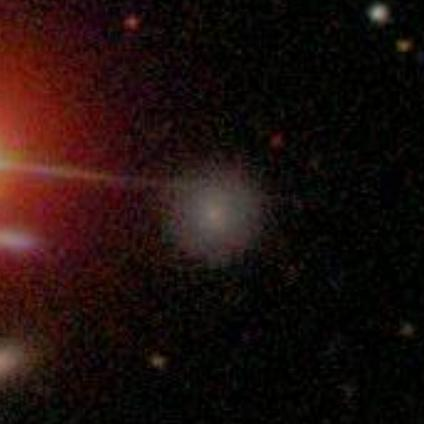

1.1 Smooth and rounded, no disk? smooth              0.686455
1.2 Smooth and rounded, no disk? features or disk    0.313545
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.313545
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.313545
4.1 Spiral arm? yes                                  0.228432
4.2 Spiral arm? no                                   0.085113
5.1 Prominent center bulge? no bulge                 0.094925
5.2 Prominent center bulge? noticable                0.218620
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.035449
6.2 Anything odd? no                                 0.964551
7.1 Is rounded? completely round                     0.644915
7.2 Is r

964184: REGULAR

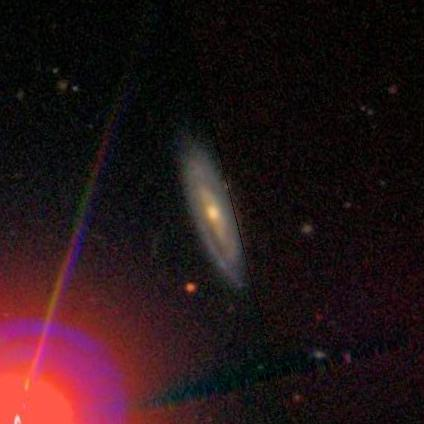

1.1 Smooth and rounded, no disk? smooth              0.131597
1.2 Smooth and rounded, no disk? features or disk    0.868403
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.212164
2.2 Disk viewed edge on? no                          0.656239
3.1 Bar feature through a center? yes                0.183779
3.2 Bar feature through a center? no                 0.472460
4.1 Spiral arm? yes                                  0.336594
4.2 Spiral arm? no                                   0.319645
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.215237
5.3 Prominent center bulge? obvious                  0.441002
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.205673
6.2 Anything odd? no                                 0.794327
7.1 Is rounded? completely round                     0.000000
7.2 Is r

746423: ANOMALY

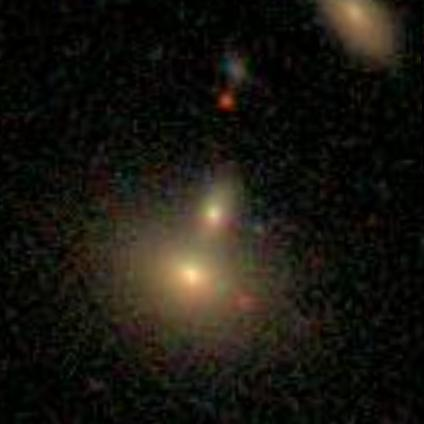

1.1 Smooth and rounded, no disk? smooth              0.283998
1.2 Smooth and rounded, no disk? features or disk    0.696687
1.3 Smooth and rounded, no disk? star or artifact    0.019315
2.1 Disk viewed edge on? yes                         0.028116
2.2 Disk viewed edge on? no                          0.668571
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.668571
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.668571
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.189251
5.3 Prominent center bulge? obvious                  0.422141
5.4 Prominent center bulge? dominant                 0.057180
6.1 Anything odd? yes                                0.806487
6.2 Anything odd? no                                 0.193513
7.1 Is rounded? completely round                     0.119108
7.2 Is r

964048: ANOMALY

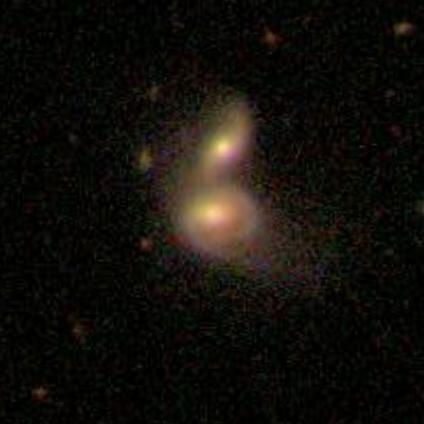

1.1 Smooth and rounded, no disk? smooth              0.075074
1.2 Smooth and rounded, no disk? features or disk    0.924926
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.924926
3.1 Bar feature through a center? yes                0.549231
3.2 Bar feature through a center? no                 0.375695
4.1 Spiral arm? yes                                  0.878868
4.2 Spiral arm? no                                   0.046058
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.152835
5.3 Prominent center bulge? obvious                  0.474987
5.4 Prominent center bulge? dominant                 0.297104
6.1 Anything odd? yes                                0.981419
6.2 Anything odd? no                                 0.018581
7.1 Is rounded? completely round                     0.000000
7.2 Is r

779302: REGULAR

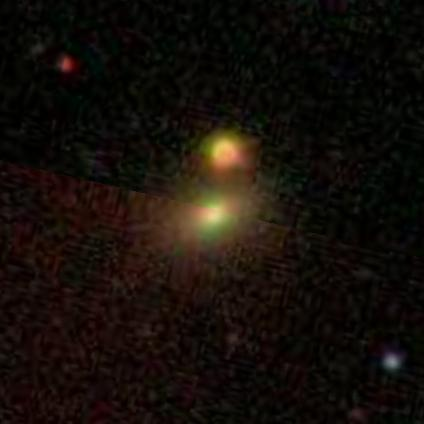

1.1 Smooth and rounded, no disk? smooth              0.481366
1.2 Smooth and rounded, no disk? features or disk    0.280062
1.3 Smooth and rounded, no disk? star or artifact    0.238572
2.1 Disk viewed edge on? yes                         0.009473
2.2 Disk viewed edge on? no                          0.270589
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.270589
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.270589
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.140592
5.4 Prominent center bulge? dominant                 0.129996
6.1 Anything odd? yes                                0.800376
6.2 Anything odd? no                                 0.199624
7.1 Is rounded? completely round                     0.237203
7.2 Is r

237071: REGULAR

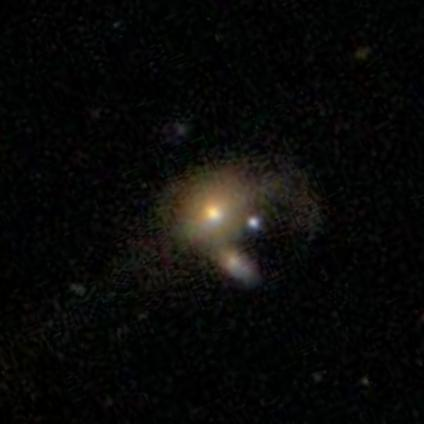

1.1 Smooth and rounded, no disk? smooth              0.362816
1.2 Smooth and rounded, no disk? features or disk    0.582292
1.3 Smooth and rounded, no disk? star or artifact    0.054892
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.582292
3.1 Bar feature through a center? yes                0.230306
3.2 Bar feature through a center? no                 0.351986
4.1 Spiral arm? yes                                  0.228583
4.2 Spiral arm? no                                   0.353709
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.049629
5.3 Prominent center bulge? obvious                  0.407570
5.4 Prominent center bulge? dominant                 0.125093
6.1 Anything odd? yes                                0.778345
6.2 Anything odd? no                                 0.221655
7.1 Is rounded? completely round                     0.203190
7.2 Is r

698492: REGULAR

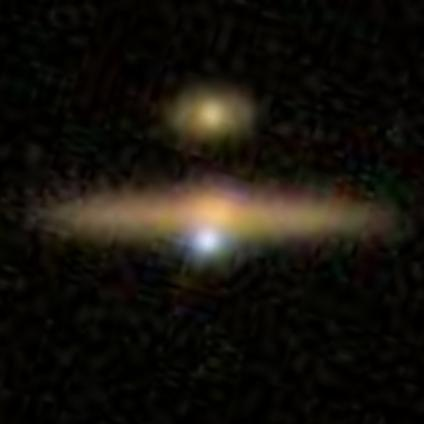

1.1 Smooth and rounded, no disk? smooth              0.059709
1.2 Smooth and rounded, no disk? features or disk    0.908862
1.3 Smooth and rounded, no disk? star or artifact    0.031429
2.1 Disk viewed edge on? yes                         0.908862
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.726715
6.2 Anything odd? no                                 0.273285
7.1 Is rounded? completely round                     0.001058
7.2 Is r

487159: ANOMALY

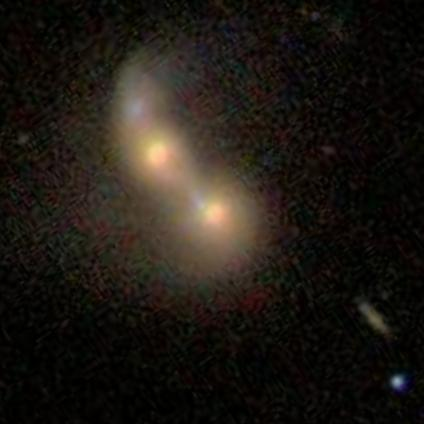

1.1 Smooth and rounded, no disk? smooth              0.621884
1.2 Smooth and rounded, no disk? features or disk    0.262544
1.3 Smooth and rounded, no disk? star or artifact    0.115572
2.1 Disk viewed edge on? yes                         0.015041
2.2 Disk viewed edge on? no                          0.247503
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.247503
4.1 Spiral arm? yes                                  0.065982
4.2 Spiral arm? no                                   0.181521
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.065640
5.3 Prominent center bulge? obvious                  0.021136
5.4 Prominent center bulge? dominant                 0.160726
6.1 Anything odd? yes                                0.953321
6.2 Anything odd? no                                 0.046679
7.1 Is rounded? completely round                     0.480978
7.2 Is r

585068: REGULAR

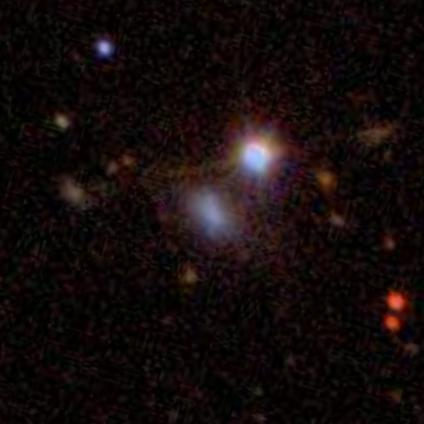

1.1 Smooth and rounded, no disk? smooth              0.361829
1.2 Smooth and rounded, no disk? features or disk    0.453933
1.3 Smooth and rounded, no disk? star or artifact    0.184238
2.1 Disk viewed edge on? yes                         0.048141
2.2 Disk viewed edge on? no                          0.405792
3.1 Bar feature through a center? yes                0.154682
3.2 Bar feature through a center? no                 0.251110
4.1 Spiral arm? yes                                  0.196185
4.2 Spiral arm? no                                   0.209607
5.1 Prominent center bulge? no bulge                 0.163419
5.2 Prominent center bulge? noticable                0.108455
5.3 Prominent center bulge? obvious                  0.032213
5.4 Prominent center bulge? dominant                 0.101705
6.1 Anything odd? yes                                0.532633
6.2 Anything odd? no                                 0.467367
7.1 Is rounded? completely round                     0.072916
7.2 Is r

301139: REGULAR

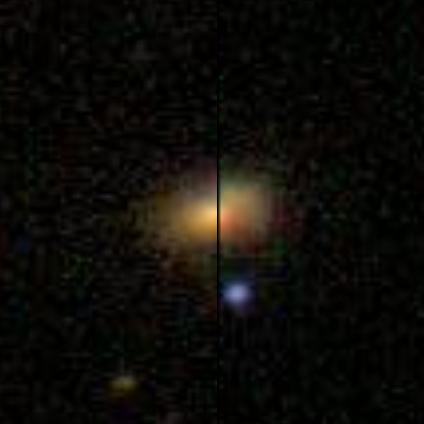

1.1 Smooth and rounded, no disk? smooth              0.512177
1.2 Smooth and rounded, no disk? features or disk    0.435136
1.3 Smooth and rounded, no disk? star or artifact    0.052687
2.1 Disk viewed edge on? yes                         0.072668
2.2 Disk viewed edge on? no                          0.362468
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.362468
4.1 Spiral arm? yes                                  0.179665
4.2 Spiral arm? no                                   0.182804
5.1 Prominent center bulge? no bulge                 0.051241
5.2 Prominent center bulge? noticable                0.102816
5.3 Prominent center bulge? obvious                  0.098413
5.4 Prominent center bulge? dominant                 0.109998
6.1 Anything odd? yes                                0.470813
6.2 Anything odd? no                                 0.529187
7.1 Is rounded? completely round                     0.020989
7.2 Is r

568258: ANOMALY

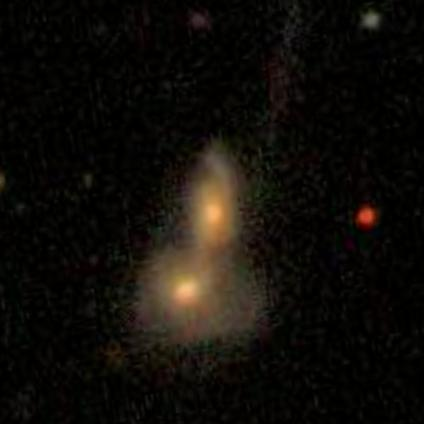

1.1 Smooth and rounded, no disk? smooth              0.099709
1.2 Smooth and rounded, no disk? features or disk    0.889570
1.3 Smooth and rounded, no disk? star or artifact    0.010722
2.1 Disk viewed edge on? yes                         0.016794
2.2 Disk viewed edge on? no                          0.872776
3.1 Bar feature through a center? yes                0.038919
3.2 Bar feature through a center? no                 0.833857
4.1 Spiral arm? yes                                  0.761877
4.2 Spiral arm? no                                   0.110899
5.1 Prominent center bulge? no bulge                 0.086799
5.2 Prominent center bulge? noticable                0.083896
5.3 Prominent center bulge? obvious                  0.643080
5.4 Prominent center bulge? dominant                 0.059001
6.1 Anything odd? yes                                0.951084
6.2 Anything odd? no                                 0.048916
7.1 Is rounded? completely round                     0.018104
7.2 Is r

684969: REGULAR

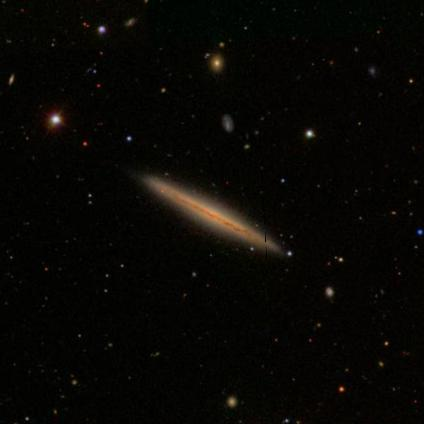

1.1 Smooth and rounded, no disk? smooth              0.282582
1.2 Smooth and rounded, no disk? features or disk    0.717418
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.684092
2.2 Disk viewed edge on? no                          0.033326
3.1 Bar feature through a center? yes                0.015855
3.2 Bar feature through a center? no                 0.017470
4.1 Spiral arm? yes                                  0.014289
4.2 Spiral arm? no                                   0.019036
5.1 Prominent center bulge? no bulge                 0.033326
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.489197
6.2 Anything odd? no                                 0.510803
7.1 Is rounded? completely round                     0.000000
7.2 Is r

556728: REGULAR

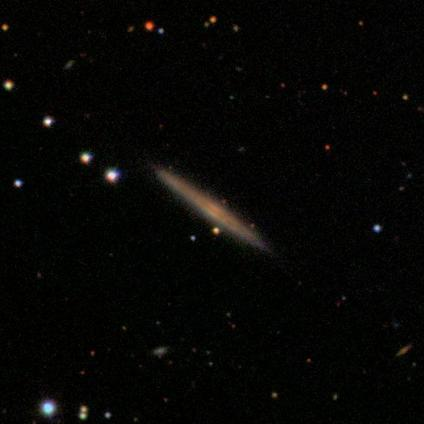

1.1 Smooth and rounded, no disk? smooth              0.150680
1.2 Smooth and rounded, no disk? features or disk    0.837954
1.3 Smooth and rounded, no disk? star or artifact    0.011366
2.1 Disk viewed edge on? yes                         0.787807
2.2 Disk viewed edge on? no                          0.050147
3.1 Bar feature through a center? yes                0.050147
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.050147
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.050147
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.295032
6.2 Anything odd? no                                 0.704968
7.1 Is rounded? completely round                     0.008438
7.2 Is r

485143: ANOMALY

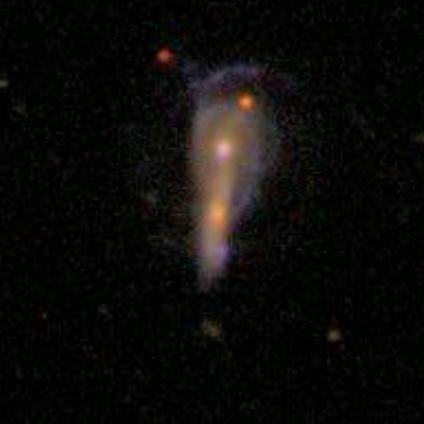

1.1 Smooth and rounded, no disk? smooth              0.093432
1.2 Smooth and rounded, no disk? features or disk    0.899843
1.3 Smooth and rounded, no disk? star or artifact    0.006725
2.1 Disk viewed edge on? yes                         0.067109
2.2 Disk viewed edge on? no                          0.832734
3.1 Bar feature through a center? yes                0.110256
3.2 Bar feature through a center? no                 0.722478
4.1 Spiral arm? yes                                  0.442232
4.2 Spiral arm? no                                   0.390501
5.1 Prominent center bulge? no bulge                 0.021136
5.2 Prominent center bulge? noticable                0.193589
5.3 Prominent center bulge? obvious                  0.576213
5.4 Prominent center bulge? dominant                 0.041797
6.1 Anything odd? yes                                1.000000
6.2 Anything odd? no                                 0.000000
7.1 Is rounded? completely round                     0.000000
7.2 Is r

901533: ANOMALY

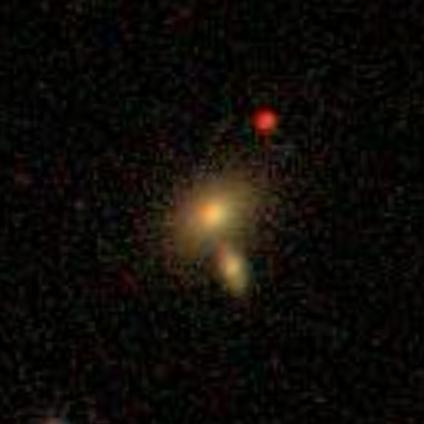

1.1 Smooth and rounded, no disk? smooth              0.625000
1.2 Smooth and rounded, no disk? features or disk    0.299040
1.3 Smooth and rounded, no disk? star or artifact    0.075960
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.299040
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.299040
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.299040
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.066588
5.3 Prominent center bulge? obvious                  0.232452
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.805265
6.2 Anything odd? no                                 0.194735
7.1 Is rounded? completely round                     0.057188
7.2 Is r

614737: ANOMALY

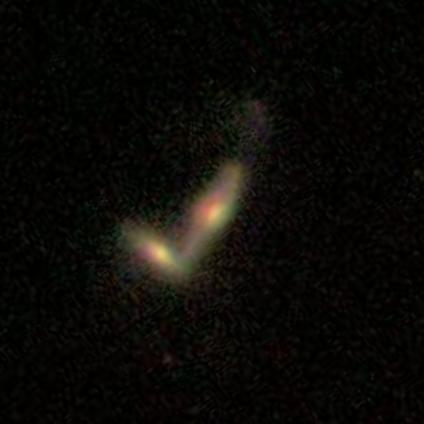

1.1 Smooth and rounded, no disk? smooth              0.068270
1.2 Smooth and rounded, no disk? features or disk    0.920413
1.3 Smooth and rounded, no disk? star or artifact    0.011318
2.1 Disk viewed edge on? yes                         0.821008
2.2 Disk viewed edge on? no                          0.099405
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.099405
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.099405
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.027592
5.3 Prominent center bulge? obvious                  0.071813
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.908403
6.2 Anything odd? no                                 0.091597
7.1 Is rounded? completely round                     0.000000
7.2 Is r

734747: ANOMALY

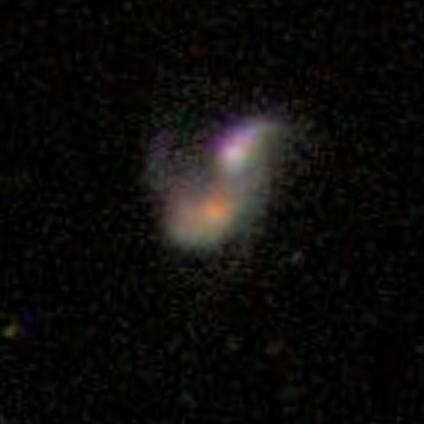

1.1 Smooth and rounded, no disk? smooth              0.042016
1.2 Smooth and rounded, no disk? features or disk    0.947015
1.3 Smooth and rounded, no disk? star or artifact    0.010969
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.947015
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.947015
4.1 Spiral arm? yes                                  0.408515
4.2 Spiral arm? no                                   0.538500
5.1 Prominent center bulge? no bulge                 0.044465
5.2 Prominent center bulge? noticable                0.350390
5.3 Prominent center bulge? obvious                  0.451949
5.4 Prominent center bulge? dominant                 0.100211
6.1 Anything odd? yes                                0.898979
6.2 Anything odd? no                                 0.101021
7.1 Is rounded? completely round                     0.007900
7.2 Is r

330625: ANOMALY

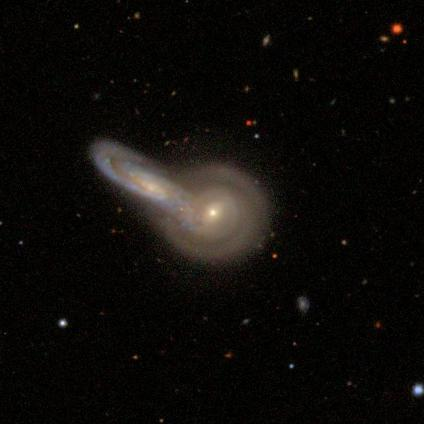

1.1 Smooth and rounded, no disk? smooth              0.157470
1.2 Smooth and rounded, no disk? features or disk    0.818719
1.3 Smooth and rounded, no disk? star or artifact    0.023811
2.1 Disk viewed edge on? yes                         0.175985
2.2 Disk viewed edge on? no                          0.642734
3.1 Bar feature through a center? yes                0.166151
3.2 Bar feature through a center? no                 0.476583
4.1 Spiral arm? yes                                  0.313367
4.2 Spiral arm? no                                   0.329367
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.308779
5.3 Prominent center bulge? obvious                  0.292095
5.4 Prominent center bulge? dominant                 0.041860
6.1 Anything odd? yes                                0.958168
6.2 Anything odd? no                                 0.041832
7.1 Is rounded? completely round                     0.157470
7.2 Is r

355256: ANOMALY

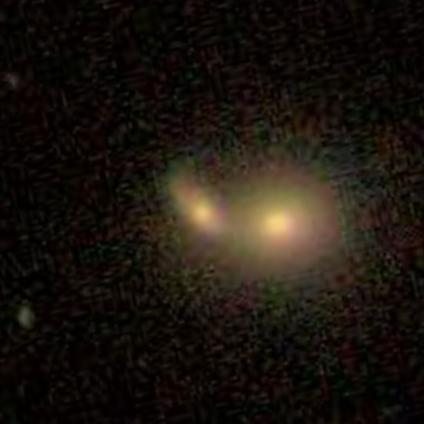

1.1 Smooth and rounded, no disk? smooth              0.369685
1.2 Smooth and rounded, no disk? features or disk    0.601618
1.3 Smooth and rounded, no disk? star or artifact    0.028697
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.601618
3.1 Bar feature through a center? yes                0.381753
3.2 Bar feature through a center? no                 0.219865
4.1 Spiral arm? yes                                  0.232051
4.2 Spiral arm? no                                   0.369567
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.230212
5.3 Prominent center bulge? obvious                  0.371406
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.895570
6.2 Anything odd? no                                 0.104430
7.1 Is rounded? completely round                     0.183365
7.2 Is r

419884: REGULAR

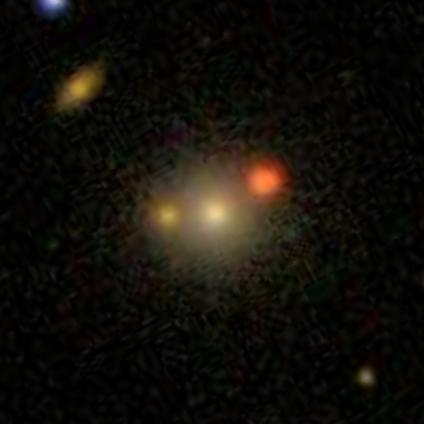

1.1 Smooth and rounded, no disk? smooth              0.494461
1.2 Smooth and rounded, no disk? features or disk    0.466316
1.3 Smooth and rounded, no disk? star or artifact    0.039223
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.466316
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.466316
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.466316
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.418337
5.4 Prominent center bulge? dominant                 0.047979
6.1 Anything odd? yes                                0.669151
6.2 Anything odd? no                                 0.330849
7.1 Is rounded? completely round                     0.438832
7.2 Is r

745382: ANOMALY

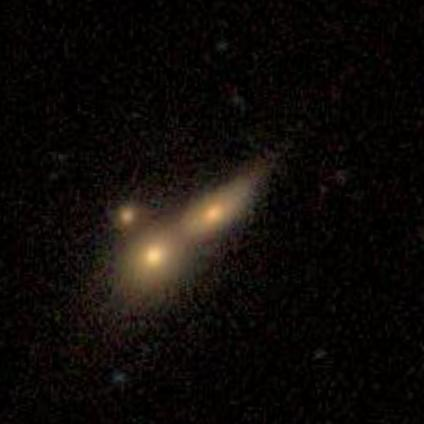

1.1 Smooth and rounded, no disk? smooth              0.352911
1.2 Smooth and rounded, no disk? features or disk    0.647089
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.181595
2.2 Disk viewed edge on? no                          0.465494
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.465494
4.1 Spiral arm? yes                                  0.057634
4.2 Spiral arm? no                                   0.407860
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.148073
5.3 Prominent center bulge? obvious                  0.274513
5.4 Prominent center bulge? dominant                 0.042907
6.1 Anything odd? yes                                0.867052
6.2 Anything odd? no                                 0.132948
7.1 Is rounded? completely round                     0.077310
7.2 Is r

393250: ANOMALY

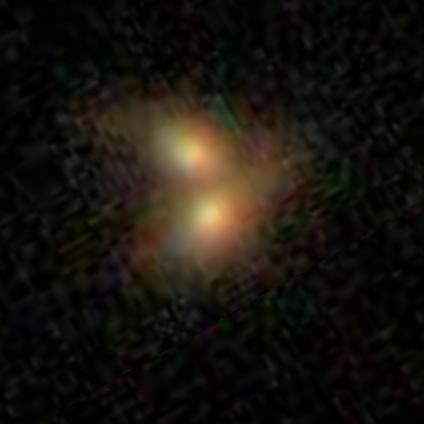

1.1 Smooth and rounded, no disk? smooth              0.419151
1.2 Smooth and rounded, no disk? features or disk    0.566683
1.3 Smooth and rounded, no disk? star or artifact    0.014166
2.1 Disk viewed edge on? yes                         0.146771
2.2 Disk viewed edge on? no                          0.419912
3.1 Bar feature through a center? yes                0.185656
3.2 Bar feature through a center? no                 0.234256
4.1 Spiral arm? yes                                  0.081333
4.2 Spiral arm? no                                   0.338579
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.157774
5.3 Prominent center bulge? obvious                  0.194631
5.4 Prominent center bulge? dominant                 0.067506
6.1 Anything odd? yes                                0.914870
6.2 Anything odd? no                                 0.085130
7.1 Is rounded? completely round                     0.063190
7.2 Is r

775625: ANOMALY

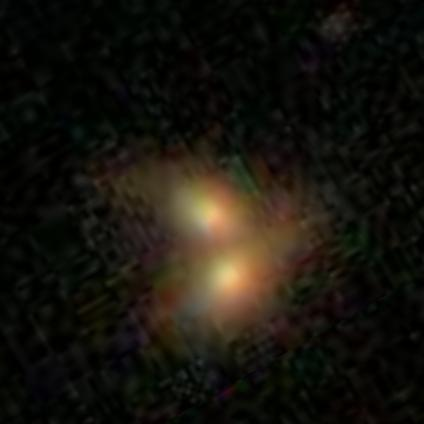

1.1 Smooth and rounded, no disk? smooth              0.350592
1.2 Smooth and rounded, no disk? features or disk    0.630481
1.3 Smooth and rounded, no disk? star or artifact    0.018926
2.1 Disk viewed edge on? yes                         0.022581
2.2 Disk viewed edge on? no                          0.607900
3.1 Bar feature through a center? yes                0.161813
3.2 Bar feature through a center? no                 0.446087
4.1 Spiral arm? yes                                  0.147156
4.2 Spiral arm? no                                   0.460744
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.135038
5.3 Prominent center bulge? obvious                  0.341905
5.4 Prominent center bulge? dominant                 0.130957
6.1 Anything odd? yes                                0.990984
6.2 Anything odd? no                                 0.009016
7.1 Is rounded? completely round                     0.034637
7.2 Is r

433705: REGULAR

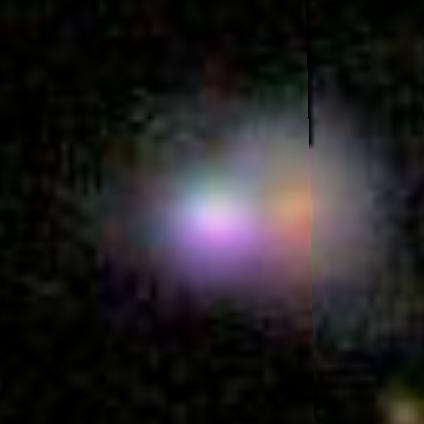

1.1 Smooth and rounded, no disk? smooth              0.571753
1.2 Smooth and rounded, no disk? features or disk    0.126594
1.3 Smooth and rounded, no disk? star or artifact    0.301653
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.126594
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.126594
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.126594
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.126594
6.1 Anything odd? yes                                0.874519
6.2 Anything odd? no                                 0.125481
7.1 Is rounded? completely round                     0.253168
7.2 Is r

160161: REGULAR

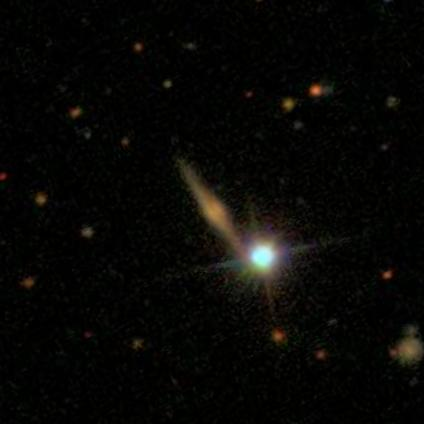

1.1 Smooth and rounded, no disk? smooth              0.021127
1.2 Smooth and rounded, no disk? features or disk    0.948061
1.3 Smooth and rounded, no disk? star or artifact    0.030812
2.1 Disk viewed edge on? yes                         0.948061
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.077323
6.2 Anything odd? no                                 0.922677
7.1 Is rounded? completely round                     0.000000
7.2 Is r

384624: REGULAR

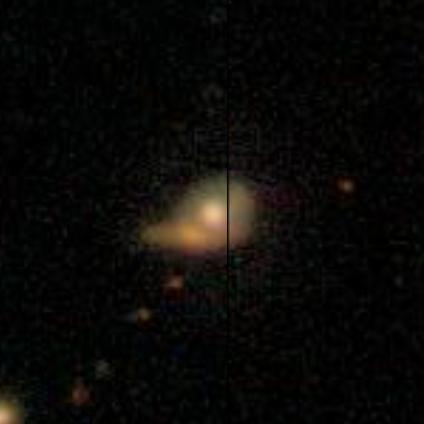

1.1 Smooth and rounded, no disk? smooth              0.287523
1.2 Smooth and rounded, no disk? features or disk    0.694772
1.3 Smooth and rounded, no disk? star or artifact    0.017705
2.1 Disk viewed edge on? yes                         0.040165
2.2 Disk viewed edge on? no                          0.654607
3.1 Bar feature through a center? yes                0.081922
3.2 Bar feature through a center? no                 0.572684
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.654607
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.052716
5.3 Prominent center bulge? obvious                  0.548110
5.4 Prominent center bulge? dominant                 0.053780
6.1 Anything odd? yes                                0.937572
6.2 Anything odd? no                                 0.062428
7.1 Is rounded? completely round                     0.198607
7.2 Is r

899248: ANOMALY

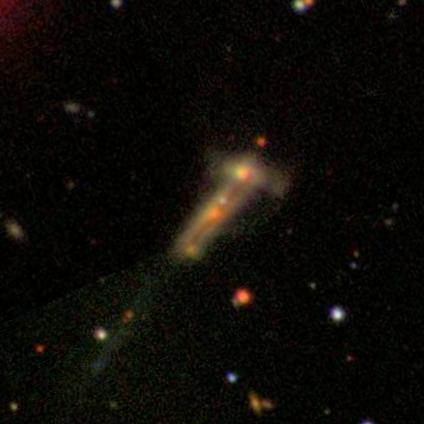

1.1 Smooth and rounded, no disk? smooth              0.033705
1.2 Smooth and rounded, no disk? features or disk    0.792188
1.3 Smooth and rounded, no disk? star or artifact    0.174107
2.1 Disk viewed edge on? yes                         0.547036
2.2 Disk viewed edge on? no                          0.245152
3.1 Bar feature through a center? yes                0.044256
3.2 Bar feature through a center? no                 0.200896
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.245152
5.1 Prominent center bulge? no bulge                 0.104130
5.2 Prominent center bulge? noticable                0.017814
5.3 Prominent center bulge? obvious                  0.081225
5.4 Prominent center bulge? dominant                 0.041984
6.1 Anything odd? yes                                0.975659
6.2 Anything odd? no                                 0.024341
7.1 Is rounded? completely round                     0.033705
7.2 Is r

475941: REGULAR

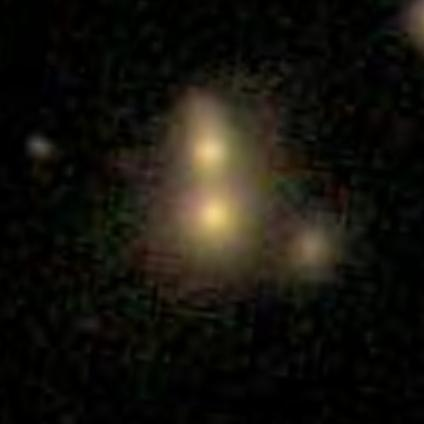

1.1 Smooth and rounded, no disk? smooth              0.494800
1.2 Smooth and rounded, no disk? features or disk    0.412577
1.3 Smooth and rounded, no disk? star or artifact    0.092623
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.412577
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.412577
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.412577
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.241895
5.4 Prominent center bulge? dominant                 0.170682
6.1 Anything odd? yes                                0.965406
6.2 Anything odd? no                                 0.034594
7.1 Is rounded? completely round                     0.259622
7.2 Is r

987069: REGULAR

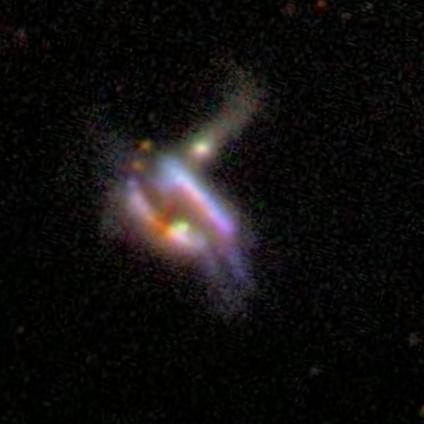

1.1 Smooth and rounded, no disk? smooth              0.040747
1.2 Smooth and rounded, no disk? features or disk    0.734090
1.3 Smooth and rounded, no disk? star or artifact    0.225163
2.1 Disk viewed edge on? yes                         0.054876
2.2 Disk viewed edge on? no                          0.679214
3.1 Bar feature through a center? yes                0.124014
3.2 Bar feature through a center? no                 0.555200
4.1 Spiral arm? yes                                  0.097826
4.2 Spiral arm? no                                   0.581387
5.1 Prominent center bulge? no bulge                 0.478651
5.2 Prominent center bulge? noticable                0.110746
5.3 Prominent center bulge? obvious                  0.029864
5.4 Prominent center bulge? dominant                 0.059953
6.1 Anything odd? yes                                0.956384
6.2 Anything odd? no                                 0.043616
7.1 Is rounded? completely round                     0.000000
7.2 Is r

114433: ANOMALY

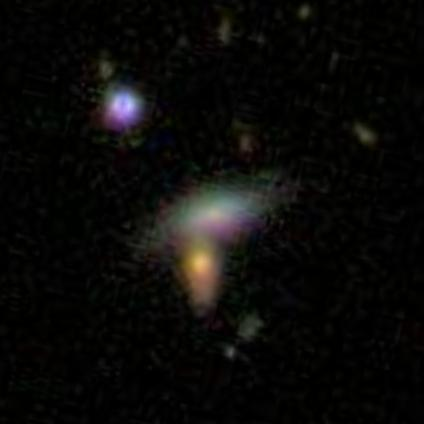

1.1 Smooth and rounded, no disk? smooth              0.366300
1.2 Smooth and rounded, no disk? features or disk    0.612291
1.3 Smooth and rounded, no disk? star or artifact    0.021408
2.1 Disk viewed edge on? yes                         0.175115
2.2 Disk viewed edge on? no                          0.437176
3.1 Bar feature through a center? yes                0.164950
3.2 Bar feature through a center? no                 0.272226
4.1 Spiral arm? yes                                  0.164015
4.2 Spiral arm? no                                   0.273161
5.1 Prominent center bulge? no bulge                 0.140923
5.2 Prominent center bulge? noticable                0.262097
5.3 Prominent center bulge? obvious                  0.020355
5.4 Prominent center bulge? dominant                 0.013801
6.1 Anything odd? yes                                0.752765
6.2 Anything odd? no                                 0.247235
7.1 Is rounded? completely round                     0.000000
7.2 Is r

527918: ANOMALY

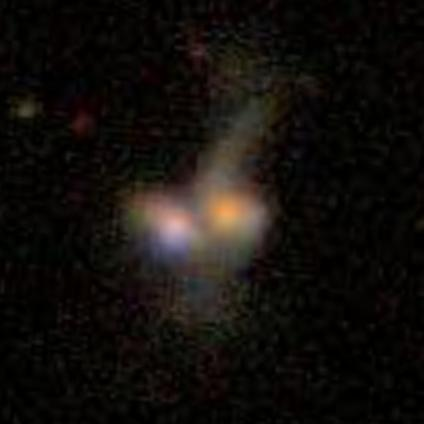

1.1 Smooth and rounded, no disk? smooth              0.089792
1.2 Smooth and rounded, no disk? features or disk    0.898882
1.3 Smooth and rounded, no disk? star or artifact    0.011326
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.898882
3.1 Bar feature through a center? yes                0.220065
3.2 Bar feature through a center? no                 0.678817
4.1 Spiral arm? yes                                  0.602409
4.2 Spiral arm? no                                   0.296473
5.1 Prominent center bulge? no bulge                 0.066472
5.2 Prominent center bulge? noticable                0.194591
5.3 Prominent center bulge? obvious                  0.398896
5.4 Prominent center bulge? dominant                 0.238923
6.1 Anything odd? yes                                1.000000
6.2 Anything odd? no                                 0.000000
7.1 Is rounded? completely round                     0.013634
7.2 Is r

646758: REGULAR

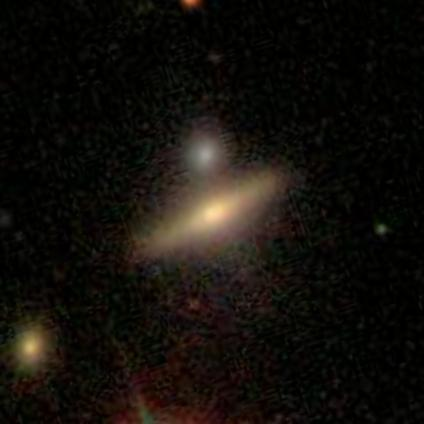

1.1 Smooth and rounded, no disk? smooth              0.314085
1.2 Smooth and rounded, no disk? features or disk    0.685915
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.496921
2.2 Disk viewed edge on? no                          0.188994
3.1 Bar feature through a center? yes                0.188994
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.188994
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.125195
5.3 Prominent center bulge? obvious                  0.063799
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.371993
6.2 Anything odd? no                                 0.628007
7.1 Is rounded? completely round                     0.000000
7.2 Is r

304185: ANOMALY

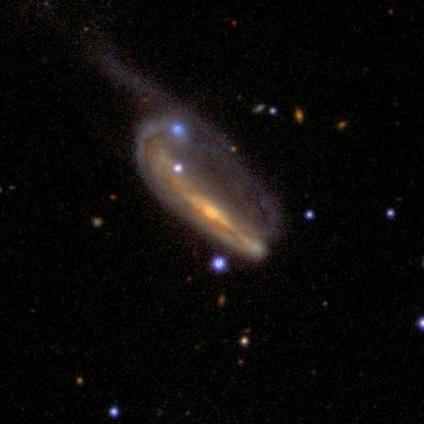

1.1 Smooth and rounded, no disk? smooth              0.123112
1.2 Smooth and rounded, no disk? features or disk    0.852530
1.3 Smooth and rounded, no disk? star or artifact    0.024358
2.1 Disk viewed edge on? yes                         0.559088
2.2 Disk viewed edge on? no                          0.293442
3.1 Bar feature through a center? yes                0.060814
3.2 Bar feature through a center? no                 0.232627
4.1 Spiral arm? yes                                  0.107843
4.2 Spiral arm? no                                   0.185599
5.1 Prominent center bulge? no bulge                 0.201617
5.2 Prominent center bulge? noticable                0.037400
5.3 Prominent center bulge? obvious                  0.054424
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.811676
6.2 Anything odd? no                                 0.188324
7.1 Is rounded? completely round                     0.030778
7.2 Is r

487195: REGULAR

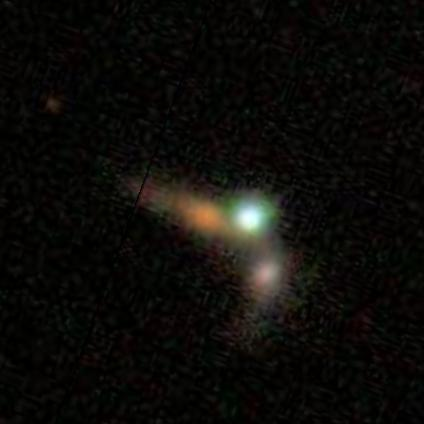

1.1 Smooth and rounded, no disk? smooth              0.462000
1.2 Smooth and rounded, no disk? features or disk    0.323000
1.3 Smooth and rounded, no disk? star or artifact    0.215000
2.1 Disk viewed edge on? yes                         0.138567
2.2 Disk viewed edge on? no                          0.184433
3.1 Bar feature through a center? yes                0.023054
3.2 Bar feature through a center? no                 0.161379
4.1 Spiral arm? yes                                  0.023054
4.2 Spiral arm? no                                   0.161379
5.1 Prominent center bulge? no bulge                 0.069162
5.2 Prominent center bulge? noticable                0.023054
5.3 Prominent center bulge? obvious                  0.046108
5.4 Prominent center bulge? dominant                 0.046108
6.1 Anything odd? yes                                0.676000
6.2 Anything odd? no                                 0.324000
7.1 Is rounded? completely round                     0.138600
7.2 Is r

364495: ANOMALY

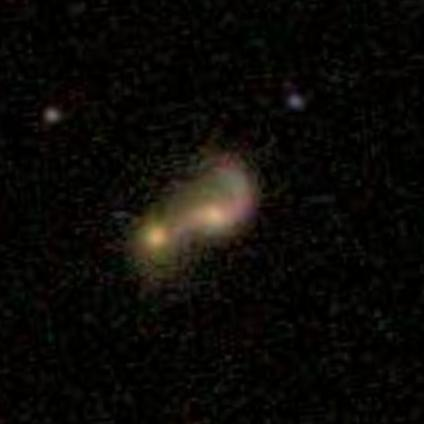

1.1 Smooth and rounded, no disk? smooth              0.053479
1.2 Smooth and rounded, no disk? features or disk    0.945478
1.3 Smooth and rounded, no disk? star or artifact    0.001043
2.1 Disk viewed edge on? yes                         0.037704
2.2 Disk viewed edge on? no                          0.907774
3.1 Bar feature through a center? yes                0.454907
3.2 Bar feature through a center? no                 0.452867
4.1 Spiral arm? yes                                  0.845414
4.2 Spiral arm? no                                   0.062360
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.495725
5.3 Prominent center bulge? obvious                  0.379196
5.4 Prominent center bulge? dominant                 0.032854
6.1 Anything odd? yes                                0.848651
6.2 Anything odd? no                                 0.151349
7.1 Is rounded? completely round                     0.017274
7.2 Is r

342049: REGULAR

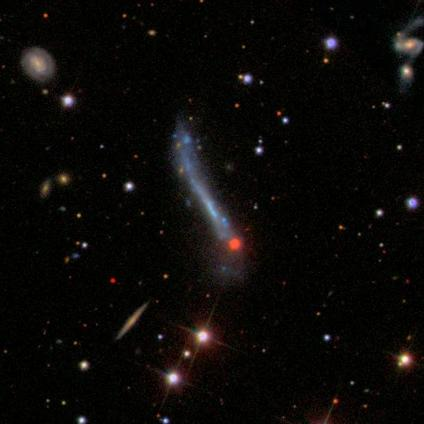

1.1 Smooth and rounded, no disk? smooth              0.200200
1.2 Smooth and rounded, no disk? features or disk    0.621622
1.3 Smooth and rounded, no disk? star or artifact    0.178178
2.1 Disk viewed edge on? yes                         0.356811
2.2 Disk viewed edge on? no                          0.264811
3.1 Bar feature through a center? yes                0.044488
3.2 Bar feature through a center? no                 0.220323
4.1 Spiral arm? yes                                  0.044488
4.2 Spiral arm? no                                   0.220323
5.1 Prominent center bulge? no bulge                 0.242567
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.022244
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.864000
6.2 Anything odd? no                                 0.136000
7.1 Is rounded? completely round                     0.000000
7.2 Is r

689187: REGULAR

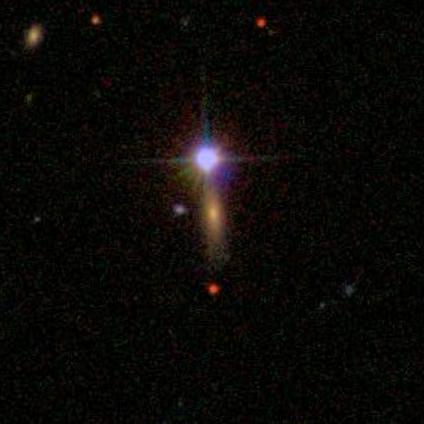

1.1 Smooth and rounded, no disk? smooth              0.291334
1.2 Smooth and rounded, no disk? features or disk    0.451043
1.3 Smooth and rounded, no disk? star or artifact    0.257623
2.1 Disk viewed edge on? yes                         0.174080
2.2 Disk viewed edge on? no                          0.276963
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.276963
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.276963
5.1 Prominent center bulge? no bulge                 0.131900
5.2 Prominent center bulge? noticable                0.071604
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.073459
6.1 Anything odd? yes                                0.170855
6.2 Anything odd? no                                 0.829145
7.1 Is rounded? completely round                     0.036519
7.2 Is r

439242: ANOMALY

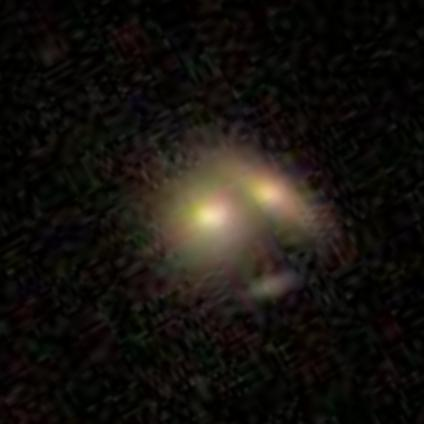

1.1 Smooth and rounded, no disk? smooth              0.576861
1.2 Smooth and rounded, no disk? features or disk    0.423139
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.423139
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.423139
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.423139
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.051669
5.3 Prominent center bulge? obvious                  0.371470
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.969915
6.2 Anything odd? no                                 0.030085
7.1 Is rounded? completely round                     0.353143
7.2 Is r

535144: REGULAR

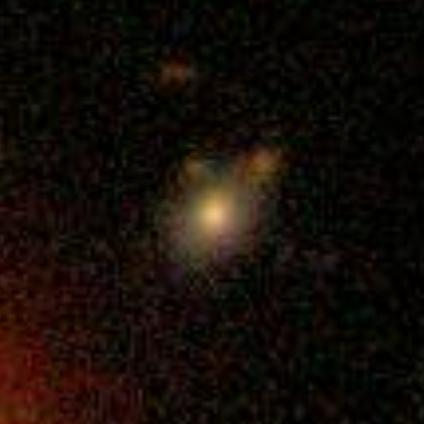

1.1 Smooth and rounded, no disk? smooth              0.334587
1.2 Smooth and rounded, no disk? features or disk    0.652434
1.3 Smooth and rounded, no disk? star or artifact    0.012980
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.652434
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.652434
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.652434
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.433311
5.4 Prominent center bulge? dominant                 0.219123
6.1 Anything odd? yes                                0.688864
6.2 Anything odd? no                                 0.311136
7.1 Is rounded? completely round                     0.105056
7.2 Is r

762295: ANOMALY

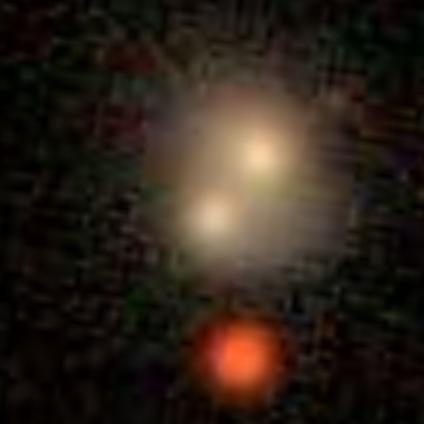

1.1 Smooth and rounded, no disk? smooth              0.512759
1.2 Smooth and rounded, no disk? features or disk    0.382181
1.3 Smooth and rounded, no disk? star or artifact    0.105060
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.382181
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.382181
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.382181
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.096577
5.3 Prominent center bulge? obvious                  0.140309
5.4 Prominent center bulge? dominant                 0.145296
6.1 Anything odd? yes                                0.956115
6.2 Anything odd? no                                 0.043885
7.1 Is rounded? completely round                     0.442463
7.2 Is r

546118: REGULAR

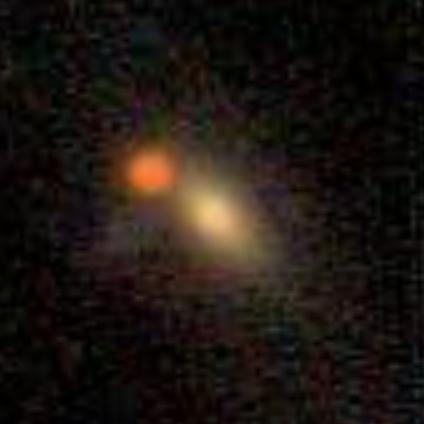

1.1 Smooth and rounded, no disk? smooth              0.676124
1.2 Smooth and rounded, no disk? features or disk    0.294264
1.3 Smooth and rounded, no disk? star or artifact    0.029612
2.1 Disk viewed edge on? yes                         0.147132
2.2 Disk viewed edge on? no                          0.147132
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.147132
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.147132
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.094704
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.052428
6.1 Anything odd? yes                                0.816027
6.2 Anything odd? no                                 0.183973
7.1 Is rounded? completely round                     0.076085
7.2 Is r

729969: REGULAR

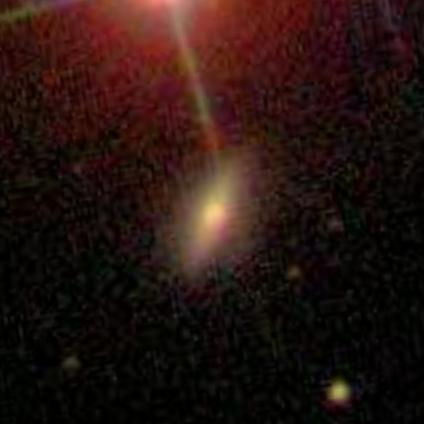

1.1 Smooth and rounded, no disk? smooth              0.434028
1.2 Smooth and rounded, no disk? features or disk    0.499929
1.3 Smooth and rounded, no disk? star or artifact    0.066043
2.1 Disk viewed edge on? yes                         0.382044
2.2 Disk viewed edge on? no                          0.117885
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.117885
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.117885
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.117885
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.145302
6.2 Anything odd? no                                 0.854698
7.1 Is rounded? completely round                     0.000000
7.2 Is r

165128: ANOMALY

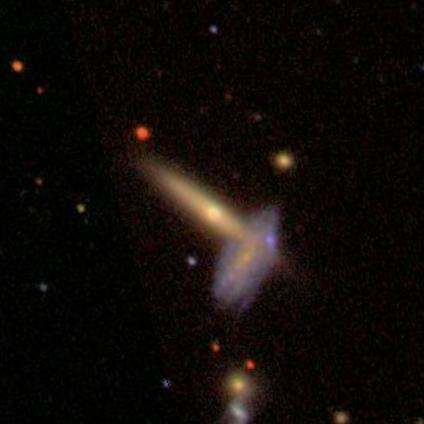

1.1 Smooth and rounded, no disk? smooth              0.229349
1.2 Smooth and rounded, no disk? features or disk    0.769517
1.3 Smooth and rounded, no disk? star or artifact    0.001134
2.1 Disk viewed edge on? yes                         0.598684
2.2 Disk viewed edge on? no                          0.170833
3.1 Bar feature through a center? yes                0.074917
3.2 Bar feature through a center? no                 0.095916
4.1 Spiral arm? yes                                  0.147588
4.2 Spiral arm? no                                   0.023245
5.1 Prominent center bulge? no bulge                 0.039202
5.2 Prominent center bulge? noticable                0.119196
5.3 Prominent center bulge? obvious                  0.012435
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.692313
6.2 Anything odd? no                                 0.307687
7.1 Is rounded? completely round                     0.000000
7.2 Is r

604859: REGULAR

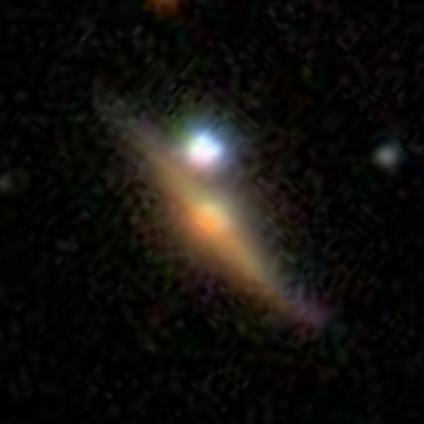

1.1 Smooth and rounded, no disk? smooth              0.057217
1.2 Smooth and rounded, no disk? features or disk    0.942783
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.942783
2.2 Disk viewed edge on? no                          0.000000
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.000000
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.000000
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.476033
6.2 Anything odd? no                                 0.523967
7.1 Is rounded? completely round                     0.000000
7.2 Is r

823504: REGULAR

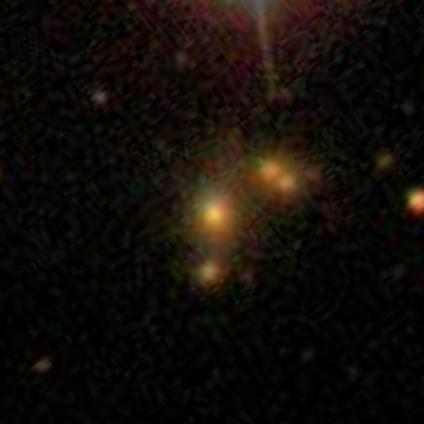

1.1 Smooth and rounded, no disk? smooth              0.689526
1.2 Smooth and rounded, no disk? features or disk    0.158199
1.3 Smooth and rounded, no disk? star or artifact    0.152275
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.158199
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.158199
4.1 Spiral arm? yes                                  0.086608
4.2 Spiral arm? no                                   0.071591
5.1 Prominent center bulge? no bulge                 0.044060
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.114139
6.1 Anything odd? yes                                0.737704
6.2 Anything odd? no                                 0.262296
7.1 Is rounded? completely round                     0.470043
7.2 Is r

689178: REGULAR

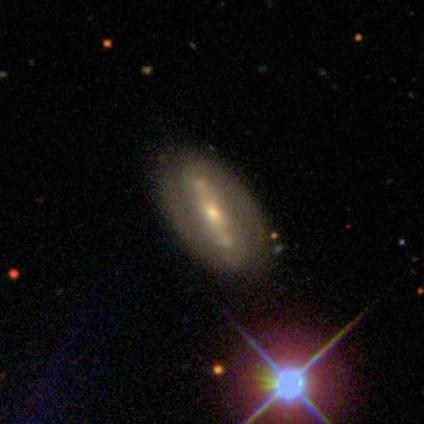

1.1 Smooth and rounded, no disk? smooth              0.000000
1.2 Smooth and rounded, no disk? features or disk    1.000000
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          1.000000
3.1 Bar feature through a center? yes                0.787487
3.2 Bar feature through a center? no                 0.212513
4.1 Spiral arm? yes                                  0.581436
4.2 Spiral arm? no                                   0.418564
5.1 Prominent center bulge? no bulge                 0.032371
5.2 Prominent center bulge? noticable                0.261886
5.3 Prominent center bulge? obvious                  0.653007
5.4 Prominent center bulge? dominant                 0.052736
6.1 Anything odd? yes                                0.154078
6.2 Anything odd? no                                 0.845922
7.1 Is rounded? completely round                     0.000000
7.2 Is r

794417: ANOMALY

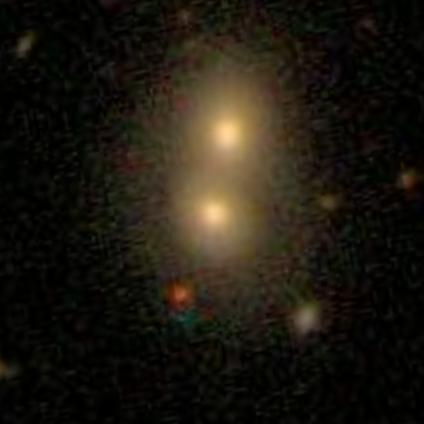

1.1 Smooth and rounded, no disk? smooth              0.369539
1.2 Smooth and rounded, no disk? features or disk    0.608288
1.3 Smooth and rounded, no disk? star or artifact    0.022174
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.608288
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.608288
4.1 Spiral arm? yes                                  0.123619
4.2 Spiral arm? no                                   0.484669
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.056427
5.3 Prominent center bulge? obvious                  0.296349
5.4 Prominent center bulge? dominant                 0.255511
6.1 Anything odd? yes                                0.974825
6.2 Anything odd? no                                 0.025175
7.1 Is rounded? completely round                     0.280203
7.2 Is r

164836: ANOMALY

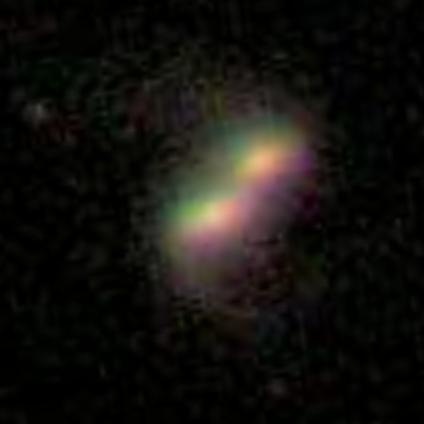

1.1 Smooth and rounded, no disk? smooth              0.307284
1.2 Smooth and rounded, no disk? features or disk    0.613435
1.3 Smooth and rounded, no disk? star or artifact    0.079282
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.613435
3.1 Bar feature through a center? yes                0.245912
3.2 Bar feature through a center? no                 0.367523
4.1 Spiral arm? yes                                  0.310011
4.2 Spiral arm? no                                   0.303424
5.1 Prominent center bulge? no bulge                 0.129742
5.2 Prominent center bulge? noticable                0.079104
5.3 Prominent center bulge? obvious                  0.213239
5.4 Prominent center bulge? dominant                 0.191349
6.1 Anything odd? yes                                0.988904
6.2 Anything odd? no                                 0.011096
7.1 Is rounded? completely round                     0.019401
7.2 Is r

522006: ANOMALY

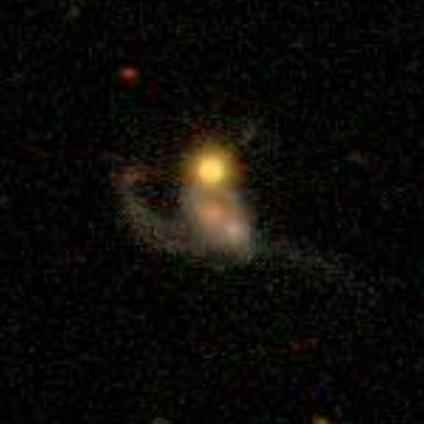

1.1 Smooth and rounded, no disk? smooth              0.135216
1.2 Smooth and rounded, no disk? features or disk    0.838523
1.3 Smooth and rounded, no disk? star or artifact    0.026261
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.838523
3.1 Bar feature through a center? yes                0.061044
3.2 Bar feature through a center? no                 0.777479
4.1 Spiral arm? yes                                  0.466162
4.2 Spiral arm? no                                   0.372361
5.1 Prominent center bulge? no bulge                 0.022050
5.2 Prominent center bulge? noticable                0.469644
5.3 Prominent center bulge? obvious                  0.252250
5.4 Prominent center bulge? dominant                 0.094579
6.1 Anything odd? yes                                0.918996
6.2 Anything odd? no                                 0.081004
7.1 Is rounded? completely round                     0.038077
7.2 Is r

172936: REGULAR

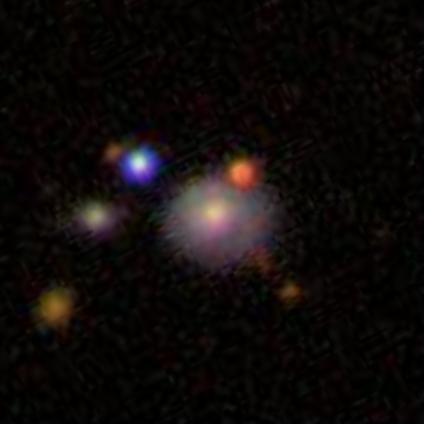

1.1 Smooth and rounded, no disk? smooth              0.519996
1.2 Smooth and rounded, no disk? features or disk    0.448083
1.3 Smooth and rounded, no disk? star or artifact    0.031921
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.448083
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.448083
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.448083
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.089695
5.3 Prominent center bulge? obvious                  0.358388
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.626382
6.2 Anything odd? no                                 0.373618
7.1 Is rounded? completely round                     0.388389
7.2 Is r

586459: ANOMALY

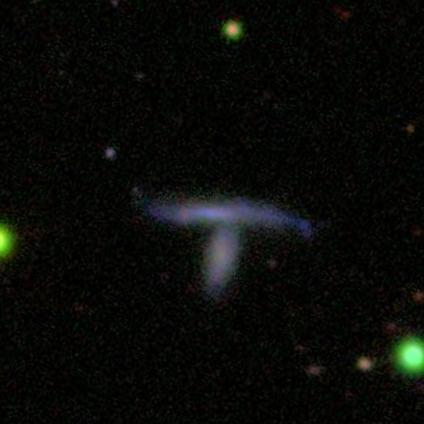

1.1 Smooth and rounded, no disk? smooth              0.300237
1.2 Smooth and rounded, no disk? features or disk    0.649874
1.3 Smooth and rounded, no disk? star or artifact    0.049889
2.1 Disk viewed edge on? yes                         0.361335
2.2 Disk viewed edge on? no                          0.288539
3.1 Bar feature through a center? yes                0.073590
3.2 Bar feature through a center? no                 0.214948
4.1 Spiral arm? yes                                  0.095854
4.2 Spiral arm? no                                   0.192685
5.1 Prominent center bulge? no bulge                 0.288539
5.2 Prominent center bulge? noticable                0.000000
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.923459
6.2 Anything odd? no                                 0.076541
7.1 Is rounded? completely round                     0.000000
7.2 Is r

251840: REGULAR

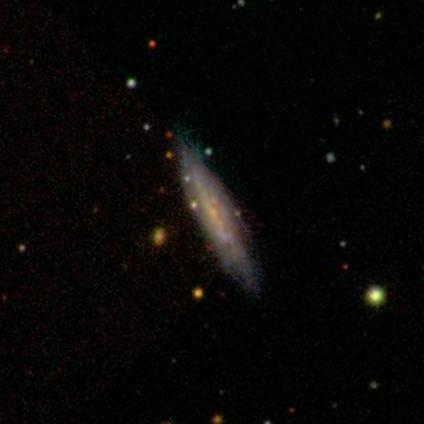

1.1 Smooth and rounded, no disk? smooth              0.208598
1.2 Smooth and rounded, no disk? features or disk    0.791402
1.3 Smooth and rounded, no disk? star or artifact    0.000000
2.1 Disk viewed edge on? yes                         0.367886
2.2 Disk viewed edge on? no                          0.423516
3.1 Bar feature through a center? yes                0.059365
3.2 Bar feature through a center? no                 0.364151
4.1 Spiral arm? yes                                  0.021668
4.2 Spiral arm? no                                   0.401848
5.1 Prominent center bulge? no bulge                 0.254025
5.2 Prominent center bulge? noticable                0.169491
5.3 Prominent center bulge? obvious                  0.000000
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.294160
6.2 Anything odd? no                                 0.705840
7.1 Is rounded? completely round                     0.000000
7.2 Is r

291269: ANOMALY

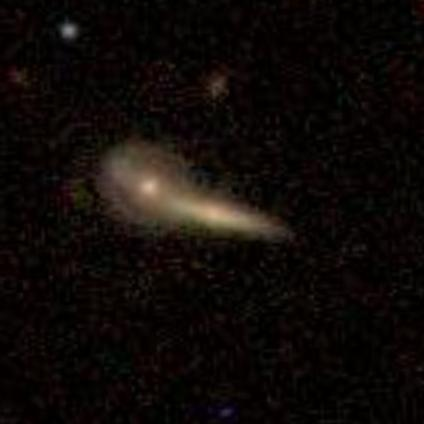

1.1 Smooth and rounded, no disk? smooth              0.028048
1.2 Smooth and rounded, no disk? features or disk    0.968914
1.3 Smooth and rounded, no disk? star or artifact    0.003038
2.1 Disk viewed edge on? yes                         0.624950
2.2 Disk viewed edge on? no                          0.343964
3.1 Bar feature through a center? yes                0.163569
3.2 Bar feature through a center? no                 0.180395
4.1 Spiral arm? yes                                  0.111162
4.2 Spiral arm? no                                   0.232802
5.1 Prominent center bulge? no bulge                 0.013630
5.2 Prominent center bulge? noticable                0.214812
5.3 Prominent center bulge? obvious                  0.115523
5.4 Prominent center bulge? dominant                 0.000000
6.1 Anything odd? yes                                0.952760
6.2 Anything odd? no                                 0.047240
7.1 Is rounded? completely round                     0.000000
7.2 Is r

701350: ANOMALY

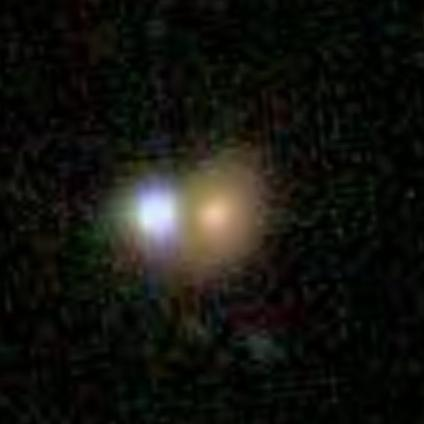

1.1 Smooth and rounded, no disk? smooth              0.429474
1.2 Smooth and rounded, no disk? features or disk    0.520360
1.3 Smooth and rounded, no disk? star or artifact    0.050166
2.1 Disk viewed edge on? yes                         0.000000
2.2 Disk viewed edge on? no                          0.520360
3.1 Bar feature through a center? yes                0.000000
3.2 Bar feature through a center? no                 0.520360
4.1 Spiral arm? yes                                  0.000000
4.2 Spiral arm? no                                   0.520360
5.1 Prominent center bulge? no bulge                 0.000000
5.2 Prominent center bulge? noticable                0.122498
5.3 Prominent center bulge? obvious                  0.233169
5.4 Prominent center bulge? dominant                 0.164693
6.1 Anything odd? yes                                0.794871
6.2 Anything odd? no                                 0.205129
7.1 Is rounded? completely round                     0.244035
7.2 Is r

In [96]:
trace_galaxy_zoo_2(cmp_86_40.pineforest_session)

In [116]:
solutions = pd.read_csv("../../data/gz2/training_solutions_rev1.csv", index_col="GalaxyID")
print((solutions.loc[ids[list(cmp_61_90.pineforest_session.known_labels.keys())]]["Class8.6"] >= 0.4).sum())
print((solutions.loc[ids[list(cmp_86_40.pineforest_session.known_labels.keys())]]["Class8.6"] >= 0.4).sum())

39
43
